## Setup

In [0]:
# Install the PyDrive wrapper & import libraries.
# This only needs to be done once per notebook.
!pip install -U -q PyDrive
from pydrive.auth import GoogleAuth
from pydrive.drive import GoogleDrive
from google.colab import auth
from oauth2client.client import GoogleCredentials

import torch
import string
import unicodedata
# try to load the json data
import json
import torch.nn as nn
import time
import torch.optim as optim
import torch.nn.functional as F
from random import choice, choices, shuffle, randint

import matplotlib.pyplot as plt

assert torch.cuda.is_available()

     |████████████████████████████████| 993kB 2.8MB/s 


In [0]:
# Authenticate and create the PyDrive client.
# This only needs to be done once per notebook.
auth.authenticate_user()
gauth = GoogleAuth()
gauth.credentials = GoogleCredentials.get_application_default()
drive = GoogleDrive(gauth)

# Download a file based on its file ID.
#https://drive.google.com/open?id=1axFOiWZPTm-ncltlFUWZIptLoTNdtlYg
# A file ID looks like: laggVyWshwcyP6kEI-y_W3P8D26sz
file_id = '1axFOiWZPTm-ncltlFUWZIptLoTNdtlYg'
downloaded = drive.CreateFile({'id': file_id})
print('Downloaded content with length "{}"'.format(len(downloaded.GetContentString())))

jsonObject = json.loads(downloaded.GetContentString())

print(type(jsonObject))
print(len(jsonObject))
print(jsonObject[0])

all_categories = []
articles_dict = dict()
for article in jsonObject:
    category = article["category"]
    if category not in all_categories:
        all_categories.append(category)
        articles_dict[category] = []
    articles_dict[category].append(article)
    
n_categories = len(articles_dict.keys())

weights_all_categories = []
for category in all_categories:
    print("{} : {}".format(category, len(articles_dict[category])))
    weights_all_categories.append(len(articles_dict[category])/len(jsonObject))
print(weights_all_categories)

n_letters = len(string.printable)+1

def lineToCNNTensor(text):
    tensor = torch.zeros(1, len(text), n_letters)
    # this is splitting letters with accents into letter + accent
    normalized = unicodedata.normalize("NFD", text)
    for idx, char in enumerate(normalized):
        if unicodedata.category(char) == "Mn":
            continue
        # characters not in string.printable get a "pos" of -1,
        # which goes into the "trash" coordinate
        pos = string.printable.find(char)
        tensor[0, idx, pos] = 1
    return tensor

print(lineToCNNTensor("Ro"))
print(lineToCNNTensor("ro").shape)

Downloaded content with length "669380879"
<class 'list'>
573371
{'id': 'http://arxiv.org/abs/1904.03835v4', 'category': 'Physics', 'subject': 'astro-ph.CO', 'title': 'Kaon oscillations and baryon asymmetry of the universe', 'abstract': 'Baryon asymmetry of the universe (BAU) is naturally explained with\n$K^0-K^{0\'}$ oscillations of a newly developed mirror-matter model and new\nunderstanding of quantum chromodynamics (QCD) phase transitions. A consistent\npicture for the origin of both BAU and dark matter is presented with the aid of\n$n-n\'$ oscillations of the new model. The global symmetry breaking transitions\nin QCD are proposed to be staged depending on condensation temperatures of\nstrange, charm, bottom, and top quarks in the early universe. The long-standing\nBAU puzzle can then be understood with $K^0-K^{0\'}$ oscillations that occur at\nthe stage of strange quark condensation and baryon number violation via a\nnon-perturbative instanton-like (coined "quarkiton") process. S

In [0]:
training_percentage = 0.8
training_dict = dict()
testing_dict = dict()
for cat in all_categories:
    all_articles = articles_dict[cat]
    shuffle(all_articles)
    p = int(len(all_articles)*training_percentage)
    training_dict[cat] = all_articles[:p]
    testing_dict[cat] = all_articles[p+1:]
    
def print_statistics(use_first_characters):
    print("With regards to abstracts of length at least {},".format(use_first_characters))
    for cat in all_categories:
        print("\t{:6} abstracts for {}".format(
                len(list(filter(lambda art: len(art["abstract"]) >= use_first_characters, articles_dict[cat]))),
                cat))
              
print_statistics(300)

With regards to abstracts of length at least 300,
	202723 abstracts for Physics
	140984 abstracts for Computer Science
	   669 abstracts for Economics
	  6266 abstracts for Electrical Engineering and Systems Science
	136506 abstracts for Mathematics
	 25498 abstracts for Quantitative Biology
	 11504 abstracts for Quantitative Finance
	 21839 abstracts for Statistics


In [0]:
class CNN_model(nn.Module):
    def __init__(self, abstract_length, characters_used, output_size):
        super(CNN_model, self).__init__()

        self.abstract_length = abstract_length
        self.characters_used = characters_used
        self.output_size = output_size
        
        self.pool = nn.MaxPool2d(2, 2)
        self.conv1 = nn.Conv2d(1, 6, 10)
        self.conv2 = nn.Conv2d(6, 12, 10)
        # final dimensions
        fin_dim = (((abstract_length-9)//2-9)//2, ((characters_used-9)//2-9)//2)
        self.fin_dim = fin_dim
        self.linear1 = nn.Linear(12*fin_dim[0]*fin_dim[1], 4*fin_dim[0]*fin_dim[1])
        self.linear2 = nn.Linear(4*fin_dim[0]*fin_dim[1], output_size)

    def forward(self, x):
        # let AL stand for abstract length and CU for characters used
        ### each batch element has size (1, AL, CU)
        x = F.relu(self.conv1(x))
        ### each batch element has size (6, AL-10+1, CU-10+1)
        x = self.pool(x)
        ### each batch element has size (6, (AL-9)//2, (CU-9)//2)
        x = F.relu(self.conv2(x))
        ### size (12, (AL-9)//2-9, (CU-9)//2-9)
        x = self.pool(x)
        ### size (12, ((AL-9)//2-9)//2, ((CU-9)//2-9))//2)
        x = x.view(-1, 12*self.fin_dim[0]*self.fin_dim[1])
        x = self.linear2(F.relu(self.linear1(x)))
        return x
      
class leakyCNN_model(nn.Module):
    def __init__(self, abstract_length, characters_used, output_size):
        super(leakyCNN_model, self).__init__()

        self.abstract_length = abstract_length
        self.characters_used = characters_used
        self.output_size = output_size
        
        self.pool = nn.MaxPool2d(2, 2)
        self.conv1 = nn.Conv2d(1, 6, 10)
        self.conv2 = nn.Conv2d(6, 12, 10)
        # final dimensions
        fin_dim = (((abstract_length-9)//2-9)//2, ((characters_used-9)//2-9)//2)
        self.fin_dim = fin_dim
        self.linear1 = nn.Linear(12*fin_dim[0]*fin_dim[1], 4*fin_dim[0]*fin_dim[1])
        self.linear2 = nn.Linear(4*fin_dim[0]*fin_dim[1], output_size)

    def forward(self, x):
        # let AL stand for abstract length and CU for characters used
        ### each batch element has size (1, AL, CU)
        x = F.leaky_relu(self.conv1(x))
        ### each batch element has size (6, AL-10+1, CU-10+1)
        x = self.pool(x)
        ### each batch element has size (6, (AL-9)//2, (CU-9)//2)
        x = F.leaky_relu(self.conv2(x))
        ### size (12, (AL-9)//2-9, (CU-9)//2-9)
        x = self.pool(x)
        ### size (12, ((AL-9)//2-9)//2, ((CU-9)//2-9))//2)
        x = x.view(-1, 12*self.fin_dim[0]*self.fin_dim[1])
        x = self.linear2(F.leaky_relu(self.linear1(x)))
        return x
      
class deeperLeakyCNN_model(nn.Module):
    def __init__(self, abstract_length, characters_used, output_size):
        super(deeperLeakyCNN_model, self).__init__()

        self.abstract_length = abstract_length
        self.characters_used = characters_used
        self.output_size = output_size
        
        self.pool = nn.MaxPool2d(2, 2)
        self.conv1 = nn.Conv2d(1, 6, 10)
        self.conv2 = nn.Conv2d(6, 12, 10)
        self.conv3 = nn.Conv2d(12, 8, 5)
        # final dimensions
        fin_dim = ((((abstract_length-9)//2-9)//2-4)//2, (((characters_used-9)//2-9)//2-4)//2)
        self.fin_dim = fin_dim
        self.linear1 = nn.Linear(8*fin_dim[0]*fin_dim[1], 4*fin_dim[0]*fin_dim[1])
        self.linear2 = nn.Linear(4*fin_dim[0]*fin_dim[1], fin_dim[0]*fin_dim[1])
        self.linear3 = nn.Linear(fin_dim[0]*fin_dim[1], output_size)

    def forward(self, x):
        # let AL stand for abstract length and CU for characters used
        ### each batch element has size (1, AL, CU)
        x = F.leaky_relu(self.conv1(x))
        x = self.pool(x)
        x = F.leaky_relu(self.conv2(x))
        x = self.pool(x)
        x = F.leaky_relu(self.conv3(x))
        x = self.pool(x)
        ### size (12, ((AL-9)//2-9)//2, ((CU-9)//2-9))//2)
        x = x.view(-1, 8*self.fin_dim[0]*self.fin_dim[1])
        x = self.linear3(F.leaky_relu(self.linear2(F.leaky_relu(self.linear1(x)))))
        return x

def categoryFromOutput(out):
    top_n, top_i = out.topk(1)
    category_i = top_i[0].item()
    return all_categories[category_i], category_i
  
def topTwoFromOutput(out):
    top_n, top_i = out.topk(2)
    top_1_i = top_i[0, 0].item()
    top_2_i = top_i[0, 1].item()
    return top_1_i, top_2_i

def randomCNNTrainingExample(use_first_n_characters=-1):
    category = choice(all_categories)
    category_tensor = torch.tensor([all_categories.index(category)], dtype=torch.long)
    article = choice(training_dict[category])
    abstract = article["abstract"][:use_first_n_characters]
    abstract_tensor = lineToCNNTensor(abstract)
    return category, abstract, category_tensor.cuda(), abstract_tensor.cuda()
  
def randomCNNTrainingSection(use_first_n_characters):
    category = choice(all_categories)
    category_tensor = torch.tensor([all_categories.index(category)], dtype=torch.long)
    abstract = ""
    while len(abstract) < use_first_n_characters:
        article = choice(training_dict[category])
        abstract = article["abstract"]
    start_slice = randint(0, len(abstract)-use_first_n_characters)
    abs_slice = abstract[start_slice : start_slice+use_first_n_characters]
    abstract_tensor = lineToCNNTensor(abs_slice)
    return category, abs_slice, category_tensor.cuda(), abstract_tensor.cuda()
  
def randomWeightedCNNTrainingExample(use_first_n_characters=-1):
    # use the random.choices function with the weights computed earlier
    category = choices(all_categories, weights = weights_all_categories, k = 1)[0]
    category_tensor = torch.tensor([all_categories.index(category)], dtype=torch.long).cuda()
    article = choice(training_dict[category])
    abstract = article["abstract"][:use_first_n_characters]
    abstract_tensor = lineToCNNTensor(abstract)
    return category, abstract, category_tensor.cuda(), abstract_tensor.cuda()

randomCNNTrainingExample()

def randomCNNTestingExample(use_first_n_characters=-1):
    category = choice(all_categories)
    category_tensor = torch.tensor([all_categories.index(category)], dtype=torch.long)
    article = choice(testing_dict[category])
    abstract = article["abstract"][:use_first_n_characters]
    abstract_tensor = lineToCNNTensor(abstract)
    return category, abstract, category_tensor.cuda(), abstract_tensor.cuda()
  
randomCNNTestingExample()

def plot_losses(all_losses):
    plt.figure()
    plt.plot(all_losses)
    
def timeSince(since):
    now = time.time()
    s = now - since
    m = s//60
    s -= m*60
    return "{}m {}s".format(m, s)

# Standard CNN

## Check if this "layout" works

With regards to abstracts of length at least 300,
	202723 abstracts for Physics
	140984 abstracts for Computer Science
	   669 abstracts for Economics
	  6266 abstracts for Electrical Engineering and Systems Science
	136506 abstracts for Mathematics
	 25498 abstracts for Quantitative Biology
	 11504 abstracts for Quantitative Finance
	 21839 abstracts for Statistics
100 0.25% (0.0m 17.96053671836853s) 2.084 / Economics X Quantitative Biology
200 0.5% (0.0m 35.80670356750488s) 2.084 / Economics X Quantitative Biology
300 0.75% (0.0m 53.73659086227417s) 2.098 / Economics X Physics
400 1.0% (1.0m 11.65846848487854s) 2.078 / Quantitative Biology X Physics
500 1.25% (1.0m 29.553969144821167s) 2.083 / Economics V
600 1.5% (1.0m 47.55251216888428s) 2.071 / Economics X Physics
700 1.75% (2.0m 5.590293645858765s) 2.065 / Economics X Mathematics
800 2.0% (2.0m 23.485901594161987s) 2.061 / Physics X Statistics
900 2.25% (2.0m 41.41903853416443s) 2.087 / Physics X Quantitative Biology
1000 2.5% (2

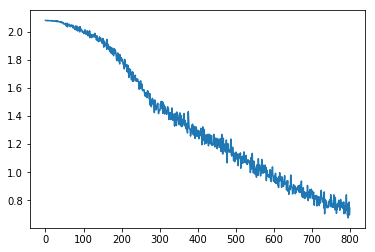

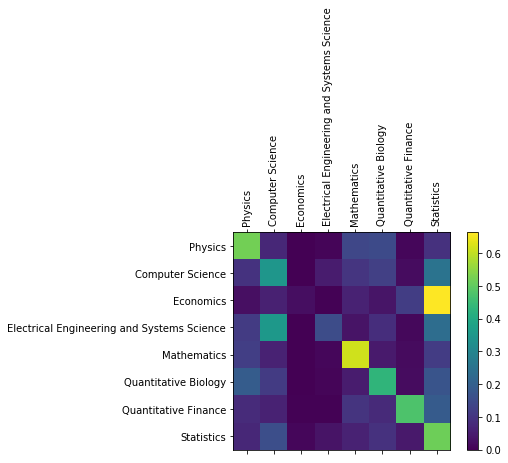

In [0]:
training_percentage = 0.8
training_dict = dict()
testing_dict = dict()
for cat in all_categories:
    all_articles = articles_dict[cat]
    shuffle(all_articles)
    p = int(len(all_articles)*training_percentage)
    training_dict[cat] = all_articles[:p]
    testing_dict[cat] = all_articles[p+1:]

learning_rate = 0.001

n_batch_iters = 40000
batch_size = 20
print_every = 100
plot_every = 50

# keep track of losses for plotting
current_loss = 0
all_losses = []

use_characters = 300
print_statistics(use_characters)

model = CNN_model(use_characters, n_letters, n_categories).cuda()
criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(model.parameters(), lr = learning_rate, momentum = 0.9)

start = time.time()

for it in range(1, n_batch_iters+1):
    batch = torch.zeros((batch_size, 1, use_characters, n_letters)).cuda()
    out_batch = torch.zeros(batch_size, dtype=torch.long).cuda()
    optimizer.zero_grad()
    bi = 0
    while bi < batch_size:
        category, abstract, category_tensor, abstract_tensor = randomCNNTrainingExample(use_characters)
        if len(abstract) < use_characters:
            continue
        batch[bi, :, :, :] = abstract_tensor
        out_batch[bi] = category_tensor
        bi += 1
            
    output = model(batch)
    loss = criterion(output, out_batch)
    loss.backward()
    current_loss += loss.item()
    optimizer.step()
    
    if not (it % print_every):
        guess, guess_i = categoryFromOutput(output)
        correct = "V" if guess == category else "X {}".format(category)
        print("{} {}% ({}) {:.4} / {} {}".format(it, round(it/n_batch_iters*100, 2), timeSince(start), loss, guess, correct))
        
    if not (it % plot_every):
        all_losses.append(current_loss / plot_every)
        current_loss = 0
        
plot_losses(all_losses)

confusion = torch.zeros(n_categories, n_categories)
n_confusion = 10000

# Go through a bunch of examples and record which are correctly guessed
for i in range(n_confusion):
    if 0 == i%(n_confusion//10):
        print(i)
    line = ""
    while len(line) < use_characters:
        category, line, category_tensor, line_tensor = randomCNNTestingExample(use_characters)
    output = model(line_tensor.unsqueeze_(0))
    guess, guess_i = categoryFromOutput(output)
    category_i = all_categories.index(category)
    confusion[category_i][guess_i] += 1

# Normalize by dividing every row by its sum
for i in range(n_categories):
    confusion[i] = confusion[i] / confusion[i].sum()

import matplotlib.ticker as ticker
    
# Set up plot
fig = plt.figure()
ax = fig.add_subplot(111)
cax = ax.matshow(confusion.numpy())
fig.colorbar(cax)

# Set up axes
ax.set_xticklabels([''] + all_categories, rotation=90)
ax.set_yticklabels([''] + all_categories)

# Force label at every tick
ax.xaxis.set_major_locator(ticker.MultipleLocator(1))
ax.yaxis.set_major_locator(ticker.MultipleLocator(1))

# sphinx_gallery_thumbnail_number = 2
plt.show()

## Get the training samples weighted according to frequency

With regards to abstracts of length at least 300,
	202723 abstracts for Physics
	140984 abstracts for Computer Science
	   669 abstracts for Economics
	  6266 abstracts for Electrical Engineering and Systems Science
	136506 abstracts for Mathematics
	 25498 abstracts for Quantitative Biology
	 11504 abstracts for Quantitative Finance
	 21839 abstracts for Statistics
100 0.25% (0.0m 17.800299882888794s) 2.08 / Quantitative Finance X Mathematics
200 0.5% (0.0m 35.660526514053345s) 2.076 / Physics X Mathematics
300 0.75% (0.0m 53.60610866546631s) 2.081 / Economics X Physics
400 1.0% (1.0m 11.449572801589966s) 2.057 / Quantitative Biology X Economics
500 1.25% (1.0m 29.374331951141357s) 2.079 / Quantitative Biology X Statistics
600 1.5% (1.0m 47.27017116546631s) 2.102 / Quantitative Biology X Electrical Engineering and Systems Science
700 1.75% (2.0m 5.191289663314819s) 2.08 / Economics X Quantitative Biology
800 2.0% (2.0m 23.133395195007324s) 2.074 / Economics X Quantitative Finance
900 

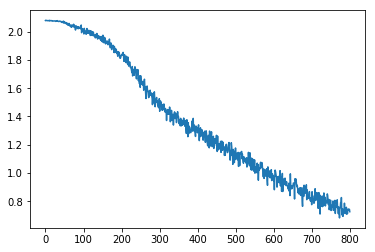

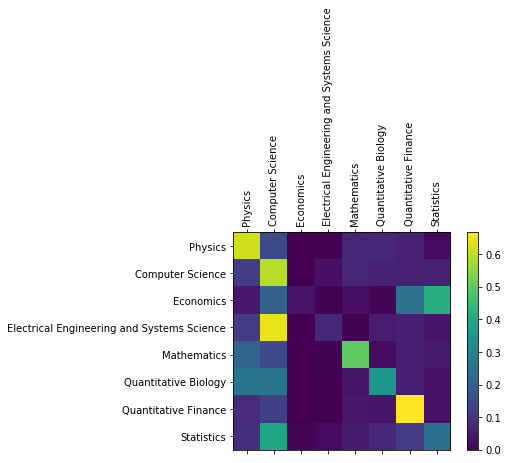

tensor([[61., 15.,  0.,  0.,  6.,  7.,  6.,  1.],
        [12., 59.,  0.,  2.,  7.,  6.,  6.,  6.],
        [ 4., 20.,  3.,  0.,  2.,  0., 25., 41.],
        [11., 64.,  0.,  7.,  0.,  5.,  5.,  4.],
        [21., 14.,  0.,  0., 50.,  2.,  5.,  4.],
        [26., 25.,  0.,  0.,  3., 34.,  5.,  3.],
        [ 8., 12.,  0.,  0.,  4.,  3., 66.,  3.],
        [ 8., 39.,  1.,  1.,  4.,  7., 11., 24.]])


In [0]:
training_percentage = 0.8
training_dict = dict()
testing_dict = dict()
for cat in all_categories:
    all_articles = articles_dict[cat]
    shuffle(all_articles)
    p = int(len(all_articles)*training_percentage)
    training_dict[cat] = all_articles[:p]
    testing_dict[cat] = all_articles[p+1:]

learning_rate = 0.001

n_batch_iters =  40000
batch_size = 20
print_every = 100
plot_every = 50

# keep track of losses for plotting
current_loss = 0
all_losses = []

use_characters = 300
print_statistics(use_characters)

model = CNN_model(use_characters, n_letters, n_categories).cuda()
criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(model.parameters(), lr = learning_rate, momentum = 0.9)

start = time.time()

for it in range(1, n_batch_iters+1):
    batch = torch.zeros((batch_size, 1, use_characters, n_letters)).cuda()
    out_batch = torch.zeros(batch_size, dtype=torch.long).cuda()
    optimizer.zero_grad()
    bi = 0
    while bi < batch_size:
        category, abstract, category_tensor, abstract_tensor = randomCNNTrainingExample(use_characters)
        if len(abstract) < use_characters:
            continue
        batch[bi, :, :, :] = abstract_tensor
        out_batch[bi] = category_tensor
        bi += 1
            
    output = model(batch)
    loss = criterion(output, out_batch)
    loss.backward()
    current_loss += loss.item()
    optimizer.step()
    
    if not (it % print_every):
        guess, guess_i = categoryFromOutput(output)
        correct = "V" if guess == category else "X {}".format(category)
        print("{} {}% ({}) {:.4} / {} {}".format(it, round(it/n_batch_iters*100, 2), timeSince(start), loss, guess, correct))
        
    if not (it % plot_every):
        all_losses.append(current_loss / plot_every)
        current_loss = 0
        
plot_losses(all_losses)

rights = 0
wrongs = 0
with torch.no_grad():
  for cat in all_categories:
      for article in testing_dict[cat]:
          if len(article["abstract"]) < use_characters:
              continue
          abstract_tensor = lineToCNNTensor(article["abstract"][:use_characters]).unsqueeze_(0).cuda()
          cat_i = all_categories.index(cat)
          category_tensor = torch.tensor([cat_i], dtype=torch.long).cuda()
          output = model(abstract_tensor)
          guess, guess_i = categoryFromOutput(output)
          if guess_i == cat_i:
              rights += 1
          else:
              wrongs += 1
print("{} accuracy out of {} tests".format(round(rights/(rights+wrongs),2), rights+wrongs))

confusion = torch.zeros(n_categories, n_categories)
n_confusion = 10000

# Go through a bunch of examples and record which are correctly guessed
for i in range(n_confusion):
    if 0 == i%(n_confusion//10):
        print(i)
    line = ""
    while len(line) < use_characters:
        category, line, category_tensor, line_tensor = randomCNNTestingExample(use_characters)
    output = model(line_tensor.unsqueeze_(0))
    guess, guess_i = categoryFromOutput(output)
    category_i = all_categories.index(category)
    confusion[category_i][guess_i] += 1

# Normalize by dividing every row by its sum
for i in range(n_categories):
    confusion[i] = confusion[i] / confusion[i].sum()

import matplotlib.ticker as ticker
    
# Set up plot
fig = plt.figure()
ax = fig.add_subplot(111)
cax = ax.matshow(confusion.numpy())
fig.colorbar(cax)

# Set up axes
ax.set_xticklabels([''] + all_categories, rotation=90)
ax.set_yticklabels([''] + all_categories)

# Force label at every tick
ax.xaxis.set_major_locator(ticker.MultipleLocator(1))
ax.yaxis.set_major_locator(ticker.MultipleLocator(1))

# sphinx_gallery_thumbnail_number = 2
plt.show()

print(confusion*1000//10)

## Train for longer, increase training proportion to 90%

With regards to abstracts of length at least 300,
	202723 abstracts for Physics
	140984 abstracts for Computer Science
	   669 abstracts for Economics
	  6266 abstracts for Electrical Engineering and Systems Science
	136506 abstracts for Mathematics
	 25498 abstracts for Quantitative Biology
	 11504 abstracts for Quantitative Finance
	 21839 abstracts for Statistics
100 0.2% (0.0m 18.25719690322876s) 2.089 / Statistics X Mathematics
200 0.4% (0.0m 36.639222145080566s) 2.061 / Statistics X Electrical Engineering and Systems Science
300 0.6% (0.0m 54.913896322250366s) 2.085 / Statistics X Computer Science
400 0.8% (1.0m 13.327813625335693s) 2.076 / Statistics X Electrical Engineering and Systems Science
500 1.0% (1.0m 31.63040280342102s) 2.078 / Statistics X Quantitative Biology
600 1.2% (1.0m 50.04396033287048s) 2.073 / Computer Science X Statistics
700 1.4% (2.0m 8.335230827331543s) 2.087 / Statistics V
800 1.6% (2.0m 26.717973709106445s) 2.1 / Economics X Statistics
900 1.8% (2.0m 45.

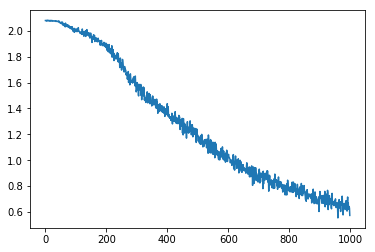

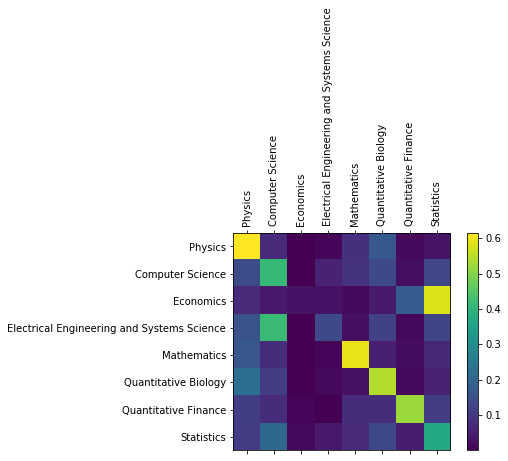

tensor([[61.,  7.,  0.,  1.,  8., 17.,  1.,  3.],
        [14., 41.,  0.,  6.,  8., 13.,  2., 13.],
        [ 7.,  4.,  2.,  2.,  1.,  4., 17., 58.],
        [15., 41.,  0., 13.,  2., 11.,  1., 12.],
        [16.,  8.,  0.,  1., 59.,  5.,  2.,  6.],
        [22., 11.,  0.,  1.,  2., 54.,  1.,  6.],
        [11.,  7.,  1.,  0.,  7.,  8., 52., 11.],
        [10., 20.,  1.,  4.,  7., 13.,  4., 37.]])


In [0]:
training_percentage = 0.9
training_dict = dict()
testing_dict = dict()
for cat in all_categories:
    all_articles = articles_dict[cat]
    shuffle(all_articles)
    p = int(len(all_articles)*training_percentage)
    training_dict[cat] = all_articles[:p]
    testing_dict[cat] = all_articles[p+1:]

learning_rate = 0.001

n_batch_iters = 50000
batch_size = 20
print_every = 100
plot_every = 50

# keep track of losses for plotting
current_loss = 0
all_losses = []

use_characters = 300
print_statistics(use_characters)

model = CNN_model(use_characters, n_letters, n_categories).cuda()
criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(model.parameters(), lr = learning_rate, momentum = 0.9)

start = time.time()

for it in range(1, n_batch_iters+1):
    batch = torch.zeros((batch_size, 1, use_characters, n_letters)).cuda()
    out_batch = torch.zeros(batch_size, dtype=torch.long).cuda()
    optimizer.zero_grad()
    bi = 0
    while bi < batch_size:
        category, abstract, category_tensor, abstract_tensor = randomCNNTrainingExample(use_characters)
        if len(abstract) < use_characters:
            continue
        batch[bi, :, :, :] = abstract_tensor
        out_batch[bi] = category_tensor
        bi += 1
            
    output = model(batch)
    loss = criterion(output, out_batch)
    loss.backward()
    current_loss += loss.item()
    optimizer.step()
    
    if not (it % print_every):
        guess, guess_i = categoryFromOutput(output)
        correct = "V" if guess == category else "X {}".format(category)
        print("{} {}% ({}) {:.4} / {} {}".format(it, round(it/n_batch_iters*100, 2), timeSince(start), loss, guess, correct))
        
    if not (it % plot_every):
        all_losses.append(current_loss / plot_every)
        current_loss = 0
        
plot_losses(all_losses)

rights = 0
wrongs = 0
confusion = torch.zeros(n_categories, n_categories)
with torch.no_grad():
  for cat in all_categories:
      for article in testing_dict[cat]:
          if len(article["abstract"]) < use_characters:
              continue
          abstract_tensor = lineToCNNTensor(article["abstract"][:use_characters]).unsqueeze_(0).cuda()
          cat_i = all_categories.index(cat)
          category_tensor = torch.tensor([cat_i], dtype=torch.long).cuda()
          output = model(abstract_tensor)
          guess, guess_i = categoryFromOutput(output)
          if guess_i == cat_i:
              rights += 1
          else:
              wrongs += 1
          confusion[cat_i][guess_i] += 1
print("{} accuracy out of {} tests".format(round(rights/(rights+wrongs),2), rights+wrongs))


# Normalize by dividing every row by its sum
for i in range(n_categories):
    confusion[i] = confusion[i] / confusion[i].sum()

import matplotlib.ticker as ticker
    
# Set up plot
fig = plt.figure()
ax = fig.add_subplot(111)
cax = ax.matshow(confusion.numpy())
fig.colorbar(cax)

# Set up axes
ax.set_xticklabels([''] + all_categories, rotation=90)
ax.set_yticklabels([''] + all_categories)

# Force label at every tick
ax.xaxis.set_major_locator(ticker.MultipleLocator(1))
ax.yaxis.set_major_locator(ticker.MultipleLocator(1))

# sphinx_gallery_thumbnail_number = 2
plt.show()

print(confusion*1000//10)

## Train for $50\%$ moar time

With regards to abstracts of length at least 300,
	202723 abstracts for Physics
	140984 abstracts for Computer Science
	   669 abstracts for Economics
	  6266 abstracts for Electrical Engineering and Systems Science
	136506 abstracts for Mathematics
	 25498 abstracts for Quantitative Biology
	 11504 abstracts for Quantitative Finance
	 21839 abstracts for Statistics
100 0.13% (0.0m 10.906458616256714s) 2.077 / Computer Science X Statistics
200 0.27% (0.0m 21.750685691833496s) 2.093 / Quantitative Finance X Physics
300 0.4% (0.0m 32.56049203872681s) 2.08 / Economics X Mathematics
400 0.53% (0.0m 43.431915044784546s) 2.096 / Quantitative Finance X Statistics
500 0.67% (0.0m 54.27812314033508s) 2.089 / Quantitative Finance X Computer Science
600 0.8% (1.0m 5.001232624053955s) 2.068 / Electrical Engineering and Systems Science X Quantitative Biology
700 0.93% (1.0m 15.810288906097412s) 2.081 / Computer Science X Statistics
800 1.07% (1.0m 26.538745880126953s) 2.076 / Economics X Quantitati

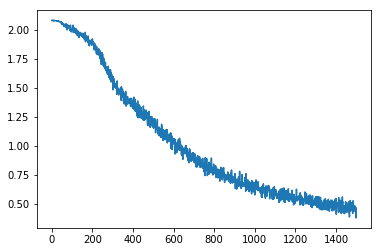

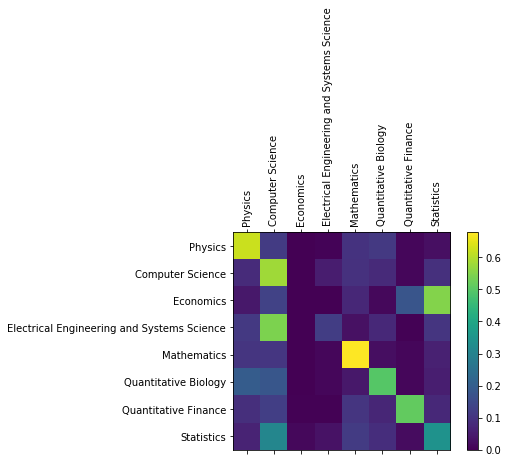

tensor([[62., 11.,  0.,  0.,  9., 11.,  1.,  2.],
        [ 8., 58.,  0.,  5.,  9.,  8.,  1.,  9.],
        [ 4., 13.,  0.,  0.,  7.,  1., 17., 55.],
        [11., 54.,  0., 12.,  3.,  7.,  0., 10.],
        [10., 10.,  0.,  1., 67.,  2.,  1.,  6.],
        [19., 18.,  0.,  1.,  4., 49.,  1.,  5.],
        [ 9., 12.,  0.,  0., 10.,  7., 51.,  7.],
        [ 6., 31.,  1.,  3., 11.,  8.,  2., 34.]])


In [0]:
training_percentage = 0.9
training_dict = dict()
testing_dict = dict()
for cat in all_categories:
    all_articles = articles_dict[cat]
    shuffle(all_articles)
    p = int(len(all_articles)*training_percentage)
    training_dict[cat] = all_articles[:p]
    testing_dict[cat] = all_articles[p+1:]

learning_rate = 0.001

n_batch_iters = 75000
batch_size = 20
print_every = 100
plot_every = 50

# keep track of losses for plotting
current_loss = 0
all_losses = []

use_characters = 300
print_statistics(use_characters)

model = CNN_model(use_characters, n_letters, n_categories).cuda()
criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(model.parameters(), lr = learning_rate, momentum = 0.9)

start = time.time()

for it in range(1, n_batch_iters+1):
    batch = torch.zeros((batch_size, 1, use_characters, n_letters)).cuda()
    out_batch = torch.zeros(batch_size, dtype=torch.long).cuda()
    optimizer.zero_grad()
    bi = 0
    while bi < batch_size:
        category, abstract, category_tensor, abstract_tensor = randomCNNTrainingExample(use_characters)
        if len(abstract) < use_characters:
            continue
        batch[bi, :, :, :] = abstract_tensor
        out_batch[bi] = category_tensor
        bi += 1
            
    output = model(batch)
    loss = criterion(output, out_batch)
    loss.backward()
    current_loss += loss.item()
    optimizer.step()
    
    if not (it % print_every):
        guess, guess_i = categoryFromOutput(output)
        correct = "V" if guess == category else "X {}".format(category)
        print("{} {}% ({}) {:.4} / {} {}".format(it, round(it/n_batch_iters*100, 2), timeSince(start), loss, guess, correct))
        
    if not (it % plot_every):
        all_losses.append(current_loss / plot_every)
        current_loss = 0
        
plot_losses(all_losses)

rights = 0
wrongs = 0
confusion = torch.zeros(n_categories, n_categories)
with torch.no_grad():
  for cat in all_categories:
      for article in testing_dict[cat]:
          if len(article["abstract"]) < use_characters:
              continue
          abstract_tensor = lineToCNNTensor(article["abstract"][:use_characters]).unsqueeze_(0).cuda()
          cat_i = all_categories.index(cat)
          category_tensor = torch.tensor([cat_i], dtype=torch.long).cuda()
          output = model(abstract_tensor)
          guess, guess_i = categoryFromOutput(output)
          if guess_i == cat_i:
              rights += 1
          else:
              wrongs += 1
          confusion[cat_i][guess_i] += 1
print("{} accuracy out of {} tests".format(round(rights/(rights+wrongs),2), rights+wrongs))


# Normalize by dividing every row by its sum
for i in range(n_categories):
    confusion[i] = confusion[i] / confusion[i].sum()

import matplotlib.ticker as ticker
    
# Set up plot
fig = plt.figure()
ax = fig.add_subplot(111)
cax = ax.matshow(confusion.numpy())
fig.colorbar(cax)

# Set up axes
ax.set_xticklabels([''] + all_categories, rotation=90)
ax.set_yticklabels([''] + all_categories)

# Force label at every tick
ax.xaxis.set_major_locator(ticker.MultipleLocator(1))
ax.yaxis.set_major_locator(ticker.MultipleLocator(1))

# sphinx_gallery_thumbnail_number = 2
plt.show()

print(confusion*1000//10)

## Slightly bigger batches

With regards to abstracts of length at least 300,
	202723 abstracts for Physics
	140984 abstracts for Computer Science
	   669 abstracts for Economics
	  6266 abstracts for Electrical Engineering and Systems Science
	136506 abstracts for Mathematics
	 25498 abstracts for Quantitative Biology
	 11504 abstracts for Quantitative Finance
	 21839 abstracts for Statistics
100 0.13% (0.0m 12.855336904525757s) 2.083 / Electrical Engineering and Systems Science V
200 0.27% (0.0m 25.681421518325806s) 2.094 / Electrical Engineering and Systems Science V
300 0.4% (0.0m 38.427767753601074s) 2.063 / Economics X Statistics
400 0.53% (0.0m 51.12583041191101s) 2.066 / Economics X Electrical Engineering and Systems Science
500 0.67% (1.0m 3.8059017658233643s) 2.071 / Physics X Computer Science
600 0.8% (1.0m 16.523826122283936s) 2.09 / Statistics X Physics
700 0.93% (1.0m 29.248534679412842s) 2.076 / Electrical Engineering and Systems Science X Mathematics
800 1.07% (1.0m 41.904825925827026s) 2.078 / St

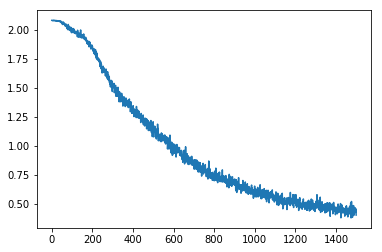

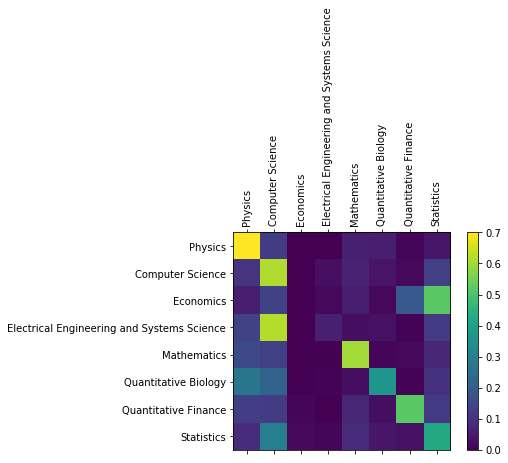

tensor([[70., 12.,  0.,  0.,  6.,  5.,  1.,  4.],
        [10., 61.,  0.,  2.,  6.,  3.,  1., 13.],
        [ 5., 13.,  0.,  1.,  5.,  1., 19., 52.],
        [13., 61.,  0.,  6.,  2.,  3.,  0., 11.],
        [15., 13.,  0.,  0., 60.,  1.,  1.,  7.],
        [27., 22.,  0.,  0.,  2., 36.,  0., 10.],
        [12., 12.,  0.,  0.,  7.,  2., 52., 12.],
        [ 8., 30.,  1.,  1.,  8.,  4.,  3., 42.]])


In [0]:
training_percentage = 0.9
training_dict = dict()
testing_dict = dict()
for cat in all_categories:
    all_articles = articles_dict[cat]
    shuffle(all_articles)
    p = int(len(all_articles)*training_percentage)
    training_dict[cat] = all_articles[:p]
    testing_dict[cat] = all_articles[p+1:]

learning_rate = 0.001

n_batch_iters = 75000
batch_size = 25
print_every = 100
plot_every = 50

# keep track of losses for plotting
current_loss = 0
all_losses = []

use_characters = 300
print_statistics(use_characters)

model = CNN_model(use_characters, n_letters, n_categories).cuda()
criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(model.parameters(), lr = learning_rate, momentum = 0.9)

start = time.time()

for it in range(1, n_batch_iters+1):
    batch = torch.zeros((batch_size, 1, use_characters, n_letters)).cuda()
    out_batch = torch.zeros(batch_size, dtype=torch.long).cuda()
    optimizer.zero_grad()
    bi = 0
    while bi < batch_size:
        category, abstract, category_tensor, abstract_tensor = randomCNNTrainingExample(use_characters)
        if len(abstract) < use_characters:
            continue
        batch[bi, :, :, :] = abstract_tensor
        out_batch[bi] = category_tensor
        bi += 1
            
    output = model(batch)
    loss = criterion(output, out_batch)
    loss.backward()
    current_loss += loss.item()
    optimizer.step()
    
    if not (it % print_every):
        guess, guess_i = categoryFromOutput(output)
        correct = "V" if guess == category else "X {}".format(category)
        print("{} {}% ({}) {:.4} / {} {}".format(it, round(it/n_batch_iters*100, 2), timeSince(start), loss, guess, correct))
        
    if not (it % plot_every):
        all_losses.append(current_loss / plot_every)
        current_loss = 0
        
plot_losses(all_losses)

rights = 0
wrongs = 0
confusion = torch.zeros(n_categories, n_categories)
with torch.no_grad():
  for cat in all_categories:
      for article in testing_dict[cat]:
          if len(article["abstract"]) < use_characters:
              continue
          abstract_tensor = lineToCNNTensor(article["abstract"][:use_characters]).unsqueeze_(0).cuda()
          cat_i = all_categories.index(cat)
          category_tensor = torch.tensor([cat_i], dtype=torch.long).cuda()
          output = model(abstract_tensor)
          guess, guess_i = categoryFromOutput(output)
          if guess_i == cat_i:
              rights += 1
          else:
              wrongs += 1
          confusion[cat_i][guess_i] += 1
print("{} accuracy out of {} tests".format(round(rights/(rights+wrongs),2), rights+wrongs))


# Normalize by dividing every row by its sum
for i in range(n_categories):
    confusion[i] = confusion[i] / confusion[i].sum()

import matplotlib.ticker as ticker
    
# Set up plot
fig = plt.figure()
ax = fig.add_subplot(111)
cax = ax.matshow(confusion.numpy())
fig.colorbar(cax)

# Set up axes
ax.set_xticklabels([''] + all_categories, rotation=90)
ax.set_yticklabels([''] + all_categories)

# Force label at every tick
ax.xaxis.set_major_locator(ticker.MultipleLocator(1))
ax.yaxis.set_major_locator(ticker.MultipleLocator(1))

# sphinx_gallery_thumbnail_number = 2
plt.show()

print(confusion*1000//10)

## Fall back to 140 characters for tweet length

With regards to abstracts of length at least 140,
	206044 abstracts for Physics
	143111 abstracts for Computer Science
	   671 abstracts for Economics
	  6318 abstracts for Electrical Engineering and Systems Science
	153542 abstracts for Mathematics
	 25718 abstracts for Quantitative Biology
	 11787 abstracts for Quantitative Finance
	 22070 abstracts for Statistics
100 0.13% (0.0m 5.730035781860352s) 2.082 / Physics X Quantitative Finance
200 0.27% (0.0m 11.378763914108276s) 2.079 / Economics X Quantitative Biology
300 0.4% (0.0m 16.999258756637573s) 2.079 / Quantitative Biology X Electrical Engineering and Systems Science
400 0.53% (0.0m 22.662580728530884s) 2.078 / Quantitative Biology X Mathematics
500 0.67% (0.0m 28.30778455734253s) 2.074 / Physics X Quantitative Finance
600 0.8% (0.0m 33.96341633796692s) 2.081 / Physics X Electrical Engineering and Systems Science
700 0.93% (0.0m 39.61360001564026s) 2.078 / Computer Science X Quantitative Biology
800 1.07% (0.0m 45.28399682044983

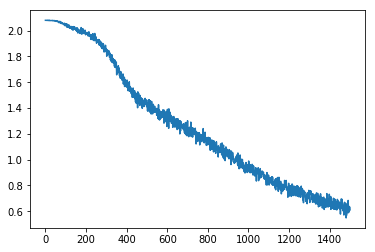

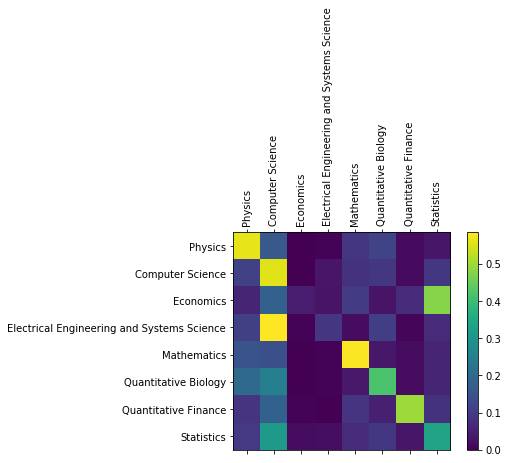

tensor([[56., 16.,  0.,  0.,  9., 12.,  1.,  3.],
        [11., 55.,  0.,  3.,  8.,  9.,  1.,  9.],
        [ 5., 17.,  4.,  2., 10.,  2.,  7., 47.],
        [11., 58.,  0.,  9.,  1., 10.,  0.,  6.],
        [15., 14.,  0.,  0., 58.,  3.,  1.,  5.],
        [20., 25.,  0.,  0.,  4., 41.,  2.,  6.],
        [ 8., 18.,  0.,  0.,  8.,  5., 49.,  8.],
        [ 9., 31.,  2.,  2.,  7.,  9.,  3., 34.]])


In [0]:
training_percentage = 0.9
training_dict = dict()
testing_dict = dict()
for cat in all_categories:
    all_articles = articles_dict[cat]
    shuffle(all_articles)
    p = int(len(all_articles)*training_percentage)
    training_dict[cat] = all_articles[:p]
    testing_dict[cat] = all_articles[p+1:]

learning_rate = 0.001

n_batch_iters = 75000
batch_size = 25
print_every = 100
plot_every = 50

# keep track of losses for plotting
current_loss = 0
all_losses = []

use_characters = 140
print_statistics(use_characters)

model = CNN_model(use_characters, n_letters, n_categories).cuda()
criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(model.parameters(), lr = learning_rate, momentum = 0.9)

start = time.time()

for it in range(1, n_batch_iters+1):
    batch = torch.zeros((batch_size, 1, use_characters, n_letters)).cuda()
    out_batch = torch.zeros(batch_size, dtype=torch.long).cuda()
    optimizer.zero_grad()
    bi = 0
    while bi < batch_size:
        category, abstract, category_tensor, abstract_tensor = randomCNNTrainingExample(use_characters)
        if len(abstract) < use_characters:
            continue
        batch[bi, :, :, :] = abstract_tensor
        out_batch[bi] = category_tensor
        bi += 1
            
    output = model(batch)
    loss = criterion(output, out_batch)
    loss.backward()
    current_loss += loss.item()
    optimizer.step()
    
    if not (it % print_every):
        guess, guess_i = categoryFromOutput(output)
        correct = "V" if guess == category else "X {}".format(category)
        print("{} {}% ({}) {:.4} / {} {}".format(it, round(it/n_batch_iters*100, 2), timeSince(start), loss, guess, correct))
        
    if not (it % plot_every):
        all_losses.append(current_loss / plot_every)
        current_loss = 0
        
plot_losses(all_losses)

rights = 0
wrongs = 0
confusion = torch.zeros(n_categories, n_categories)
with torch.no_grad():
  for cat in all_categories:
      for article in testing_dict[cat]:
          if len(article["abstract"]) < use_characters:
              continue
          abstract_tensor = lineToCNNTensor(article["abstract"][:use_characters]).unsqueeze_(0).cuda()
          cat_i = all_categories.index(cat)
          category_tensor = torch.tensor([cat_i], dtype=torch.long).cuda()
          output = model(abstract_tensor)
          guess, guess_i = categoryFromOutput(output)
          if guess_i == cat_i:
              rights += 1
          else:
              wrongs += 1
          confusion[cat_i][guess_i] += 1
print("{} accuracy out of {} tests".format(round(rights/(rights+wrongs),2), rights+wrongs))


# Normalize by dividing every row by its sum
for i in range(n_categories):
    confusion[i] = confusion[i] / confusion[i].sum()

import matplotlib.ticker as ticker
    
# Set up plot
fig = plt.figure()
ax = fig.add_subplot(111)
cax = ax.matshow(confusion.numpy())
fig.colorbar(cax)

# Set up axes
ax.set_xticklabels([''] + all_categories, rotation=90)
ax.set_yticklabels([''] + all_categories)

# Force label at every tick
ax.xaxis.set_major_locator(ticker.MultipleLocator(1))
ax.yaxis.set_major_locator(ticker.MultipleLocator(1))

# sphinx_gallery_thumbnail_number = 2
plt.show()

print(confusion*1000//10)

## Increase training step (x3)

With regards to abstracts of length at least 140,
	206044 abstracts for Physics
	143111 abstracts for Computer Science
	   671 abstracts for Economics
	  6318 abstracts for Electrical Engineering and Systems Science
	153542 abstracts for Mathematics
	 25718 abstracts for Quantitative Biology
	 11787 abstracts for Quantitative Finance
	 22070 abstracts for Statistics
100 0.13% (0.0m 5.659548759460449s) 2.079 / Physics X Economics
200 0.27% (0.0m 11.362447500228882s) 2.082 / Quantitative Biology X Physics
300 0.4% (0.0m 17.063783645629883s) 2.079 / Physics X Mathematics
400 0.53% (0.0m 22.75456404685974s) 2.082 / Electrical Engineering and Systems Science X Mathematics
500 0.67% (0.0m 28.430838346481323s) 2.074 / Electrical Engineering and Systems Science X Quantitative Biology
600 0.8% (0.0m 34.05709099769592s) 2.073 / Electrical Engineering and Systems Science V
700 0.93% (0.0m 39.6945481300354s) 2.077 / Computer Science X Economics
800 1.07% (0.0m 45.333425521850586s) 2.088 / Quantita

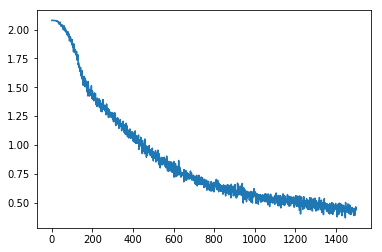

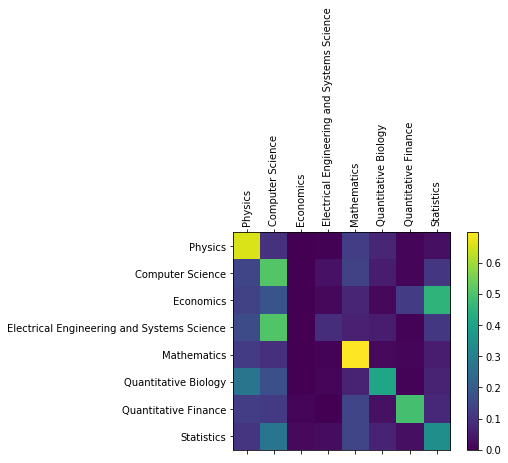

tensor([[65.,  9.,  0.,  0., 12.,  7.,  0.,  2.],
        [14., 51.,  0.,  3., 13.,  5.,  1., 10.],
        [13., 18.,  0.,  1.,  7.,  1., 12., 45.],
        [16., 50.,  0.,  9.,  6.,  5.,  0., 11.],
        [12.,  9.,  0.,  0., 69.,  1.,  0.,  5.],
        [27., 17.,  0.,  0.,  6., 40.,  0.,  6.],
        [12., 11.,  0.,  0., 14.,  3., 49.,  7.],
        [10., 26.,  1.,  2., 14.,  6.,  2., 34.]])


In [0]:
training_percentage = 0.9
training_dict = dict()
testing_dict = dict()
for cat in all_categories:
    all_articles = articles_dict[cat]
    shuffle(all_articles)
    p = int(len(all_articles)*training_percentage)
    training_dict[cat] = all_articles[:p]
    testing_dict[cat] = all_articles[p+1:]

learning_rate = 0.003

n_batch_iters = 75000
batch_size = 25
print_every = 100
plot_every = 50

# keep track of losses for plotting
current_loss = 0
all_losses = []

use_characters = 140
print_statistics(use_characters)

model = CNN_model(use_characters, n_letters, n_categories).cuda()
criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(model.parameters(), lr = learning_rate, momentum = 0.9)

start = time.time()

for it in range(1, n_batch_iters+1):
    batch = torch.zeros((batch_size, 1, use_characters, n_letters)).cuda()
    out_batch = torch.zeros(batch_size, dtype=torch.long).cuda()
    optimizer.zero_grad()
    bi = 0
    while bi < batch_size:
        category, abstract, category_tensor, abstract_tensor = randomCNNTrainingExample(use_characters)
        if len(abstract) < use_characters:
            continue
        batch[bi, :, :, :] = abstract_tensor
        out_batch[bi] = category_tensor
        bi += 1
            
    output = model(batch)
    loss = criterion(output, out_batch)
    loss.backward()
    current_loss += loss.item()
    optimizer.step()
    
    if not (it % print_every):
        guess, guess_i = categoryFromOutput(output)
        correct = "V" if guess == category else "X {}".format(category)
        print("{} {}% ({}) {:.4} / {} {}".format(it, round(it/n_batch_iters*100, 2), timeSince(start), loss, guess, correct))
        
    if not (it % plot_every):
        all_losses.append(current_loss / plot_every)
        current_loss = 0
        
plot_losses(all_losses)

rights = 0
wrongs = 0
confusion = torch.zeros(n_categories, n_categories)
with torch.no_grad():
  for cat in all_categories:
      for article in testing_dict[cat]:
          if len(article["abstract"]) < use_characters:
              continue
          abstract_tensor = lineToCNNTensor(article["abstract"][:use_characters]).unsqueeze_(0).cuda()
          cat_i = all_categories.index(cat)
          category_tensor = torch.tensor([cat_i], dtype=torch.long).cuda()
          output = model(abstract_tensor)
          guess, guess_i = categoryFromOutput(output)
          if guess_i == cat_i:
              rights += 1
          else:
              wrongs += 1
          confusion[cat_i][guess_i] += 1
print("{} accuracy out of {} tests".format(round(rights/(rights+wrongs),2), rights+wrongs))


# Normalize by dividing every row by its sum
for i in range(n_categories):
    confusion[i] = confusion[i] / confusion[i].sum()

import matplotlib.ticker as ticker
    
# Set up plot
fig = plt.figure()
ax = fig.add_subplot(111)
cax = ax.matshow(confusion.numpy())
fig.colorbar(cax)

# Set up axes
ax.set_xticklabels([''] + all_categories, rotation=90)
ax.set_yticklabels([''] + all_categories)

# Force label at every tick
ax.xaxis.set_major_locator(ticker.MultipleLocator(1))
ax.yaxis.set_major_locator(ticker.MultipleLocator(1))

# sphinx_gallery_thumbnail_number = 2
plt.show()

print(confusion*1000//10)

## Increase training step again to 0.005 (62%)

With regards to abstracts of length at least 140,
	206044 abstracts for Physics
	143111 abstracts for Computer Science
	   671 abstracts for Economics
	  6318 abstracts for Electrical Engineering and Systems Science
	153542 abstracts for Mathematics
	 25718 abstracts for Quantitative Biology
	 11787 abstracts for Quantitative Finance
	 22070 abstracts for Statistics
100 0.13% (0.0m 8.134866714477539s) 2.094 / Electrical Engineering and Systems Science X Statistics
200 0.27% (0.0m 16.17481780052185s) 2.077 / Quantitative Finance X Economics
300 0.4% (0.0m 24.402159690856934s) 2.085 / Electrical Engineering and Systems Science X Economics
400 0.53% (0.0m 32.57212972640991s) 2.068 / Quantitative Biology V
500 0.67% (0.0m 40.782270193099976s) 2.078 / Physics V
600 0.8% (0.0m 48.93305540084839s) 2.073 / Economics X Physics
700 0.93% (0.0m 57.04762077331543s) 2.08 / Mathematics X Statistics
800 1.07% (1.0m 5.1768810749053955s) 2.076 / Quantitative Biology X Statistics
900 1.2% (1.0m 13.30801

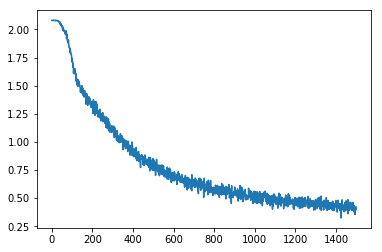

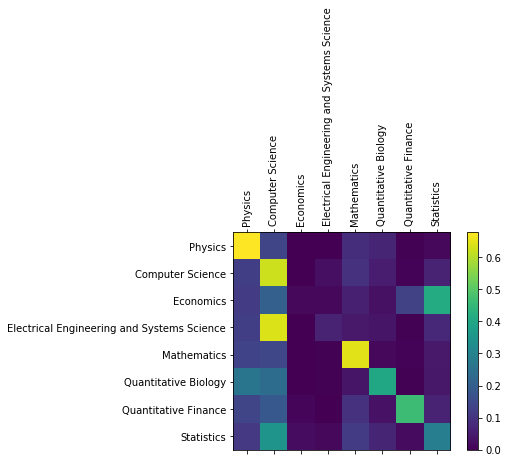

tensor([[67., 14.,  0.,  0.,  8.,  6.,  0.,  1.],
        [12., 62.,  0.,  2.,  9.,  5.,  0.,  6.],
        [11., 20.,  1.,  1.,  5.,  2., 13., 41.],
        [12., 64.,  0.,  6.,  4.,  3.,  0.,  7.],
        [13., 14.,  0.,  0., 64.,  1.,  0.,  4.],
        [26., 23.,  0.,  0.,  3., 40.,  0.,  4.],
        [14., 18.,  0.,  0.,  9.,  3., 46.,  6.],
        [11., 34.,  2.,  1., 12.,  6.,  1., 29.]])


In [0]:
training_percentage = 0.9
training_dict = dict()
testing_dict = dict()
for cat in all_categories:
    all_articles = articles_dict[cat]
    shuffle(all_articles)
    p = int(len(all_articles)*training_percentage)
    training_dict[cat] = all_articles[:p]
    testing_dict[cat] = all_articles[p+1:]

learning_rate = 0.005

n_batch_iters = 75000
batch_size = 25
print_every = 100
plot_every = 50

# keep track of losses for plotting
current_loss = 0
all_losses = []

use_characters = 140
print_statistics(use_characters)

model = CNN_model(use_characters, n_letters, n_categories).cuda()
criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(model.parameters(), lr = learning_rate, momentum = 0.9)

start = time.time()

for it in range(1, n_batch_iters+1):
    batch = torch.zeros((batch_size, 1, use_characters, n_letters)).cuda()
    out_batch = torch.zeros(batch_size, dtype=torch.long).cuda()
    optimizer.zero_grad()
    bi = 0
    while bi < batch_size:
        category, abstract, category_tensor, abstract_tensor = randomCNNTrainingExample(use_characters)
        if len(abstract) < use_characters:
            continue
        batch[bi, :, :, :] = abstract_tensor
        out_batch[bi] = category_tensor
        bi += 1
            
    output = model(batch)
    loss = criterion(output, out_batch)
    loss.backward()
    current_loss += loss.item()
    optimizer.step()
    
    if not (it % print_every):
        guess, guess_i = categoryFromOutput(output)
        correct = "V" if guess == category else "X {}".format(category)
        print("{} {}% ({}) {:.4} / {} {}".format(it, round(it/n_batch_iters*100, 2), timeSince(start), loss, guess, correct))
        
    if not (it % plot_every):
        all_losses.append(current_loss / plot_every)
        current_loss = 0
        
plot_losses(all_losses)

rights = 0
wrongs = 0
confusion = torch.zeros(n_categories, n_categories)
with torch.no_grad():
  for cat in all_categories:
      for article in testing_dict[cat]:
          if len(article["abstract"]) < use_characters:
              continue
          abstract_tensor = lineToCNNTensor(article["abstract"][:use_characters]).unsqueeze_(0).cuda()
          cat_i = all_categories.index(cat)
          category_tensor = torch.tensor([cat_i], dtype=torch.long).cuda()
          output = model(abstract_tensor)
          guess, guess_i = categoryFromOutput(output)
          if guess_i == cat_i:
              rights += 1
          else:
              wrongs += 1
          confusion[cat_i][guess_i] += 1
print("{} accuracy out of {} tests".format(round(rights/(rights+wrongs),2), rights+wrongs))


# Normalize by dividing every row by its sum
for i in range(n_categories):
    confusion[i] = confusion[i] / confusion[i].sum()

import matplotlib.ticker as ticker
    
# Set up plot
fig = plt.figure()
ax = fig.add_subplot(111)
cax = ax.matshow(confusion.numpy())
fig.colorbar(cax)

# Set up axes
ax.set_xticklabels([''] + all_categories, rotation=90)
ax.set_yticklabels([''] + all_categories)

# Force label at every tick
ax.xaxis.set_major_locator(ticker.MultipleLocator(1))
ax.yaxis.set_major_locator(ticker.MultipleLocator(1))

# sphinx_gallery_thumbnail_number = 2
plt.show()

print(confusion*1000//10)

## Increase step to 0.01

With regards to abstracts of length at least 140,
	206044 abstracts for Physics
	143111 abstracts for Computer Science
	   671 abstracts for Economics
	  6318 abstracts for Electrical Engineering and Systems Science
	153542 abstracts for Mathematics
	 25718 abstracts for Quantitative Biology
	 11787 abstracts for Quantitative Finance
	 22070 abstracts for Statistics
100 0.13% (0.0m 16.644957304000854s) 2.08 / Economics X Quantitative Biology
200 0.27% (0.0m 32.9464225769043s) 2.075 / Economics X Mathematics
300 0.4% (0.0m 48.75141167640686s) 2.084 / Computer Science X Statistics
400 0.53% (1.0m 4.416131258010864s) 2.073 / Statistics X Physics
500 0.67% (1.0m 20.24506115913391s) 2.075 / Mathematics V
600 0.8% (1.0m 36.23910903930664s) 2.078 / Quantitative Biology X Quantitative Finance
700 0.93% (1.0m 51.622867584228516s) 2.077 / Economics X Electrical Engineering and Systems Science
800 1.07% (2.0m 7.178958892822266s) 2.076 / Computer Science X Mathematics
900 1.2% (2.0m 22.80904316902

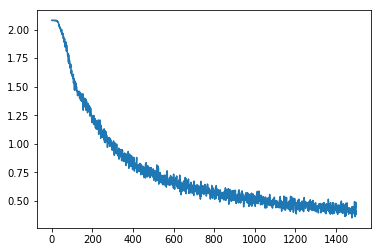

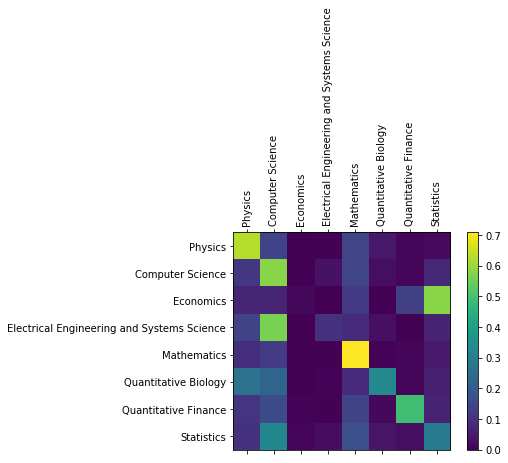

tensor([[62., 14.,  0.,  0., 14.,  4.,  0.,  1.],
        [11., 58.,  0.,  3., 14.,  2.,  1.,  7.],
        [ 7.,  7.,  1.,  0., 11.,  0., 13., 58.],
        [14., 56.,  0.,  9.,  8.,  3.,  0.,  6.],
        [ 9., 12.,  0.,  0., 70.,  0.,  0.,  5.],
        [26., 22.,  0.,  0.,  8., 33.,  1.,  6.],
        [10., 16.,  0.,  0., 14.,  1., 49.,  6.],
        [10., 32.,  1.,  2., 17.,  3.,  2., 29.]])


In [0]:
training_percentage = 0.9
training_dict = dict()
testing_dict = dict()
for cat in all_categories:
    all_articles = articles_dict[cat]
    shuffle(all_articles)
    p = int(len(all_articles)*training_percentage)
    training_dict[cat] = all_articles[:p]
    testing_dict[cat] = all_articles[p+1:]

learning_rate = 0.01

n_batch_iters = 75000
batch_size = 25
print_every = 100
plot_every = 50

# keep track of losses for plotting
current_loss = 0
all_losses = []

use_characters = 140
print_statistics(use_characters)

model = CNN_model(use_characters, n_letters, n_categories).cuda()
criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(model.parameters(), lr = learning_rate, momentum = 0.9)

start = time.time()

for it in range(1, n_batch_iters+1):
    batch = torch.zeros((batch_size, 1, use_characters, n_letters)).cuda()
    out_batch = torch.zeros(batch_size, dtype=torch.long).cuda()
    optimizer.zero_grad()
    bi = 0
    while bi < batch_size:
        category, abstract, category_tensor, abstract_tensor = randomCNNTrainingExample(use_characters)
        if len(abstract) < use_characters:
            continue
        batch[bi, :, :, :] = abstract_tensor
        out_batch[bi] = category_tensor
        bi += 1
            
    output = model(batch)
    loss = criterion(output, out_batch)
    loss.backward()
    current_loss += loss.item()
    optimizer.step()
    
    if not (it % print_every):
        guess, guess_i = categoryFromOutput(output)
        correct = "V" if guess == category else "X {}".format(category)
        print("{} {}% ({}) {:.4} / {} {}".format(it, round(it/n_batch_iters*100, 2), timeSince(start), loss, guess, correct))
        
    if not (it % plot_every):
        all_losses.append(current_loss / plot_every)
        current_loss = 0
        
plot_losses(all_losses)

rights = 0
wrongs = 0
confusion = torch.zeros(n_categories, n_categories)
with torch.no_grad():
  for cat in all_categories:
      for article in testing_dict[cat]:
          if len(article["abstract"]) < use_characters:
              continue
          abstract_tensor = lineToCNNTensor(article["abstract"][:use_characters]).unsqueeze_(0).cuda()
          cat_i = all_categories.index(cat)
          category_tensor = torch.tensor([cat_i], dtype=torch.long).cuda()
          output = model(abstract_tensor)
          guess, guess_i = categoryFromOutput(output)
          if guess_i == cat_i:
              rights += 1
          else:
              wrongs += 1
          confusion[cat_i][guess_i] += 1
print("{} accuracy out of {} tests".format(round(rights/(rights+wrongs),2), rights+wrongs))


# Normalize by dividing every row by its sum
for i in range(n_categories):
    confusion[i] = confusion[i] / confusion[i].sum()

import matplotlib.ticker as ticker
    
# Set up plot
fig = plt.figure()
ax = fig.add_subplot(111)
cax = ax.matshow(confusion.numpy())
fig.colorbar(cax)

# Set up axes
ax.set_xticklabels([''] + all_categories, rotation=90)
ax.set_yticklabels([''] + all_categories)

# Force label at every tick
ax.xaxis.set_major_locator(ticker.MultipleLocator(1))
ax.yaxis.set_major_locator(ticker.MultipleLocator(1))

# sphinx_gallery_thumbnail_number = 2
plt.show()

print(confusion*1000//10)

This was too much already

# LEAKY model

## Model with leakyRelu, train for less time

With regards to abstracts of length at least 140,
	206044 abstracts for Physics
	143111 abstracts for Computer Science
	   671 abstracts for Economics
	  6318 abstracts for Electrical Engineering and Systems Science
	153542 abstracts for Mathematics
	 25718 abstracts for Quantitative Biology
	 11787 abstracts for Quantitative Finance
	 22070 abstracts for Statistics
100 0.2% (0.0m 16.814766883850098s) 2.078 / Mathematics X Computer Science
200 0.4% (0.0m 32.926117181777954s) 2.087 / Economics X Physics
300 0.6% (0.0m 48.744832277297974s) 2.078 / Physics X Electrical Engineering and Systems Science
400 0.8% (1.0m 4.645675182342529s) 2.078 / Quantitative Finance X Quantitative Biology
500 1.0% (1.0m 20.582387447357178s) 2.088 / Physics X Quantitative Finance
600 1.2% (1.0m 36.43371820449829s) 2.087 / Electrical Engineering and Systems Science X Quantitative Biology
700 1.4% (1.0m 52.39704656600952s) 2.094 / Quantitative Finance X Mathematics
800 1.6% (2.0m 8.431377172470093s) 2.077 / Qua

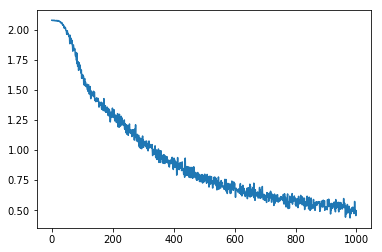

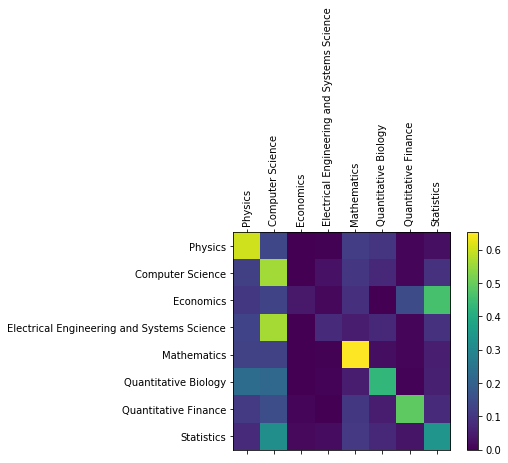

tensor([[60., 13.,  0.,  0., 11., 10.,  0.,  2.],
        [12., 56.,  0.,  3., 10.,  7.,  1.,  9.],
        [10., 13.,  4.,  1.,  8.,  0., 14., 46.],
        [13., 56.,  0.,  8.,  4.,  7.,  0.,  9.],
        [12., 12.,  0.,  0., 65.,  2.,  0.,  5.],
        [23., 21.,  0.,  0.,  5., 43.,  0.,  5.],
        [11., 15.,  0.,  0., 10.,  5., 48.,  7.],
        [ 7., 32.,  1.,  2., 10.,  7.,  3., 34.]])


In [0]:
training_percentage = 0.9
training_dict = dict()
testing_dict = dict()
for cat in all_categories:
    all_articles = articles_dict[cat]
    shuffle(all_articles)
    p = int(len(all_articles)*training_percentage)
    training_dict[cat] = all_articles[:p]
    testing_dict[cat] = all_articles[p+1:]

learning_rate = 0.005

n_batch_iters = 50000
batch_size = 25
print_every = 100
plot_every = 50

# keep track of losses for plotting
current_loss = 0
all_losses = []

use_characters = 140
print_statistics(use_characters)

model = leakyCNN_model(use_characters, n_letters, n_categories).cuda()
criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(model.parameters(), lr = learning_rate, momentum = 0.9)

start = time.time()

for it in range(1, n_batch_iters+1):
    batch = torch.zeros((batch_size, 1, use_characters, n_letters)).cuda()
    out_batch = torch.zeros(batch_size, dtype=torch.long).cuda()
    optimizer.zero_grad()
    bi = 0
    while bi < batch_size:
        category, abstract, category_tensor, abstract_tensor = randomCNNTrainingExample(use_characters)
        if len(abstract) < use_characters:
            continue
        batch[bi, :, :, :] = abstract_tensor
        out_batch[bi] = category_tensor
        bi += 1
            
    output = model(batch)
    loss = criterion(output, out_batch)
    loss.backward()
    current_loss += loss.item()
    optimizer.step()
    
    if not (it % print_every):
        guess, guess_i = categoryFromOutput(output)
        correct = "V" if guess == category else "X {}".format(category)
        print("{} {}% ({}) {:.4} / {} {}".format(it, round(it/n_batch_iters*100, 2), timeSince(start), loss, guess, correct))
        
    if not (it % plot_every):
        all_losses.append(current_loss / plot_every)
        current_loss = 0
        
plot_losses(all_losses)

rights = 0
wrongs = 0
confusion = torch.zeros(n_categories, n_categories)
with torch.no_grad():
  for cat in all_categories:
      for article in testing_dict[cat]:
          if len(article["abstract"]) < use_characters:
              continue
          abstract_tensor = lineToCNNTensor(article["abstract"][:use_characters]).unsqueeze_(0).cuda()
          cat_i = all_categories.index(cat)
          category_tensor = torch.tensor([cat_i], dtype=torch.long).cuda()
          output = model(abstract_tensor)
          guess, guess_i = categoryFromOutput(output)
          if guess_i == cat_i:
              rights += 1
          else:
              wrongs += 1
          confusion[cat_i][guess_i] += 1
print("{} accuracy out of {} tests".format(round(rights/(rights+wrongs),2), rights+wrongs))


# Normalize by dividing every row by its sum
for i in range(n_categories):
    confusion[i] = confusion[i] / confusion[i].sum()

import matplotlib.ticker as ticker
    
# Set up plot
fig = plt.figure()
ax = fig.add_subplot(111)
cax = ax.matshow(confusion.numpy())
fig.colorbar(cax)

# Set up axes
ax.set_xticklabels([''] + all_categories, rotation=90)
ax.set_yticklabels([''] + all_categories)

# Force label at every tick
ax.xaxis.set_major_locator(ticker.MultipleLocator(1))
ax.yaxis.set_major_locator(ticker.MultipleLocator(1))

# sphinx_gallery_thumbnail_number = 2
plt.show()

print(confusion*1000//10)

## Set training time to be same as latest experiences with non-leaky model

With regards to abstracts of length at least 140,
	206044 abstracts for Physics
	143111 abstracts for Computer Science
	   671 abstracts for Economics
	  6318 abstracts for Electrical Engineering and Systems Science
	153542 abstracts for Mathematics
	 25718 abstracts for Quantitative Biology
	 11787 abstracts for Quantitative Finance
	 22070 abstracts for Statistics
100 0.13% (0.0m 5.551184177398682s) 2.099 / Statistics X Mathematics
200 0.27% (0.0m 11.00971531867981s) 2.076 / Quantitative Biology X Computer Science
300 0.4% (0.0m 16.609288930892944s) 2.082 / Statistics X Electrical Engineering and Systems Science
400 0.53% (0.0m 22.132218837738037s) 2.079 / Computer Science X Physics
500 0.67% (0.0m 27.60708236694336s) 2.073 / Computer Science X Statistics
600 0.8% (0.0m 33.05853605270386s) 2.074 / Mathematics X Quantitative Finance
700 0.93% (0.0m 38.53133988380432s) 2.071 / Computer Science X Quantitative Biology
800 1.07% (0.0m 43.99533748626709s) 2.073 / Physics X Electrical Engin

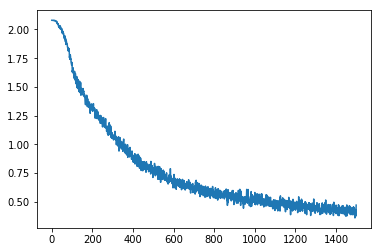

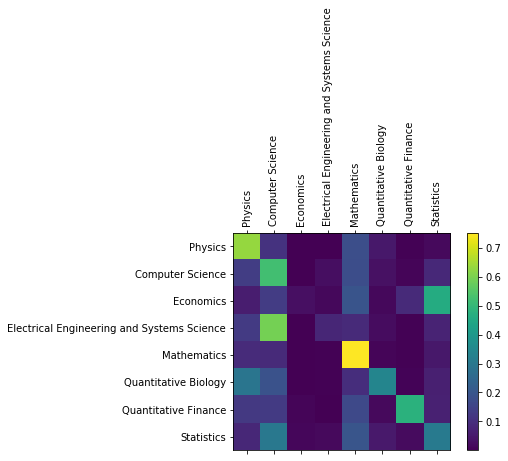

tensor([[63., 10.,  0.,  0., 18.,  4.,  0.,  2.],
        [13., 52.,  0.,  2., 17.,  3.,  0.,  8.],
        [ 5., 13.,  2.,  1., 19.,  1.,  8., 46.],
        [12., 59.,  0.,  8.,  9.,  2.,  0.,  7.],
        [ 9.,  8.,  0.,  0., 75.,  0.,  0.,  4.],
        [29., 19.,  0.,  0.,  9., 34.,  0.,  6.],
        [12., 12.,  0.,  0., 16.,  2., 47.,  7.],
        [ 8., 30.,  1.,  1., 19.,  5.,  2., 30.]])


In [0]:
training_percentage = 0.9
training_dict = dict()
testing_dict = dict()
for cat in all_categories:
    all_articles = articles_dict[cat]
    shuffle(all_articles)
    p = int(len(all_articles)*training_percentage)
    training_dict[cat] = all_articles[:p]
    testing_dict[cat] = all_articles[p+1:]

learning_rate = 0.005

n_batch_iters = 75000
batch_size = 25
print_every = 100
plot_every = 50

# keep track of losses for plotting
current_loss = 0
all_losses = []

use_characters = 140
print_statistics(use_characters)

model = leakyCNN_model(use_characters, n_letters, n_categories).cuda()
criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(model.parameters(), lr = learning_rate, momentum = 0.9)

start = time.time()

for it in range(1, n_batch_iters+1):
    batch = torch.zeros((batch_size, 1, use_characters, n_letters)).cuda()
    out_batch = torch.zeros(batch_size, dtype=torch.long).cuda()
    optimizer.zero_grad()
    bi = 0
    while bi < batch_size:
        category, abstract, category_tensor, abstract_tensor = randomCNNTrainingExample(use_characters)
        if len(abstract) < use_characters:
            continue
        batch[bi, :, :, :] = abstract_tensor
        out_batch[bi] = category_tensor
        bi += 1
            
    output = model(batch)
    loss = criterion(output, out_batch)
    loss.backward()
    current_loss += loss.item()
    optimizer.step()
    
    if not (it % print_every):
        guess, guess_i = categoryFromOutput(output)
        correct = "V" if guess == category else "X {}".format(category)
        print("{} {}% ({}) {:.4} / {} {}".format(it, round(it/n_batch_iters*100, 2), timeSince(start), loss, guess, correct))
        
    if not (it % plot_every):
        all_losses.append(current_loss / plot_every)
        current_loss = 0
        
plot_losses(all_losses)

rights = 0
wrongs = 0
confusion = torch.zeros(n_categories, n_categories)
with torch.no_grad():
  for cat in all_categories:
      for article in testing_dict[cat]:
          if len(article["abstract"]) < use_characters:
              continue
          abstract_tensor = lineToCNNTensor(article["abstract"][:use_characters]).unsqueeze_(0).cuda()
          cat_i = all_categories.index(cat)
          category_tensor = torch.tensor([cat_i], dtype=torch.long).cuda()
          output = model(abstract_tensor)
          guess, guess_i = categoryFromOutput(output)
          if guess_i == cat_i:
              rights += 1
          else:
              wrongs += 1
          confusion[cat_i][guess_i] += 1
print("{} accuracy out of {} tests".format(round(rights/(rights+wrongs),2), rights+wrongs))


# Normalize by dividing every row by its sum
for i in range(n_categories):
    confusion[i] = confusion[i] / confusion[i].sum()

import matplotlib.ticker as ticker
    
# Set up plot
fig = plt.figure()
ax = fig.add_subplot(111)
cax = ax.matshow(confusion.numpy())
fig.colorbar(cax)

# Set up axes
ax.set_xticklabels([''] + all_categories, rotation=90)
ax.set_yticklabels([''] + all_categories)

# Force label at every tick
ax.xaxis.set_major_locator(ticker.MultipleLocator(1))
ax.yaxis.set_major_locator(ticker.MultipleLocator(1))

# sphinx_gallery_thumbnail_number = 2
plt.show()

print(confusion*1000//10)

## Train for slightly longer (63%), add out of 2 accuracy (82%)

With regards to abstracts of length at least 140,
	206044 abstracts for Physics
	143111 abstracts for Computer Science
	   671 abstracts for Economics
	  6318 abstracts for Electrical Engineering and Systems Science
	153542 abstracts for Mathematics
	 25718 abstracts for Quantitative Biology
	 11787 abstracts for Quantitative Finance
	 22070 abstracts for Statistics
100 0.1% (0.0m 8.153122186660767s) 2.082 / Statistics X Mathematics
200 0.2% (0.0m 16.29940629005432s) 2.082 / Electrical Engineering and Systems Science X Mathematics
300 0.3% (0.0m 24.46502995491028s) 2.071 / Computer Science X Electrical Engineering and Systems Science
400 0.4% (0.0m 32.600290060043335s) 2.089 / Quantitative Finance X Mathematics
500 0.5% (0.0m 40.75334095954895s) 2.091 / Economics X Physics
600 0.6% (0.0m 48.91428756713867s) 2.066 / Economics X Mathematics
700 0.7% (0.0m 57.055333375930786s) 2.071 / Quantitative Biology X Electrical Engineering and Systems Science
800 0.8% (1.0m 5.217763423919678s) 2.07

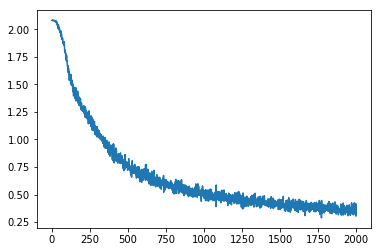

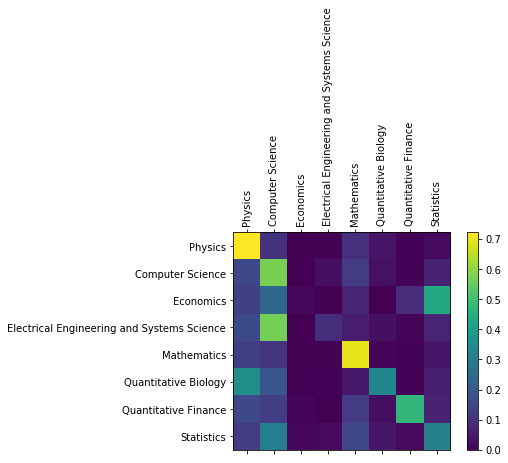

tensor([[72., 10.,  0.,  0.,  9.,  4.,  0.,  2.],
        [15., 57.,  0.,  2., 12.,  3.,  0.,  7.],
        [13., 24.,  1.,  0.,  7.,  0.,  9., 43.],
        [16., 57.,  0.,  9.,  5.,  2.,  0.,  7.],
        [13., 10.,  0.,  0., 69.,  0.,  0.,  4.],
        [35., 19.,  0.,  0.,  4., 33.,  0.,  6.],
        [16., 13.,  0.,  0., 12.,  2., 47.,  6.],
        [12., 30.,  1.,  1., 15.,  4.,  1., 31.]])


In [0]:
training_percentage = 0.9
training_dict = dict()
testing_dict = dict()
for cat in all_categories:
    all_articles = articles_dict[cat]
    shuffle(all_articles)
    p = int(len(all_articles)*training_percentage)
    training_dict[cat] = all_articles[:p]
    testing_dict[cat] = all_articles[p+1:]

learning_rate = 0.005

n_batch_iters = 100000
batch_size = 25
print_every = 100
plot_every = 50

# keep track of losses for plotting
current_loss = 0
all_losses = []

use_characters = 140
print_statistics(use_characters)

model = leakyCNN_model(use_characters, n_letters, n_categories).cuda()
criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(model.parameters(), lr = learning_rate, momentum = 0.9)

start = time.time()

for it in range(1, n_batch_iters+1):
    batch = torch.zeros((batch_size, 1, use_characters, n_letters)).cuda()
    out_batch = torch.zeros(batch_size, dtype=torch.long).cuda()
    optimizer.zero_grad()
    bi = 0
    while bi < batch_size:
        category, abstract, category_tensor, abstract_tensor = randomCNNTrainingExample(use_characters)
        if len(abstract) < use_characters:
            continue
        batch[bi, :, :, :] = abstract_tensor
        out_batch[bi] = category_tensor
        bi += 1
            
    output = model(batch)
    loss = criterion(output, out_batch)
    loss.backward()
    current_loss += loss.item()
    optimizer.step()
    
    if not (it % print_every):
        guess, guess_i = categoryFromOutput(output)
        correct = "V" if guess == category else "X {}".format(category)
        print("{} {}% ({}) {:.4} / {} {}".format(it, round(it/n_batch_iters*100, 2), timeSince(start), loss, guess, correct))
        
    if not (it % plot_every):
        all_losses.append(current_loss / plot_every)
        current_loss = 0
        
plot_losses(all_losses)

rights = 0
wrongs = 0
top2rights = 0
top2wrongs = 0
confusion = torch.zeros(n_categories, n_categories)
with torch.no_grad():
  for cat in all_categories:
      for article in testing_dict[cat]:
          if len(article["abstract"]) < use_characters:
              continue
          abstract_tensor = lineToCNNTensor(article["abstract"][:use_characters]).unsqueeze_(0).cuda()
          cat_i = all_categories.index(cat)
          category_tensor = torch.tensor([cat_i], dtype=torch.long).cuda()
          output = model(abstract_tensor)
          guess1, guess2 = topTwoFromOutput(output)
          if guess1 == cat_i:
              rights += 1
              top2rights += 1
          else:
              wrongs += 1
              if guess2 == cat_i:
                  top2rights += 1
              else:
                  top2wrongs +=1
          confusion[cat_i][guess1] += 1
print("{} accuracy out of {} tests".format(round(100*rights/(rights+wrongs),2), rights+wrongs))
print("Top 2 accuracy was {}".format(round(100*top2rights/(top2rights+top2wrongs), 2)))


# Normalize by dividing every row by its sum
for i in range(n_categories):
    confusion[i] = confusion[i] / confusion[i].sum()

import matplotlib.ticker as ticker
    
# Set up plot
fig = plt.figure()
ax = fig.add_subplot(111)
cax = ax.matshow(confusion.numpy())
fig.colorbar(cax)

# Set up axes
ax.set_xticklabels([''] + all_categories, rotation=90)
ax.set_yticklabels([''] + all_categories)

# Force label at every tick
ax.xaxis.set_major_locator(ticker.MultipleLocator(1))
ax.yaxis.set_major_locator(ticker.MultipleLocator(1))

# sphinx_gallery_thumbnail_number = 2
plt.show()

print(confusion*1000//10)

### Use the model to classify some abstracts

In [0]:
# from https://arxiv.org/abs/1906.07154, CS
abstract1 = "SAP is the market leader in enterprise software offering an end-to-end suite of applications and services to enable their customers worldwide to operate their business. Especially, retail customers of SAP deal with millions of sales transactions for their day-to-day business. Transactions are created during retail sales at the point of sale (POS) terminals and then s"
abstract1 = abstract1[:140]
tensor1 = lineToCNNTensor(abstract1)
with torch.no_grad():
    print("Should be CS")
    out = model(tensor1.unsqueeze_(0).cuda())
    print(categoryFromOutput(out))
    top1, top2 = topTwoFromOutput(out)
    print(all_categories[top2])
    print("-"*30)
    
# from https://arxiv.org/abs/1906.07156, Physics
abstract2 = "Pulsars typically exhibit radio emission in the form of narrow pulses originated from confined regions of their magnetospheres. A potential presence of magnetospherically originated emission outside this region, the so-called off-pulse emission, would challenge the existing theories. Detection of significant off-pulse emission has been reported so far from only two puls"
abstract2 = abstract2[:140]
tensor2 = lineToCNNTensor(abstract2)
with torch.no_grad():
    print("Should be Physics")
    out = model(tensor2.unsqueeze_(0).cuda())
    print(categoryFromOutput(out))
    top1, top2 = topTwoFromOutput(out)
    print(all_categories[top2])
    print("-"*30)
    
# from https://arxiv.org/abs/1906.07150, Maths
abstract3 = "This paper introduces a modification of n-dimensional Hopf-Cole transformation to the n-dimensional Burgers' system. We obtain the n-dimensional heat conduction equation through the modification of the Hopf-Cole transformation. Then the high-order exponential time differencing precise integration method (PIM) based on fourth-order Taylor approximatio"
abstract3 = abstract3[:140]
tensor3 = lineToCNNTensor(abstract3)
with torch.no_grad():
    print("Should be Maths")
    out = model(tensor3.unsqueeze_(0).cuda())
    print(categoryFromOutput(out))
    top1, top2 = topTwoFromOutput(out)
    print(all_categories[top2])
    print("-"*30)
    
# from https://arxiv.org/abs/1906.07117, Quantitative Biology
abstract4 = "Sexual reproduction is not always synonymous with the existence of two morphologically different sexes; isogamous species produce sex cells of equal size, typically falling into multiple distinct self-incompatible classes, termed mating types. A long-standing open question in evolutionary biology is: what governs the number of these mating types across species?"
abstract4 = abstract4[:140]
tensor4 = lineToCNNTensor(abstract4)
with torch.no_grad():
    print("Should be Quant. Biology")
    out = model(tensor4.unsqueeze_(0).cuda())
    print(categoryFromOutput(out))
    top1, top2 = topTwoFromOutput(out)
    print(all_categories[top2])
    print("-"*30)
    
# from https://arxiv.org/abs/1906.07101, Quantitative Finance
abstract5 = "The research presented in this article provides an alternative option pricing approach for a class of rough fractional stochastic volatility models. These models are increasingly popular between academics and practitioners due to their surprising consistency with financial markets. However, they bring several challenges alongside. Most noticeably, even simple non-linear"
abstract5 = abstract5[:140]
tensor5 = lineToCNNTensor(abstract5)
with torch.no_grad():
    print("Should be Quant. Finance")
    out = model(tensor5.unsqueeze_(0).cuda())
    print(categoryFromOutput(out))
    top1, top2 = topTwoFromOutput(out)
    print(all_categories[top2])
    print("-"*30)
    
# from https://arxiv.org/abs/1906.07136, Statistics
abstract6 = "It is common practice in using regression type models for inferring causal effects, that inferring the correct causal relationship requires extra covariates are included or ``adjusted for''. Without performing this adjustment erroneous causal effects can be inferred. Given this phenomenon it is common practice to include as many covariates as possible, however such advice comes unstuck"
abstract6 = abstract6[:140]
tensor6 = lineToCNNTensor(abstract6)
with torch.no_grad():
    print("Should be Stats")
    out = model(tensor6.unsqueeze_(0).cuda())
    print(categoryFromOutput(out))
    top1, top2 = topTwoFromOutput(out)
    print(all_categories[top2])
    print("-"*30)
    
# from https://arxiv.org/abs/1906.07126, El. Eng. and Sys Science
abstract7 = "To address the issue that Lagrangian dual function based algorithms cannot guarantee convergence and global optimality for decentralized multi-area security constrained unit commitment (M-SCUC) problems, a novel decomposition and coordination method using MILP (mixed integer linear programming) value functions is proposed in this paper. Each regional system operator sets"
abstract7 = abstract7[:140]
tensor7 = lineToCNNTensor(abstract7)
with torch.no_grad():
    print("Should be EESS")
    out = model(tensor7.unsqueeze_(0).cuda())
    print(categoryFromOutput(out))
    top1, top2 = topTwoFromOutput(out)
    print(all_categories[top2])
    print("-"*30)

# from https://arxiv.org/abs/1906.06810, Economics
abstract8 = "We study a pure-exchange incomplete markets model with heterogeneous agents. In each period, the agents choose how much to save and which bundle of goods to consume while their endowments are fluctuating. We focus on a competitive stationary equilibrium (CSE) in which the wealth distribution is invariant, the agents maximize their expected discounted utility, and both the prices"
abstract8 = abstract8[:140]
tensor8 = lineToCNNTensor(abstract8)
with torch.no_grad():
    print("Should be Economics")
    out = model(tensor8.unsqueeze_(0).cuda())
    print(categoryFromOutput(out))
    top1, top2 = topTwoFromOutput(out)
    print(all_categories[top2])
    print("-"*30)

Should be CS
('Computer Science', 1)
Statistics
------------------------------
Should be Physics
('Physics', 0)
Quantitative Biology
------------------------------
Should be Maths
('Physics', 0)
Mathematics
------------------------------
Should be Quant. Biology
('Computer Science', 1)
Physics
------------------------------
Should be Quant. Finance
('Mathematics', 4)
Computer Science
------------------------------
Should be Stats
('Statistics', 7)
Computer Science
------------------------------
Should be EESS
('Statistics', 7)
Computer Science
------------------------------
Should be Economics
('Physics', 0)
Quantitative Finance
------------------------------


## Increase everything just a little bit (64% / 82%)
### training percentage, lr, batch iterations, batch size

With regards to abstracts of length at least 140,
	206044 abstracts for Physics
	143111 abstracts for Computer Science
	   671 abstracts for Economics
	  6318 abstracts for Electrical Engineering and Systems Science
	153542 abstracts for Mathematics
	 25718 abstracts for Quantitative Biology
	 11787 abstracts for Quantitative Finance
	 22070 abstracts for Statistics
100 0.09% (0.0m 6.444252967834473s) 2.084 / Electrical Engineering and Systems Science X Physics
200 0.18% (0.0m 12.855146646499634s) 2.084 / Computer Science X Physics
300 0.27% (0.0m 19.28525733947754s) 2.072 / Economics V
400 0.36% (0.0m 25.779783487319946s) 2.091 / Statistics X Physics
500 0.45% (0.0m 32.208868980407715s) 2.09 / Physics X Quantitative Biology
600 0.55% (0.0m 38.654273986816406s) 2.052 / Quantitative Biology V
700 0.64% (0.0m 45.083871364593506s) 2.063 / Statistics X Quantitative Biology
800 0.73% (0.0m 51.4841091632843s) 2.07 / Quantitative Biology X Mathematics
900 0.82% (0.0m 57.93323111534119s) 2.056

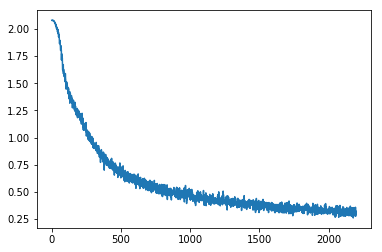

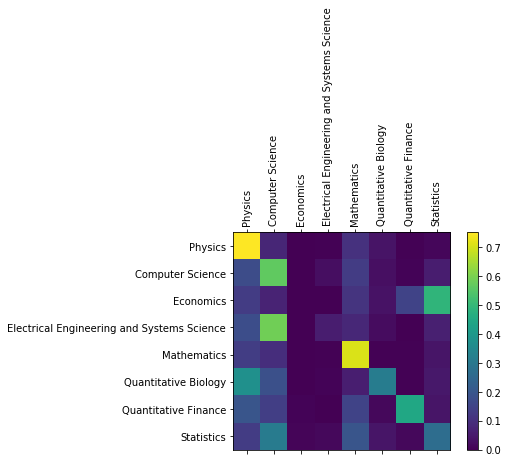

tensor([[75.,  8.,  0.,  0., 10.,  3.,  0.,  1.],
        [17., 56.,  0.,  2., 13.,  2.,  0.,  5.],
        [13.,  7.,  0.,  0., 11.,  3., 15., 49.],
        [17., 58.,  0.,  5.,  8.,  2.,  0.,  6.],
        [13.,  9.,  0.,  0., 70.,  0.,  0.,  4.],
        [37., 18.,  0.,  0.,  6., 31.,  0.,  4.],
        [19., 13.,  0.,  0., 15.,  1., 44.,  4.],
        [13., 31.,  1.,  1., 19.,  4.,  1., 26.]])


In [0]:
training_percentage = 0.92
training_dict = dict()
testing_dict = dict()
for cat in all_categories:
    all_articles = articles_dict[cat]
    shuffle(all_articles)
    p = int(len(all_articles)*training_percentage)
    training_dict[cat] = all_articles[:p]
    testing_dict[cat] = all_articles[p+1:]

learning_rate = 0.006

n_batch_iters = 110000
batch_size = 30
print_every = 100
plot_every = 50

# keep track of losses for plotting
current_loss = 0
all_losses = []

use_characters = 140
print_statistics(use_characters)

model = leakyCNN_model(use_characters, n_letters, n_categories).cuda()
criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(model.parameters(), lr = learning_rate, momentum = 0.9)

start = time.time()

for it in range(1, n_batch_iters+1):
    batch = torch.zeros((batch_size, 1, use_characters, n_letters)).cuda()
    out_batch = torch.zeros(batch_size, dtype=torch.long).cuda()
    optimizer.zero_grad()
    bi = 0
    while bi < batch_size:
        category, abstract, category_tensor, abstract_tensor = randomCNNTrainingExample(use_characters)
        if len(abstract) < use_characters:
            continue
        batch[bi, :, :, :] = abstract_tensor
        out_batch[bi] = category_tensor
        bi += 1
            
    output = model(batch)
    loss = criterion(output, out_batch)
    loss.backward()
    current_loss += loss.item()
    optimizer.step()
    
    if not (it % print_every):
        guess, guess_i = categoryFromOutput(output)
        correct = "V" if guess == category else "X {}".format(category)
        print("{} {}% ({}) {:.4} / {} {}".format(it, round(it/n_batch_iters*100, 2), timeSince(start), loss, guess, correct))
        
    if not (it % plot_every):
        all_losses.append(current_loss / plot_every)
        current_loss = 0
        
plot_losses(all_losses)

rights = 0
wrongs = 0
top2rights = 0
top2wrongs = 0
confusion = torch.zeros(n_categories, n_categories)
with torch.no_grad():
  for cat in all_categories:
      for article in testing_dict[cat]:
          if len(article["abstract"]) < use_characters:
              continue
          abstract_tensor = lineToCNNTensor(article["abstract"][:use_characters]).unsqueeze_(0).cuda()
          cat_i = all_categories.index(cat)
          category_tensor = torch.tensor([cat_i], dtype=torch.long).cuda()
          output = model(abstract_tensor)
          guess1, guess2 = topTwoFromOutput(output)
          if guess1 == cat_i:
              rights += 1
              top2rights += 1
          else:
              wrongs += 1
              if guess2 == cat_i:
                  top2rights += 1
              else:
                  top2wrongs +=1
          confusion[cat_i][guess1] += 1
print("{} accuracy out of {} tests".format(round(100*rights/(rights+wrongs),2), rights+wrongs))
print("Top 2 accuracy was {}".format(round(100*top2rights/(top2rights+top2wrongs), 2)))


# Normalize by dividing every row by its sum
for i in range(n_categories):
    confusion[i] = confusion[i] / confusion[i].sum()

import matplotlib.ticker as ticker
    
# Set up plot
fig = plt.figure()
ax = fig.add_subplot(111)
cax = ax.matshow(confusion.numpy())
fig.colorbar(cax)

# Set up axes
ax.set_xticklabels([''] + all_categories, rotation=90)
ax.set_yticklabels([''] + all_categories)

# Force label at every tick
ax.xaxis.set_major_locator(ticker.MultipleLocator(1))
ax.yaxis.set_major_locator(ticker.MultipleLocator(1))

# sphinx_gallery_thumbnail_number = 2
plt.show()

print(confusion*1000//10)

## Increase lr, batch iterations just a little bit again (64% / 82%)

With regards to abstracts of length at least 140,
	206044 abstracts for Physics
	143111 abstracts for Computer Science
	   671 abstracts for Economics
	  6318 abstracts for Electrical Engineering and Systems Science
	153542 abstracts for Mathematics
	 25718 abstracts for Quantitative Biology
	 11787 abstracts for Quantitative Finance
	 22070 abstracts for Statistics
100 0.08% (0.0m 6.6608850955963135s) 2.087 / Economics X Quantitative Finance
200 0.17% (0.0m 13.083892822265625s) 2.094 / Electrical Engineering and Systems Science X Economics
300 0.25% (0.0m 19.531232357025146s) 2.079 / Electrical Engineering and Systems Science X Quantitative Biology
400 0.33% (0.0m 25.979113578796387s) 2.087 / Quantitative Biology X Computer Science
500 0.42% (0.0m 32.42497897148132s) 2.083 / Quantitative Biology X Electrical Engineering and Systems Science
600 0.5% (0.0m 38.919373989105225s) 2.066 / Physics X Statistics
700 0.58% (0.0m 45.43251872062683s) 2.063 / Physics X Mathematics
800 0.67% (0.0m 

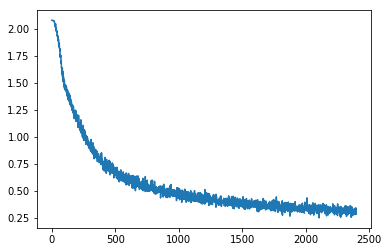

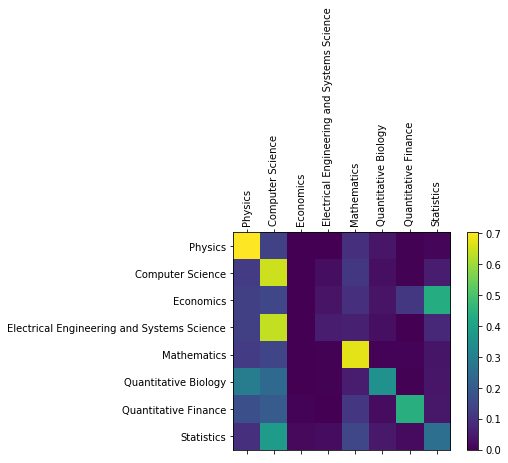

tensor([[70., 13.,  0.,  0.,  9.,  4.,  0.,  1.],
        [12., 64.,  0.,  2., 11.,  2.,  0.,  5.],
        [13., 15.,  0.,  3.,  9.,  3., 11., 43.],
        [13., 63.,  0.,  5.,  6.,  2.,  0.,  7.],
        [12., 14.,  0.,  0., 67.,  0.,  0.,  3.],
        [29., 24.,  0.,  0.,  5., 35.,  0.,  4.],
        [17., 20.,  0.,  0., 11.,  2., 44.,  4.],
        [ 9., 38.,  1.,  2., 15.,  4.,  2., 25.]])


In [0]:
training_percentage = 0.92
training_dict = dict()
testing_dict = dict()
for cat in all_categories:
    all_articles = articles_dict[cat]
    shuffle(all_articles)
    p = int(len(all_articles)*training_percentage)
    training_dict[cat] = all_articles[:p]
    testing_dict[cat] = all_articles[p+1:]

learning_rate = 0.007

n_batch_iters = 120000
batch_size = 30
print_every = 100
plot_every = 50

# keep track of losses for plotting
current_loss = 0
all_losses = []

use_characters = 140
print_statistics(use_characters)

model = leakyCNN_model(use_characters, n_letters, n_categories).cuda()
criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(model.parameters(), lr = learning_rate, momentum = 0.9)

start = time.time()

for it in range(1, n_batch_iters+1):
    batch = torch.zeros((batch_size, 1, use_characters, n_letters)).cuda()
    out_batch = torch.zeros(batch_size, dtype=torch.long).cuda()
    optimizer.zero_grad()
    bi = 0
    while bi < batch_size:
        category, abstract, category_tensor, abstract_tensor = randomCNNTrainingExample(use_characters)
        if len(abstract) < use_characters:
            continue
        batch[bi, :, :, :] = abstract_tensor
        out_batch[bi] = category_tensor
        bi += 1
            
    output = model(batch)
    loss = criterion(output, out_batch)
    loss.backward()
    current_loss += loss.item()
    optimizer.step()
    
    if not (it % print_every):
        guess, guess_i = categoryFromOutput(output)
        correct = "V" if guess == category else "X {}".format(category)
        print("{} {}% ({}) {:.4} / {} {}".format(it, round(it/n_batch_iters*100, 2), timeSince(start), loss, guess, correct))
        
    if not (it % plot_every):
        all_losses.append(current_loss / plot_every)
        current_loss = 0
        
plot_losses(all_losses)

rights = 0
wrongs = 0
top2rights = 0
top2wrongs = 0
confusion = torch.zeros(n_categories, n_categories)
with torch.no_grad():
  for cat in all_categories:
      for article in testing_dict[cat]:
          if len(article["abstract"]) < use_characters:
              continue
          abstract_tensor = lineToCNNTensor(article["abstract"][:use_characters]).unsqueeze_(0).cuda()
          cat_i = all_categories.index(cat)
          category_tensor = torch.tensor([cat_i], dtype=torch.long).cuda()
          output = model(abstract_tensor)
          guess1, guess2 = topTwoFromOutput(output)
          if guess1 == cat_i:
              rights += 1
              top2rights += 1
          else:
              wrongs += 1
              if guess2 == cat_i:
                  top2rights += 1
              else:
                  top2wrongs +=1
          confusion[cat_i][guess1] += 1
print("{} accuracy out of {} tests".format(round(100*rights/(rights+wrongs),2), rights+wrongs))
print("Top 2 accuracy was {}".format(round(100*top2rights/(top2rights+top2wrongs), 2)))


# Normalize by dividing every row by its sum
for i in range(n_categories):
    confusion[i] = confusion[i] / confusion[i].sum()

import matplotlib.ticker as ticker
    
# Set up plot
fig = plt.figure()
ax = fig.add_subplot(111)
cax = ax.matshow(confusion.numpy())
fig.colorbar(cax)

# Set up axes
ax.set_xticklabels([''] + all_categories, rotation=90)
ax.set_yticklabels([''] + all_categories)

# Force label at every tick
ax.xaxis.set_major_locator(ticker.MultipleLocator(1))
ax.yaxis.set_major_locator(ticker.MultipleLocator(1))

# sphinx_gallery_thumbnail_number = 2
plt.show()

print(confusion*1000//10)

## Even more (64% / 82%)

With regards to abstracts of length at least 140,
	206044 abstracts for Physics
	143111 abstracts for Computer Science
	   671 abstracts for Economics
	  6318 abstracts for Electrical Engineering and Systems Science
	153542 abstracts for Mathematics
	 25718 abstracts for Quantitative Biology
	 11787 abstracts for Quantitative Finance
	 22070 abstracts for Statistics
100 0.07% (0.0m 6.506326198577881s) 2.071 / Electrical Engineering and Systems Science X Statistics
200 0.13% (0.0m 12.992497205734253s) 2.074 / Statistics X Mathematics
300 0.2% (0.0m 19.404115438461304s) 2.082 / Statistics X Quantitative Biology
400 0.27% (0.0m 25.82534146308899s) 2.077 / Quantitative Finance X Mathematics
500 0.33% (0.0m 32.24621939659119s) 2.061 / Economics V
600 0.4% (0.0m 38.71170663833618s) 2.099 / Physics V
700 0.47% (0.0m 45.162846088409424s) 2.069 / Quantitative Finance V
800 0.53% (0.0m 51.63689827919006s) 2.076 / Electrical Engineering and Systems Science X Quantitative Finance
900 0.6% (0.0m 58

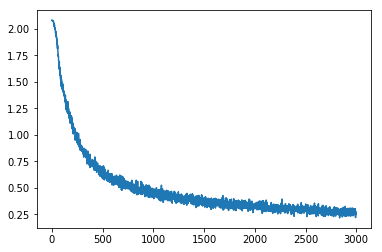

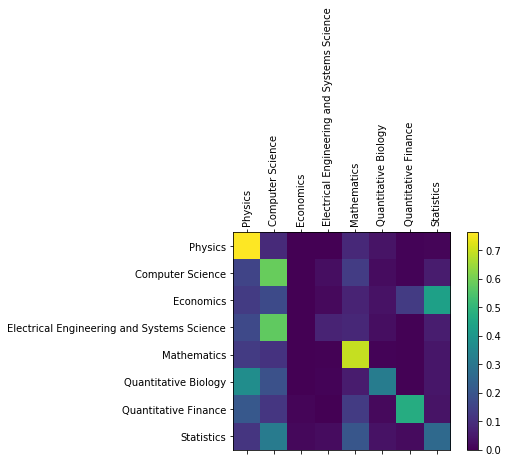

tensor([[76.,  9.,  0.,  0.,  8.,  3.,  0.,  1.],
        [15., 58.,  0.,  2., 13.,  2.,  0.,  5.],
        [13., 16.,  0.,  1.,  7.,  3., 13., 43.],
        [16., 57.,  0.,  7.,  8.,  2.,  0.,  6.],
        [13., 11.,  0.,  0., 69.,  0.,  0.,  4.],
        [37., 18.,  0.,  0.,  5., 32.,  0.,  4.],
        [20., 12.,  0.,  0., 13.,  1., 47.,  3.],
        [11., 31.,  1.,  2., 20.,  3.,  2., 25.]])


In [0]:
training_percentage = 0.92
training_dict = dict()
testing_dict = dict()
for cat in all_categories:
    all_articles = articles_dict[cat]
    shuffle(all_articles)
    p = int(len(all_articles)*training_percentage)
    training_dict[cat] = all_articles[:p]
    testing_dict[cat] = all_articles[p+1:]

learning_rate = 0.008

n_batch_iters = 150000
batch_size = 30
print_every = 100
plot_every = 50

# keep track of losses for plotting
current_loss = 0
all_losses = []

use_characters = 140
print_statistics(use_characters)

model = leakyCNN_model(use_characters, n_letters, n_categories).cuda()
criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(model.parameters(), lr = learning_rate, momentum = 0.9)

start = time.time()

for it in range(1, n_batch_iters+1):
    batch = torch.zeros((batch_size, 1, use_characters, n_letters)).cuda()
    out_batch = torch.zeros(batch_size, dtype=torch.long).cuda()
    optimizer.zero_grad()
    bi = 0
    while bi < batch_size:
        category, abstract, category_tensor, abstract_tensor = randomCNNTrainingExample(use_characters)
        if len(abstract) < use_characters:
            continue
        batch[bi, :, :, :] = abstract_tensor
        out_batch[bi] = category_tensor
        bi += 1
            
    output = model(batch)
    loss = criterion(output, out_batch)
    loss.backward()
    current_loss += loss.item()
    optimizer.step()
    
    if not (it % print_every):
        guess, guess_i = categoryFromOutput(output)
        correct = "V" if guess == category else "X {}".format(category)
        print("{} {}% ({}) {:.4} / {} {}".format(it, round(it/n_batch_iters*100, 2), timeSince(start), loss, guess, correct))
        
    if not (it % plot_every):
        all_losses.append(current_loss / plot_every)
        current_loss = 0
        
plot_losses(all_losses)

rights = 0
wrongs = 0
top2rights = 0
top2wrongs = 0
confusion = torch.zeros(n_categories, n_categories)
with torch.no_grad():
  for cat in all_categories:
      for article in testing_dict[cat]:
          if len(article["abstract"]) < use_characters:
              continue
          abstract_tensor = lineToCNNTensor(article["abstract"][:use_characters]).unsqueeze_(0).cuda()
          cat_i = all_categories.index(cat)
          category_tensor = torch.tensor([cat_i], dtype=torch.long).cuda()
          output = model(abstract_tensor)
          guess1, guess2 = topTwoFromOutput(output)
          if guess1 == cat_i:
              rights += 1
              top2rights += 1
          else:
              wrongs += 1
              if guess2 == cat_i:
                  top2rights += 1
              else:
                  top2wrongs +=1
          confusion[cat_i][guess1] += 1
print("{} accuracy out of {} tests".format(round(100*rights/(rights+wrongs),2), rights+wrongs))
print("Top 2 accuracy was {}".format(round(100*top2rights/(top2rights+top2wrongs), 2)))


# Normalize by dividing every row by its sum
for i in range(n_categories):
    confusion[i] = confusion[i] / confusion[i].sum()

import matplotlib.ticker as ticker
    
# Set up plot
fig = plt.figure()
ax = fig.add_subplot(111)
cax = ax.matshow(confusion.numpy())
fig.colorbar(cax)

# Set up axes
ax.set_xticklabels([''] + all_categories, rotation=90)
ax.set_yticklabels([''] + all_categories)

# Force label at every tick
ax.xaxis.set_major_locator(ticker.MultipleLocator(1))
ax.yaxis.set_major_locator(ticker.MultipleLocator(1))

# sphinx_gallery_thumbnail_number = 2
plt.show()

print(confusion*1000//10)

## Reduce lr (64% / 82%)

With regards to abstracts of length at least 140,
	206044 abstracts for Physics
	143111 abstracts for Computer Science
	   671 abstracts for Economics
	  6318 abstracts for Electrical Engineering and Systems Science
	153542 abstracts for Mathematics
	 25718 abstracts for Quantitative Biology
	 11787 abstracts for Quantitative Finance
	 22070 abstracts for Statistics
100 0.07% (0.0m 6.485038995742798s) 2.079 / Physics X Computer Science
200 0.13% (0.0m 12.884758234024048s) 2.074 / Physics X Electrical Engineering and Systems Science
300 0.2% (0.0m 19.30412244796753s) 2.08 / Electrical Engineering and Systems Science X Quantitative Finance
400 0.27% (0.0m 25.724767208099365s) 2.069 / Physics X Mathematics
500 0.33% (0.0m 32.21619153022766s) 2.087 / Quantitative Biology V
600 0.4% (0.0m 38.71834325790405s) 2.096 / Computer Science V
700 0.47% (0.0m 45.17435836791992s) 2.075 / Economics V
800 0.53% (0.0m 51.743197441101074s) 2.1 / Computer Science X Economics
900 0.6% (0.0m 58.218707561492

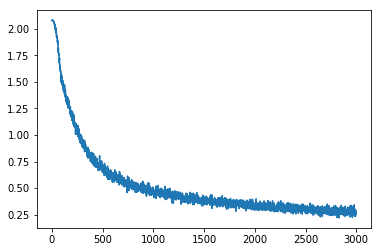

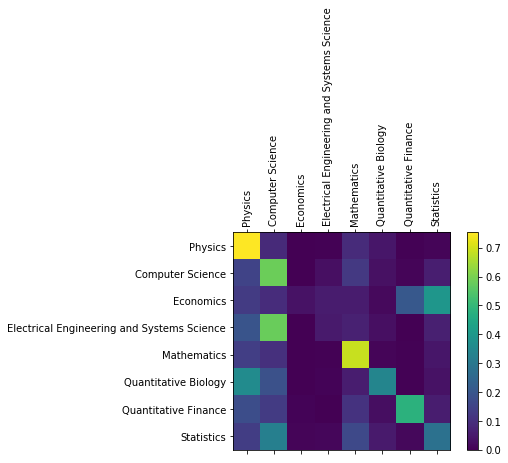

tensor([[75.,  8.,  0.,  0.,  9.,  4.,  0.,  1.],
        [15., 58.,  0.,  3., 12.,  3.,  0.,  6.],
        [13.,  9.,  3.,  5.,  5.,  1., 20., 39.],
        [19., 58.,  0.,  5.,  6.,  3.,  0.,  6.],
        [13., 10.,  0.,  0., 69.,  1.,  0.,  4.],
        [36., 18.,  0.,  0.,  5., 34.,  0.,  3.],
        [17., 13.,  0.,  0., 11.,  2., 48.,  6.],
        [13., 32.,  1.,  1., 16.,  5.,  1., 28.]])


In [0]:
training_percentage = 0.92
training_dict = dict()
testing_dict = dict()
for cat in all_categories:
    all_articles = articles_dict[cat]
    shuffle(all_articles)
    p = int(len(all_articles)*training_percentage)
    training_dict[cat] = all_articles[:p]
    testing_dict[cat] = all_articles[p+1:]

learning_rate = 0.007

n_batch_iters = 150000
batch_size = 30
print_every = 100
plot_every = 50

# keep track of losses for plotting
current_loss = 0
all_losses = []

use_characters = 140
print_statistics(use_characters)

model = leakyCNN_model(use_characters, n_letters, n_categories).cuda()
criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(model.parameters(), lr = learning_rate, momentum = 0.9)

start = time.time()

for it in range(1, n_batch_iters+1):
    batch = torch.zeros((batch_size, 1, use_characters, n_letters)).cuda()
    out_batch = torch.zeros(batch_size, dtype=torch.long).cuda()
    optimizer.zero_grad()
    bi = 0
    while bi < batch_size:
        category, abstract, category_tensor, abstract_tensor = randomCNNTrainingExample(use_characters)
        if len(abstract) < use_characters:
            continue
        batch[bi, :, :, :] = abstract_tensor
        out_batch[bi] = category_tensor
        bi += 1
            
    output = model(batch)
    loss = criterion(output, out_batch)
    loss.backward()
    current_loss += loss.item()
    optimizer.step()
    
    if not (it % print_every):
        guess, guess_i = categoryFromOutput(output)
        correct = "V" if guess == category else "X {}".format(category)
        print("{} {}% ({}) {:.4} / {} {}".format(it, round(it/n_batch_iters*100, 2), timeSince(start), loss, guess, correct))
        
    if not (it % plot_every):
        all_losses.append(current_loss / plot_every)
        current_loss = 0
        
plot_losses(all_losses)

rights = 0
wrongs = 0
top2rights = 0
top2wrongs = 0
confusion = torch.zeros(n_categories, n_categories)
with torch.no_grad():
  for cat in all_categories:
      for article in testing_dict[cat]:
          if len(article["abstract"]) < use_characters:
              continue
          abstract_tensor = lineToCNNTensor(article["abstract"][:use_characters]).unsqueeze_(0).cuda()
          cat_i = all_categories.index(cat)
          category_tensor = torch.tensor([cat_i], dtype=torch.long).cuda()
          output = model(abstract_tensor)
          guess1, guess2 = topTwoFromOutput(output)
          if guess1 == cat_i:
              rights += 1
              top2rights += 1
          else:
              wrongs += 1
              if guess2 == cat_i:
                  top2rights += 1
              else:
                  top2wrongs +=1
          confusion[cat_i][guess1] += 1
print("{} accuracy out of {} tests".format(round(100*rights/(rights+wrongs),2), rights+wrongs))
print("Top 2 accuracy was {}".format(round(100*top2rights/(top2rights+top2wrongs), 2)))


# Normalize by dividing every row by its sum
for i in range(n_categories):
    confusion[i] = confusion[i] / confusion[i].sum()

import matplotlib.ticker as ticker
    
# Set up plot
fig = plt.figure()
ax = fig.add_subplot(111)
cax = ax.matshow(confusion.numpy())
fig.colorbar(cax)

# Set up axes
ax.set_xticklabels([''] + all_categories, rotation=90)
ax.set_yticklabels([''] + all_categories)

# Force label at every tick
ax.xaxis.set_major_locator(ticker.MultipleLocator(1))
ax.yaxis.set_major_locator(ticker.MultipleLocator(1))

# sphinx_gallery_thumbnail_number = 2
plt.show()

print(confusion*1000//10)

## Try Adam for less time (44% / 67%)

With regards to abstracts of length at least 140,
	206044 abstracts for Physics
	143111 abstracts for Computer Science
	   671 abstracts for Economics
	  6318 abstracts for Electrical Engineering and Systems Science
	153542 abstracts for Mathematics
	 25718 abstracts for Quantitative Biology
	 11787 abstracts for Quantitative Finance
	 22070 abstracts for Statistics
100 0.1% (0.0m 9.935776233673096s) 2.065 / Computer Science V
200 0.2% (0.0m 19.89149570465088s) 2.082 / Economics X Mathematics
300 0.3% (0.0m 29.81258201599121s) 2.072 / Electrical Engineering and Systems Science X Statistics
400 0.4% (0.0m 39.751856088638306s) 2.056 / Economics X Mathematics
500 0.5% (0.0m 49.7000253200531s) 2.078 / Quantitative Finance X Mathematics
600 0.6% (0.0m 59.65521311759949s) 2.065 / Mathematics X Quantitative Finance
700 0.7% (1.0m 9.630048274993896s) 2.082 / Computer Science X Mathematics
800 0.8% (1.0m 19.536751985549927s) 2.078 / Physics X Statistics
900 0.9% (1.0m 29.51476526260376s) 2.106 

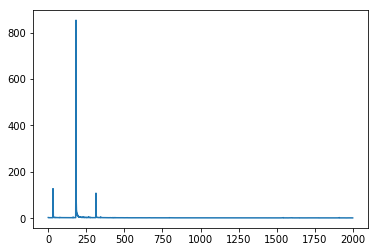

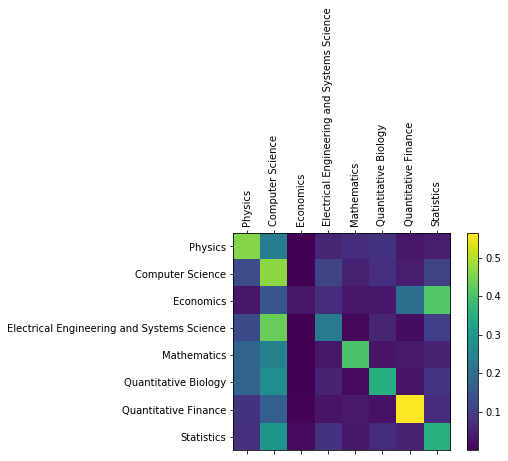

tensor([[46., 23.,  0.,  6.,  7.,  8.,  3.,  4.],
        [13., 46.,  0., 11.,  5.,  7.,  4., 11.],
        [ 3., 15.,  3.,  7.,  3.,  3., 20., 41.],
        [12., 43.,  0., 23.,  1.,  6.,  1., 10.],
        [17., 24.,  0.,  3., 40.,  2.,  4.,  5.],
        [17., 27.,  0.,  5.,  1., 35.,  3.,  8.],
        [ 8., 17.,  0.,  3.,  4.,  2., 56.,  7.],
        [ 7., 29.,  1.,  8.,  3.,  6.,  5., 35.]])


In [0]:
training_percentage = 0.92
training_dict = dict()
testing_dict = dict()
for cat in all_categories:
    all_articles = articles_dict[cat]
    shuffle(all_articles)
    p = int(len(all_articles)*training_percentage)
    training_dict[cat] = all_articles[:p]
    testing_dict[cat] = all_articles[p+1:]

learning_rate = 0.007

n_batch_iters = 100000
batch_size = 30
print_every = 100
plot_every = 50

# keep track of losses for plotting
current_loss = 0
all_losses = []

use_characters = 140
print_statistics(use_characters)

model = leakyCNN_model(use_characters, n_letters, n_categories).cuda()
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr = learning_rate)

start = time.time()

for it in range(1, n_batch_iters+1):
    batch = torch.zeros((batch_size, 1, use_characters, n_letters)).cuda()
    out_batch = torch.zeros(batch_size, dtype=torch.long).cuda()
    optimizer.zero_grad()
    bi = 0
    while bi < batch_size:
        category, abstract, category_tensor, abstract_tensor = randomCNNTrainingExample(use_characters)
        if len(abstract) < use_characters:
            continue
        batch[bi, :, :, :] = abstract_tensor
        out_batch[bi] = category_tensor
        bi += 1
            
    output = model(batch)
    loss = criterion(output, out_batch)
    loss.backward()
    current_loss += loss.item()
    optimizer.step()
    
    if not (it % print_every):
        guess, guess_i = categoryFromOutput(output)
        correct = "V" if guess == category else "X {}".format(category)
        print("{} {}% ({}) {:.4} / {} {}".format(it, round(it/n_batch_iters*100, 2), timeSince(start), loss, guess, correct))
        
    if not (it % plot_every):
        all_losses.append(current_loss / plot_every)
        current_loss = 0
        
plot_losses(all_losses)

rights = 0
wrongs = 0
top2rights = 0
top2wrongs = 0
confusion = torch.zeros(n_categories, n_categories)
with torch.no_grad():
  for cat in all_categories:
      for article in testing_dict[cat]:
          if len(article["abstract"]) < use_characters:
              continue
          abstract_tensor = lineToCNNTensor(article["abstract"][:use_characters]).unsqueeze_(0).cuda()
          cat_i = all_categories.index(cat)
          category_tensor = torch.tensor([cat_i], dtype=torch.long).cuda()
          output = model(abstract_tensor)
          guess1, guess2 = topTwoFromOutput(output)
          if guess1 == cat_i:
              rights += 1
              top2rights += 1
          else:
              wrongs += 1
              if guess2 == cat_i:
                  top2rights += 1
              else:
                  top2wrongs +=1
          confusion[cat_i][guess1] += 1
print("{} accuracy out of {} tests".format(round(100*rights/(rights+wrongs),2), rights+wrongs))
print("Top 2 accuracy was {}".format(round(100*top2rights/(top2rights+top2wrongs), 2)))


# Normalize by dividing every row by its sum
for i in range(n_categories):
    confusion[i] = confusion[i] / confusion[i].sum()

import matplotlib.ticker as ticker
    
# Set up plot
fig = plt.figure()
ax = fig.add_subplot(111)
cax = ax.matshow(confusion.numpy())
fig.colorbar(cax)

# Set up axes
ax.set_xticklabels([''] + all_categories, rotation=90)
ax.set_yticklabels([''] + all_categories)

# Force label at every tick
ax.xaxis.set_major_locator(ticker.MultipleLocator(1))
ax.yaxis.set_major_locator(ticker.MultipleLocator(1))

# sphinx_gallery_thumbnail_number = 2
plt.show()

print(confusion*1000//10)

## Train with slices, keep all hyper-paramenters the same (48% / 70%)

With regards to abstracts of length at least 140,
	206044 abstracts for Physics
	143111 abstracts for Computer Science
	   671 abstracts for Economics
	  6318 abstracts for Electrical Engineering and Systems Science
	153542 abstracts for Mathematics
	 25718 abstracts for Quantitative Biology
	 11787 abstracts for Quantitative Finance
	 22070 abstracts for Statistics
100 0.1% (0.0m 5.578598976135254s) 2.08 / Physics X Computer Science
200 0.2% (0.0m 11.14314341545105s) 2.082 / Physics X Statistics
300 0.3% (0.0m 16.690190315246582s) 2.079 / Computer Science X Mathematics
400 0.4% (0.0m 22.257998943328857s) 2.084 / Computer Science X Physics
500 0.5% (0.0m 27.814560413360596s) 2.107 / Quantitative Finance X Computer Science
600 0.6% (0.0m 33.38469195365906s) 2.079 / Mathematics X Computer Science
700 0.7% (0.0m 39.11639046669006s) 2.077 / Computer Science V
800 0.8% (0.0m 44.76857852935791s) 2.081 / Computer Science V
900 0.9% (0.0m 50.365909814834595s) 2.082 / Computer Science X Economi

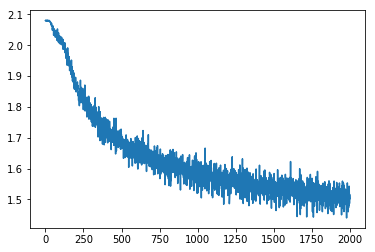

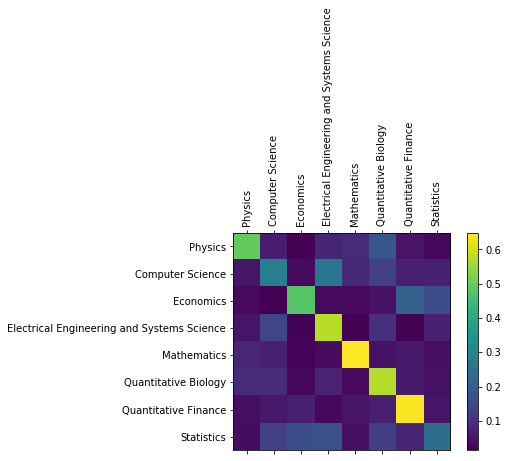

tensor([[49.,  6.,  1.,  8.,  8., 18.,  4.,  2.],
        [ 5., 28.,  3., 26.,  8., 13.,  7.,  6.],
        [ 2.,  1., 47.,  2.,  2.,  4., 20., 16.],
        [ 4., 14.,  1., 58.,  1., 10.,  1.,  7.],
        [ 8.,  7.,  2.,  3., 64.,  4.,  5.,  4.],
        [ 9.,  9.,  2.,  7.,  3., 57.,  6.,  4.],
        [ 3.,  5.,  6.,  2.,  4.,  6., 64.,  4.],
        [ 3., 13., 16., 17.,  3., 13.,  8., 24.]])


In [0]:
training_percentage = 0.9
training_dict = dict()
testing_dict = dict()
for cat in all_categories:
    all_articles = articles_dict[cat]
    shuffle(all_articles)
    p = int(len(all_articles)*training_percentage)
    training_dict[cat] = all_articles[:p]
    testing_dict[cat] = all_articles[p+1:]

learning_rate = 0.005

n_batch_iters = 100000
batch_size = 25
print_every = 100
plot_every = 50

# keep track of losses for plotting
current_loss = 0
all_losses = []

use_characters = 140
print_statistics(use_characters)

model = leakyCNN_model(use_characters, n_letters, n_categories).cuda()
criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(model.parameters(), lr = learning_rate, momentum = 0.9)

start = time.time()

for it in range(1, n_batch_iters+1):
    batch = torch.zeros((batch_size, 1, use_characters, n_letters)).cuda()
    out_batch = torch.zeros(batch_size, dtype=torch.long).cuda()
    optimizer.zero_grad()
    bi = 0
    while bi < batch_size:
        category, abstract, category_tensor, abstract_tensor = randomCNNTrainingSection(use_characters)
        if len(abstract) < use_characters:
            continue
        batch[bi, :, :, :] = abstract_tensor
        out_batch[bi] = category_tensor
        bi += 1
            
    output = model(batch)
    loss = criterion(output, out_batch)
    loss.backward()
    current_loss += loss.item()
    optimizer.step()
    
    if not (it % print_every):
        guess, guess_i = categoryFromOutput(output)
        correct = "V" if guess == category else "X {}".format(category)
        print("{} {}% ({}) {:.4} / {} {}".format(it, round(it/n_batch_iters*100, 2), timeSince(start), loss, guess, correct))
        
    if not (it % plot_every):
        all_losses.append(current_loss / plot_every)
        current_loss = 0
        
plot_losses(all_losses)

rights = 0
wrongs = 0
top2rights = 0
top2wrongs = 0
confusion = torch.zeros(n_categories, n_categories)
with torch.no_grad():
  for cat in all_categories:
      for article in testing_dict[cat]:
          if len(article["abstract"]) < use_characters:
              continue
          abstract_tensor = lineToCNNTensor(article["abstract"][:use_characters]).unsqueeze_(0).cuda()
          cat_i = all_categories.index(cat)
          category_tensor = torch.tensor([cat_i], dtype=torch.long).cuda()
          output = model(abstract_tensor)
          guess1, guess2 = topTwoFromOutput(output)
          if guess1 == cat_i:
              rights += 1
              top2rights += 1
          else:
              wrongs += 1
              if guess2 == cat_i:
                  top2rights += 1
              else:
                  top2wrongs +=1
          confusion[cat_i][guess1] += 1
print("{} accuracy out of {} tests".format(round(100*rights/(rights+wrongs),2), rights+wrongs))
print("Top 2 accuracy was {}".format(round(100*top2rights/(top2rights+top2wrongs), 2)))


# Normalize by dividing every row by its sum
for i in range(n_categories):
    confusion[i] = confusion[i] / confusion[i].sum()

import matplotlib.ticker as ticker
    
# Set up plot
fig = plt.figure()
ax = fig.add_subplot(111)
cax = ax.matshow(confusion.numpy())
fig.colorbar(cax)

# Set up axes
ax.set_xticklabels([''] + all_categories, rotation=90)
ax.set_yticklabels([''] + all_categories)

# Force label at every tick
ax.xaxis.set_major_locator(ticker.MultipleLocator(1))
ax.yaxis.set_major_locator(ticker.MultipleLocator(1))

# sphinx_gallery_thumbnail_number = 2
plt.show()

print(confusion*1000//10)

## Double batch size, (49% / 71%)

With regards to abstracts of length at least 140,
	206044 abstracts for Physics
	143111 abstracts for Computer Science
	   671 abstracts for Economics
	  6318 abstracts for Electrical Engineering and Systems Science
	153542 abstracts for Mathematics
	 25718 abstracts for Quantitative Biology
	 11787 abstracts for Quantitative Finance
	 22070 abstracts for Statistics
100 0.1% (0.0m 11.239248752593994s) 2.074 / Computer Science X Quantitative Finance
200 0.2% (0.0m 22.451599597930908s) 2.081 / Computer Science X Quantitative Biology
300 0.3% (0.0m 33.599676847457886s) 2.078 / Computer Science X Quantitative Biology
400 0.4% (0.0m 44.844478607177734s) 2.071 / Statistics V
500 0.5% (0.0m 56.12183880805969s) 2.083 / Statistics X Quantitative Finance
600 0.6% (1.0m 7.247802019119263s) 2.078 / Statistics X Mathematics
700 0.7% (1.0m 18.338742971420288s) 2.077 / Statistics X Electrical Engineering and Systems Science
800 0.8% (1.0m 29.4065158367157s) 2.083 / Electrical Engineering and Systems 

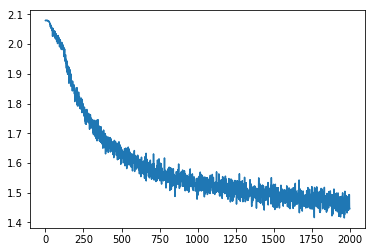

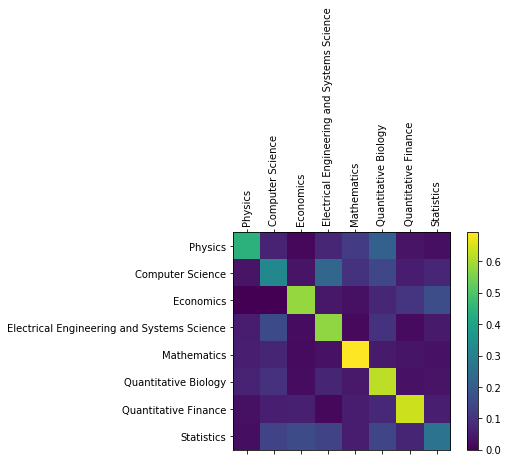

tensor([[44.,  6.,  1.,  7., 12., 21.,  3.,  2.],
        [ 3., 32.,  3., 22., 10., 14.,  5.,  7.],
        [ 0.,  0., 58.,  4.,  2.,  7., 10., 16.],
        [ 5., 15.,  2., 57.,  1., 10.,  1.,  5.],
        [ 5.,  7.,  1.,  3., 69.,  5.,  3.,  3.],
        [ 6.,  9.,  2.,  7.,  4., 62.,  3.,  3.],
        [ 3.,  5.,  6.,  1.,  5.,  7., 63.,  5.],
        [ 2., 14., 15., 14.,  5., 14.,  7., 26.]])


In [0]:
training_percentage = 0.9
training_dict = dict()
testing_dict = dict()
for cat in all_categories:
    all_articles = articles_dict[cat]
    shuffle(all_articles)
    p = int(len(all_articles)*training_percentage)
    training_dict[cat] = all_articles[:p]
    testing_dict[cat] = all_articles[p+1:]

learning_rate = 0.005

n_batch_iters = 100000
batch_size = 50
print_every = 100
plot_every = 50

# keep track of losses for plotting
current_loss = 0
all_losses = []

use_characters = 140
print_statistics(use_characters)

model = leakyCNN_model(use_characters, n_letters, n_categories).cuda()
criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(model.parameters(), lr = learning_rate, momentum = 0.9)

start = time.time()

for it in range(1, n_batch_iters+1):
    batch = torch.zeros((batch_size, 1, use_characters, n_letters)).cuda()
    out_batch = torch.zeros(batch_size, dtype=torch.long).cuda()
    optimizer.zero_grad()
    bi = 0
    while bi < batch_size:
        category, abstract, category_tensor, abstract_tensor = randomCNNTrainingSection(use_characters)
        if len(abstract) < use_characters:
            continue
        batch[bi, :, :, :] = abstract_tensor
        out_batch[bi] = category_tensor
        bi += 1
            
    output = model(batch)
    loss = criterion(output, out_batch)
    loss.backward()
    current_loss += loss.item()
    optimizer.step()
    
    if not (it % print_every):
        guess, guess_i = categoryFromOutput(output)
        correct = "V" if guess == category else "X {}".format(category)
        print("{} {}% ({}) {:.4} / {} {}".format(it, round(it/n_batch_iters*100, 2), timeSince(start), loss, guess, correct))
        
    if not (it % plot_every):
        all_losses.append(current_loss / plot_every)
        current_loss = 0
        
plot_losses(all_losses)

rights = 0
wrongs = 0
top2rights = 0
top2wrongs = 0
confusion = torch.zeros(n_categories, n_categories)
with torch.no_grad():
  for cat in all_categories:
      for article in testing_dict[cat]:
          if len(article["abstract"]) < use_characters:
              continue
          abstract_tensor = lineToCNNTensor(article["abstract"][:use_characters]).unsqueeze_(0).cuda()
          cat_i = all_categories.index(cat)
          category_tensor = torch.tensor([cat_i], dtype=torch.long).cuda()
          output = model(abstract_tensor)
          guess1, guess2 = topTwoFromOutput(output)
          if guess1 == cat_i:
              rights += 1
              top2rights += 1
          else:
              wrongs += 1
              if guess2 == cat_i:
                  top2rights += 1
              else:
                  top2wrongs +=1
          confusion[cat_i][guess1] += 1
print("{} accuracy out of {} tests".format(round(100*rights/(rights+wrongs),2), rights+wrongs))
print("Top 2 accuracy was {}".format(round(100*top2rights/(top2rights+top2wrongs), 2)))


# Normalize by dividing every row by its sum
for i in range(n_categories):
    confusion[i] = confusion[i] / confusion[i].sum()

import matplotlib.ticker as ticker
    
# Set up plot
fig = plt.figure()
ax = fig.add_subplot(111)
cax = ax.matshow(confusion.numpy())
fig.colorbar(cax)

# Set up axes
ax.set_xticklabels([''] + all_categories, rotation=90)
ax.set_yticklabels([''] + all_categories)

# Force label at every tick
ax.xaxis.set_major_locator(ticker.MultipleLocator(1))
ax.yaxis.set_major_locator(ticker.MultipleLocator(1))

# sphinx_gallery_thumbnail_number = 2
plt.show()

print(confusion*1000//10)

## Bigger learning rate (47% / 67%)

With regards to abstracts of length at least 140,
	206044 abstracts for Physics
	143111 abstracts for Computer Science
	   671 abstracts for Economics
	  6318 abstracts for Electrical Engineering and Systems Science
	153542 abstracts for Mathematics
	 25718 abstracts for Quantitative Biology
	 11787 abstracts for Quantitative Finance
	 22070 abstracts for Statistics
100 0.1% (0.0m 5.685887098312378s) 2.072 / Statistics X Computer Science
200 0.2% (0.0m 11.397417545318604s) 2.079 / Statistics V
300 0.3% (0.0m 17.086390018463135s) 2.08 / Mathematics X Quantitative Biology
400 0.4% (0.0m 22.74760150909424s) 2.09 / Economics X Quantitative Biology
500 0.5% (0.0m 28.366893529891968s) 2.077 / Economics X Quantitative Biology
600 0.6% (0.0m 34.083393812179565s) 2.087 / Quantitative Finance X Electrical Engineering and Systems Science
700 0.7% (0.0m 39.71041774749756s) 2.062 / Electrical Engineering and Systems Science X Quantitative Biology
800 0.8% (0.0m 45.349167823791504s) 2.079 / Physics 

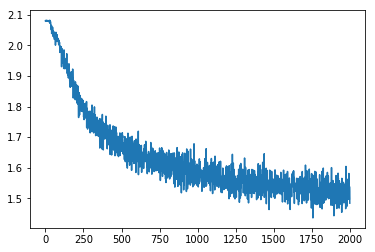

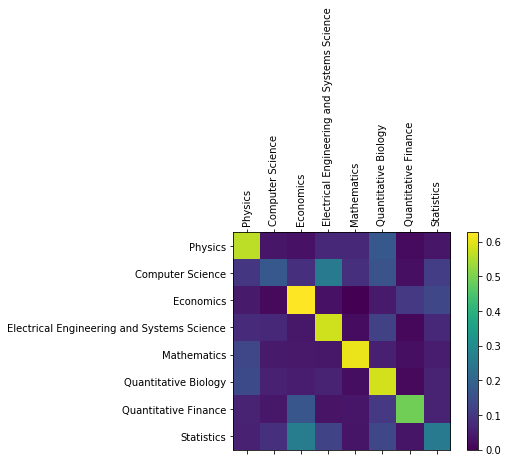

tensor([[56.,  3.,  3.,  6.,  6., 17.,  1.,  3.],
        [ 9., 17.,  8., 25.,  8., 16.,  2., 11.],
        [ 4.,  1., 62.,  2.,  0.,  4., 10., 13.],
        [ 7.,  7.,  3., 58.,  2., 12.,  1.,  7.],
        [13.,  4.,  4.,  4., 60.,  5.,  2.,  4.],
        [14.,  5.,  5.,  6.,  2., 58.,  1.,  6.],
        [ 6.,  4., 16.,  3.,  3., 10., 49.,  6.],
        [ 5.,  8., 26., 12.,  3., 13.,  3., 26.]])


In [0]:
training_percentage = 0.9
training_dict = dict()
testing_dict = dict()
for cat in all_categories:
    all_articles = articles_dict[cat]
    shuffle(all_articles)
    p = int(len(all_articles)*training_percentage)
    training_dict[cat] = all_articles[:p]
    testing_dict[cat] = all_articles[p+1:]

learning_rate = 0.01

n_batch_iters = 100000
batch_size = 25
print_every = 100
plot_every = 50

# keep track of losses for plotting
current_loss = 0
all_losses = []

use_characters = 140
print_statistics(use_characters)

model = leakyCNN_model(use_characters, n_letters, n_categories).cuda()
criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(model.parameters(), lr = learning_rate, momentum = 0.9)

start = time.time()

for it in range(1, n_batch_iters+1):
    batch = torch.zeros((batch_size, 1, use_characters, n_letters)).cuda()
    out_batch = torch.zeros(batch_size, dtype=torch.long).cuda()
    optimizer.zero_grad()
    bi = 0
    while bi < batch_size:
        category, abstract, category_tensor, abstract_tensor = randomCNNTrainingSection(use_characters)
        if len(abstract) < use_characters:
            continue
        batch[bi, :, :, :] = abstract_tensor
        out_batch[bi] = category_tensor
        bi += 1
            
    output = model(batch)
    loss = criterion(output, out_batch)
    loss.backward()
    current_loss += loss.item()
    optimizer.step()
    
    if not (it % print_every):
        guess, guess_i = categoryFromOutput(output)
        correct = "V" if guess == category else "X {}".format(category)
        print("{} {}% ({}) {:.4} / {} {}".format(it, round(it/n_batch_iters*100, 2), timeSince(start), loss, guess, correct))
        
    if not (it % plot_every):
        all_losses.append(current_loss / plot_every)
        current_loss = 0
        
plot_losses(all_losses)

rights = 0
wrongs = 0
top2rights = 0
top2wrongs = 0
confusion = torch.zeros(n_categories, n_categories)
with torch.no_grad():
  for cat in all_categories:
      for article in testing_dict[cat]:
          if len(article["abstract"]) < use_characters:
              continue
          abstract_tensor = lineToCNNTensor(article["abstract"][:use_characters]).unsqueeze_(0).cuda()
          cat_i = all_categories.index(cat)
          category_tensor = torch.tensor([cat_i], dtype=torch.long).cuda()
          output = model(abstract_tensor)
          guess1, guess2 = topTwoFromOutput(output)
          if guess1 == cat_i:
              rights += 1
              top2rights += 1
          else:
              wrongs += 1
              if guess2 == cat_i:
                  top2rights += 1
              else:
                  top2wrongs +=1
          confusion[cat_i][guess1] += 1
print("{} accuracy out of {} tests".format(round(100*rights/(rights+wrongs),2), rights+wrongs))
print("Top 2 accuracy was {}".format(round(100*top2rights/(top2rights+top2wrongs), 2)))


# Normalize by dividing every row by its sum
for i in range(n_categories):
    confusion[i] = confusion[i] / confusion[i].sum()

import matplotlib.ticker as ticker
    
# Set up plot
fig = plt.figure()
ax = fig.add_subplot(111)
cax = ax.matshow(confusion.numpy())
fig.colorbar(cax)

# Set up axes
ax.set_xticklabels([''] + all_categories, rotation=90)
ax.set_yticklabels([''] + all_categories)

# Force label at every tick
ax.xaxis.set_major_locator(ticker.MultipleLocator(1))
ax.yaxis.set_major_locator(ticker.MultipleLocator(1))

# sphinx_gallery_thumbnail_number = 2
plt.show()

print(confusion*1000//10)

## Smaller learning rate, more time, smaller batches (48% / 70%)

With regards to abstracts of length at least 140,
	206044 abstracts for Physics
	143111 abstracts for Computer Science
	   671 abstracts for Economics
	  6318 abstracts for Electrical Engineering and Systems Science
	153542 abstracts for Mathematics
	 25718 abstracts for Quantitative Biology
	 11787 abstracts for Quantitative Finance
	 22070 abstracts for Statistics
100 0.03% (0.0m 4.688918113708496s) 2.076 / Statistics X Quantitative Finance
200 0.07% (0.0m 9.345613718032837s) 2.074 / Economics X Physics
300 0.1% (0.0m 14.007403135299683s) 2.079 / Physics X Economics
400 0.13% (0.0m 18.695852518081665s) 2.086 / Economics X Computer Science
500 0.17% (0.0m 23.324547052383423s) 2.061 / Economics X Statistics
600 0.2% (0.0m 27.95131540298462s) 2.085 / Physics X Mathematics
700 0.23% (0.0m 32.61245274543762s) 2.078 / Statistics X Physics
800 0.27% (0.0m 37.21751260757446s) 2.081 / Economics X Quantitative Biology
900 0.3% (0.0m 41.853304624557495s) 2.083 / Quantitative Finance V
1000 0.33

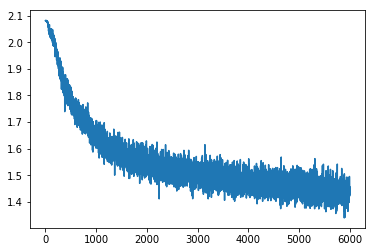

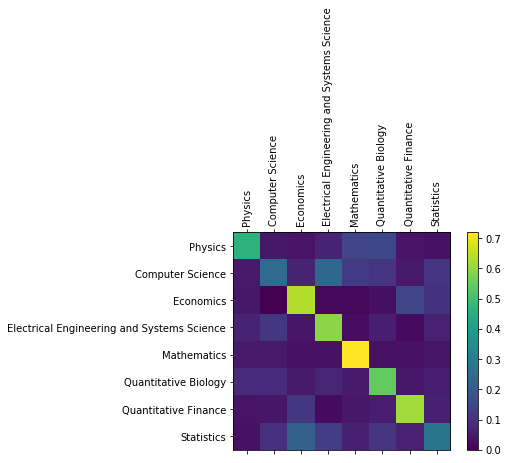

tensor([[46.,  4.,  3.,  6., 14., 15.,  3.,  3.],
        [ 4., 25.,  6., 24., 12., 10.,  4., 10.],
        [ 4.,  0., 63.,  1.,  1.,  3., 15., 10.],
        [ 7., 11.,  4., 59.,  2.,  6.,  2.,  6.],
        [ 5.,  4.,  3.,  3., 71.,  3.,  3.,  4.],
        [ 8.,  8.,  4.,  7.,  5., 54.,  4.,  5.],
        [ 3.,  4., 11.,  2.,  4.,  5., 61.,  6.],
        [ 3.,  9., 21., 13.,  6., 10.,  6., 28.]])


In [0]:
training_percentage = 0.9
training_dict = dict()
testing_dict = dict()
for cat in all_categories:
    all_articles = articles_dict[cat]
    shuffle(all_articles)
    p = int(len(all_articles)*training_percentage)
    training_dict[cat] = all_articles[:p]
    testing_dict[cat] = all_articles[p+1:]

learning_rate = 0.003

n_batch_iters = 300000
batch_size = 20
print_every = 100
plot_every = 50

# keep track of losses for plotting
current_loss = 0
all_losses = []

use_characters = 140
print_statistics(use_characters)

model = leakyCNN_model(use_characters, n_letters, n_categories).cuda()
criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(model.parameters(), lr = learning_rate, momentum = 0.9)

start = time.time()

for it in range(1, n_batch_iters+1):
    batch = torch.zeros((batch_size, 1, use_characters, n_letters)).cuda()
    out_batch = torch.zeros(batch_size, dtype=torch.long).cuda()
    optimizer.zero_grad()
    bi = 0
    while bi < batch_size:
        category, abstract, category_tensor, abstract_tensor = randomCNNTrainingSection(use_characters)
        if len(abstract) < use_characters:
            continue
        batch[bi, :, :, :] = abstract_tensor
        out_batch[bi] = category_tensor
        bi += 1
            
    output = model(batch)
    loss = criterion(output, out_batch)
    loss.backward()
    current_loss += loss.item()
    optimizer.step()
    
    if not (it % print_every):
        guess, guess_i = categoryFromOutput(output)
        correct = "V" if guess == category else "X {}".format(category)
        print("{} {}% ({}) {:.4} / {} {}".format(it, round(it/n_batch_iters*100, 2), timeSince(start), loss, guess, correct))
        
    if not (it % plot_every):
        all_losses.append(current_loss / plot_every)
        current_loss = 0
        
plot_losses(all_losses)

rights = 0
wrongs = 0
top2rights = 0
top2wrongs = 0
confusion = torch.zeros(n_categories, n_categories)
with torch.no_grad():
  for cat in all_categories:
      for article in testing_dict[cat]:
          if len(article["abstract"]) < use_characters:
              continue
          abstract_tensor = lineToCNNTensor(article["abstract"][:use_characters]).unsqueeze_(0).cuda()
          cat_i = all_categories.index(cat)
          category_tensor = torch.tensor([cat_i], dtype=torch.long).cuda()
          output = model(abstract_tensor)
          guess1, guess2 = topTwoFromOutput(output)
          if guess1 == cat_i:
              rights += 1
              top2rights += 1
          else:
              wrongs += 1
              if guess2 == cat_i:
                  top2rights += 1
              else:
                  top2wrongs +=1
          confusion[cat_i][guess1] += 1
print("{} accuracy out of {} tests".format(round(100*rights/(rights+wrongs),2), rights+wrongs))
print("Top 2 accuracy was {}".format(round(100*top2rights/(top2rights+top2wrongs), 2)))


# Normalize by dividing every row by its sum
for i in range(n_categories):
    confusion[i] = confusion[i] / confusion[i].sum()

import matplotlib.ticker as ticker
    
# Set up plot
fig = plt.figure()
ax = fig.add_subplot(111)
cax = ax.matshow(confusion.numpy())
fig.colorbar(cax)

# Set up axes
ax.set_xticklabels([''] + all_categories, rotation=90)
ax.set_yticklabels([''] + all_categories)

# Force label at every tick
ax.xaxis.set_major_locator(ticker.MultipleLocator(1))
ax.yaxis.set_major_locator(ticker.MultipleLocator(1))

# sphinx_gallery_thumbnail_number = 2
plt.show()

print(confusion*1000//10)

## Increase momentum (49% / 70%)

With regards to abstracts of length at least 140,
	206044 abstracts for Physics
	143111 abstracts for Computer Science
	   671 abstracts for Economics
	  6318 abstracts for Electrical Engineering and Systems Science
	153542 abstracts for Mathematics
	 25718 abstracts for Quantitative Biology
	 11787 abstracts for Quantitative Finance
	 22070 abstracts for Statistics
100 0.03% (0.0m 4.620164155960083s) 2.088 / Electrical Engineering and Systems Science X Statistics
200 0.07% (0.0m 9.232181072235107s) 2.083 / Electrical Engineering and Systems Science X Economics
300 0.1% (0.0m 13.84026312828064s) 2.069 / Quantitative Finance X Electrical Engineering and Systems Science
400 0.13% (0.0m 18.476232290267944s) 2.081 / Quantitative Biology X Electrical Engineering and Systems Science
500 0.17% (0.0m 23.089544534683228s) 2.059 / Statistics X Economics
600 0.2% (0.0m 27.730625867843628s) 2.08 / Mathematics X Economics
700 0.23% (0.0m 32.37724184989929s) 2.078 / Mathematics X Computer Science
80

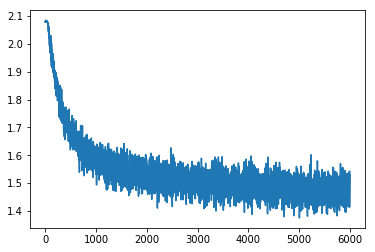

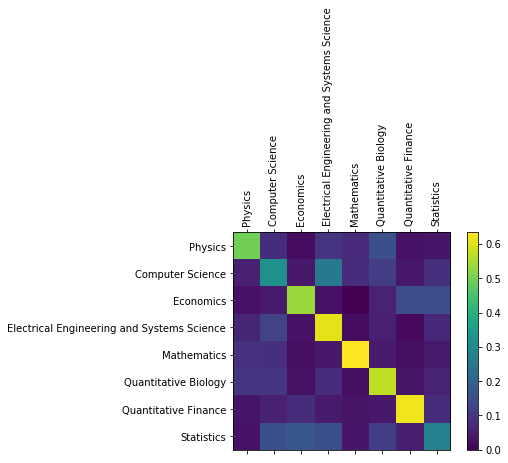

tensor([[49.,  8.,  2.,  9.,  7., 15.,  2.,  3.],
        [ 5., 31.,  4., 25.,  7., 11.,  4.,  8.],
        [ 2.,  4., 53.,  2.,  0.,  5., 14., 14.],
        [ 6., 13.,  3., 60.,  2.,  5.,  1.,  7.],
        [ 9.,  8.,  2.,  4., 63.,  4.,  2.,  4.],
        [ 9.,  9.,  2.,  8.,  2., 57.,  3.,  6.],
        [ 3.,  5.,  8.,  4.,  3.,  4., 61.,  8.],
        [ 3., 15., 17., 15.,  3., 11.,  5., 27.]])


In [0]:
training_percentage = 0.9
training_dict = dict()
testing_dict = dict()
for cat in all_categories:
    all_articles = articles_dict[cat]
    shuffle(all_articles)
    p = int(len(all_articles)*training_percentage)
    training_dict[cat] = all_articles[:p]
    testing_dict[cat] = all_articles[p+1:]

learning_rate = 0.003

n_batch_iters = 300000
batch_size = 20
print_every = 100
plot_every = 50

# keep track of losses for plotting
current_loss = 0
all_losses = []

use_characters = 140
print_statistics(use_characters)

model = leakyCNN_model(use_characters, n_letters, n_categories).cuda()
criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(model.parameters(), lr = learning_rate, momentum = 0.97)

start = time.time()

for it in range(1, n_batch_iters+1):
    batch = torch.zeros((batch_size, 1, use_characters, n_letters)).cuda()
    out_batch = torch.zeros(batch_size, dtype=torch.long).cuda()
    optimizer.zero_grad()
    bi = 0
    while bi < batch_size:
        category, abstract, category_tensor, abstract_tensor = randomCNNTrainingSection(use_characters)
        if len(abstract) < use_characters:
            continue
        batch[bi, :, :, :] = abstract_tensor
        out_batch[bi] = category_tensor
        bi += 1
            
    output = model(batch)
    loss = criterion(output, out_batch)
    loss.backward()
    current_loss += loss.item()
    optimizer.step()
    
    if not (it % print_every):
        guess, guess_i = categoryFromOutput(output)
        correct = "V" if guess == category else "X {}".format(category)
        print("{} {}% ({}) {:.4} / {} {}".format(it, round(it/n_batch_iters*100, 2), timeSince(start), loss, guess, correct))
        
    if not (it % plot_every):
        all_losses.append(current_loss / plot_every)
        current_loss = 0
        
plot_losses(all_losses)

rights = 0
wrongs = 0
top2rights = 0
top2wrongs = 0
confusion = torch.zeros(n_categories, n_categories)
with torch.no_grad():
  for cat in all_categories:
      for article in testing_dict[cat]:
          if len(article["abstract"]) < use_characters:
              continue
          abstract_tensor = lineToCNNTensor(article["abstract"][:use_characters]).unsqueeze_(0).cuda()
          cat_i = all_categories.index(cat)
          category_tensor = torch.tensor([cat_i], dtype=torch.long).cuda()
          output = model(abstract_tensor)
          guess1, guess2 = topTwoFromOutput(output)
          if guess1 == cat_i:
              rights += 1
              top2rights += 1
          else:
              wrongs += 1
              if guess2 == cat_i:
                  top2rights += 1
              else:
                  top2wrongs +=1
          confusion[cat_i][guess1] += 1
print("{} accuracy out of {} tests".format(round(100*rights/(rights+wrongs),2), rights+wrongs))
print("Top 2 accuracy was {}".format(round(100*top2rights/(top2rights+top2wrongs), 2)))


# Normalize by dividing every row by its sum
for i in range(n_categories):
    confusion[i] = confusion[i] / confusion[i].sum()

import matplotlib.ticker as ticker
    
# Set up plot
fig = plt.figure()
ax = fig.add_subplot(111)
cax = ax.matshow(confusion.numpy())
fig.colorbar(cax)

# Set up axes
ax.set_xticklabels([''] + all_categories, rotation=90)
ax.set_yticklabels([''] + all_categories)

# Force label at every tick
ax.xaxis.set_major_locator(ticker.MultipleLocator(1))
ax.yaxis.set_major_locator(ticker.MultipleLocator(1))

# sphinx_gallery_thumbnail_number = 2
plt.show()

print(confusion*1000//10)

# Leaky CNN with not 140 characters

## Use best Leaky setup, 280 characters (68% / 85%)

With regards to abstracts of length at least 280,
	203409 abstracts for Physics
	141431 abstracts for Computer Science
	   669 abstracts for Economics
	  6269 abstracts for Electrical Engineering and Systems Science
	139474 abstracts for Mathematics
	 25540 abstracts for Quantitative Biology
	 11558 abstracts for Quantitative Finance
	 21882 abstracts for Statistics
100 0.1% (0.0m 19.01177978515625s) 2.067 / Physics X Quantitative Finance
200 0.2% (0.0m 38.04049229621887s) 2.061 / Statistics X Quantitative Biology
300 0.3% (0.0m 57.11354947090149s) 2.083 / Physics X Mathematics
400 0.4% (1.0m 16.219756603240967s) 2.091 / Physics X Electrical Engineering and Systems Science
500 0.5% (1.0m 35.27485179901123s) 2.082 / Statistics X Economics
600 0.6% (1.0m 54.39308285713196s) 2.063 / Statistics X Quantitative Finance
700 0.7% (2.0m 13.443040370941162s) 2.093 / Quantitative Finance X Statistics
800 0.8% (2.0m 32.6230571269989s) 2.07 / Economics X Electrical Engineering and Systems Science
9

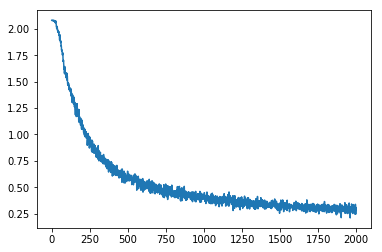

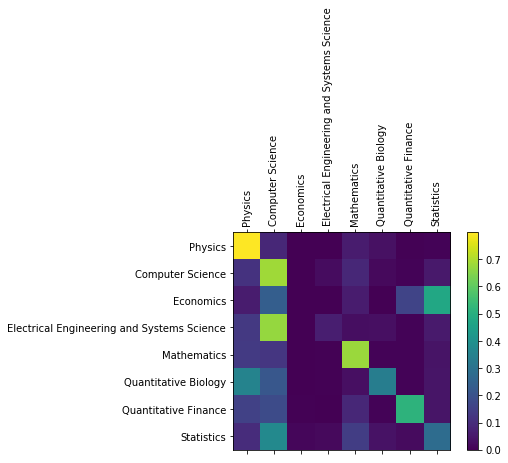

tensor([[79.,  8.,  0.,  0.,  5.,  3.,  0.,  0.],
        [11., 68.,  0.,  2.,  8.,  2.,  0.,  5.],
        [ 5., 23.,  0.,  0.,  5.,  0., 16., 47.],
        [13., 67.,  0.,  6.,  2.,  3.,  0.,  5.],
        [13., 12.,  0.,  0., 67.,  0.,  0.,  4.],
        [35., 21.,  0.,  0.,  3., 34.,  0.,  4.],
        [15., 18.,  0.,  0.,  8.,  0., 51.,  4.],
        [10., 37.,  1.,  2., 14.,  3.,  2., 28.]])


In [0]:
training_percentage = 0.9
training_dict = dict()
testing_dict = dict()
for cat in all_categories:
    all_articles = articles_dict[cat]
    shuffle(all_articles)
    p = int(len(all_articles)*training_percentage)
    training_dict[cat] = all_articles[:p]
    testing_dict[cat] = all_articles[p+1:]

learning_rate = 0.005

n_batch_iters = 100000
batch_size = 25
print_every = 100
plot_every = 50

# keep track of losses for plotting
current_loss = 0
all_losses = []

use_characters = 280
print_statistics(use_characters)

model = leakyCNN_model(use_characters, n_letters, n_categories).cuda()
criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(model.parameters(), lr = learning_rate, momentum = 0.9)

start = time.time()

for it in range(1, n_batch_iters+1):
    batch = torch.zeros((batch_size, 1, use_characters, n_letters)).cuda()
    out_batch = torch.zeros(batch_size, dtype=torch.long).cuda()
    optimizer.zero_grad()
    bi = 0
    while bi < batch_size:
        category, abstract, category_tensor, abstract_tensor = randomCNNTrainingExample(use_characters)
        if len(abstract) < use_characters:
            continue
        batch[bi, :, :, :] = abstract_tensor
        out_batch[bi] = category_tensor
        bi += 1
            
    output = model(batch)
    loss = criterion(output, out_batch)
    loss.backward()
    current_loss += loss.item()
    optimizer.step()
    
    if not (it % print_every):
        guess, guess_i = categoryFromOutput(output)
        correct = "V" if guess == category else "X {}".format(category)
        print("{} {}% ({}) {:.4} / {} {}".format(it, round(it/n_batch_iters*100, 2), timeSince(start), loss, guess, correct))
        
    if not (it % plot_every):
        all_losses.append(current_loss / plot_every)
        current_loss = 0
        
plot_losses(all_losses)

rights = 0
wrongs = 0
top2rights = 0
top2wrongs = 0
confusion = torch.zeros(n_categories, n_categories)
with torch.no_grad():
  for cat in all_categories:
      for article in testing_dict[cat]:
          if len(article["abstract"]) < use_characters:
              continue
          abstract_tensor = lineToCNNTensor(article["abstract"][:use_characters]).unsqueeze_(0).cuda()
          cat_i = all_categories.index(cat)
          category_tensor = torch.tensor([cat_i], dtype=torch.long).cuda()
          output = model(abstract_tensor)
          guess1, guess2 = topTwoFromOutput(output)
          if guess1 == cat_i:
              rights += 1
              top2rights += 1
          else:
              wrongs += 1
              if guess2 == cat_i:
                  top2rights += 1
              else:
                  top2wrongs +=1
          confusion[cat_i][guess1] += 1
print("{} accuracy out of {} tests".format(round(100*rights/(rights+wrongs),2), rights+wrongs))
print("Top 2 accuracy was {}".format(round(100*top2rights/(top2rights+top2wrongs), 2)))


# Normalize by dividing every row by its sum
for i in range(n_categories):
    confusion[i] = confusion[i] / confusion[i].sum()

import matplotlib.ticker as ticker
    
# Set up plot
fig = plt.figure()
ax = fig.add_subplot(111)
cax = ax.matshow(confusion.numpy())
fig.colorbar(cax)

# Set up axes
ax.set_xticklabels([''] + all_categories, rotation=90)
ax.set_yticklabels([''] + all_categories)

# Force label at every tick
ax.xaxis.set_major_locator(ticker.MultipleLocator(1))
ax.yaxis.set_major_locator(ticker.MultipleLocator(1))

# sphinx_gallery_thumbnail_number = 2
plt.show()

print(confusion*1000//10)

## Still 280 characters, increase parameters (69% / 85%)

With regards to abstracts of length at least 280,
	203409 abstracts for Physics
	141431 abstracts for Computer Science
	   669 abstracts for Economics
	  6269 abstracts for Electrical Engineering and Systems Science
	139474 abstracts for Mathematics
	 25540 abstracts for Quantitative Biology
	 11558 abstracts for Quantitative Finance
	 21882 abstracts for Statistics
100 0.07% (0.0m 15.99917721748352s) 2.079 / Electrical Engineering and Systems Science V
200 0.13% (0.0m 31.964393854141235s) 2.078 / Computer Science X Electrical Engineering and Systems Science
300 0.2% (0.0m 47.473793268203735s) 2.079 / Quantitative Biology X Economics
400 0.27% (1.0m 2.9266469478607178s) 2.074 / Computer Science X Quantitative Finance
500 0.33% (1.0m 18.8083918094635s) 2.098 / Statistics X Quantitative Finance
600 0.4% (1.0m 34.49985337257385s) 2.065 / Electrical Engineering and Systems Science X Statistics
700 0.47% (1.0m 50.082000732421875s) 2.08 / Quantitative Finance X Physics
800 0.53% (2.0m 5.6672

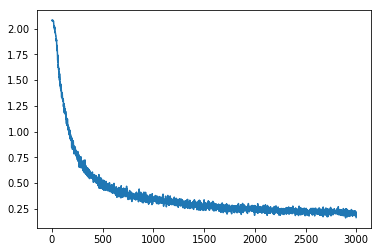

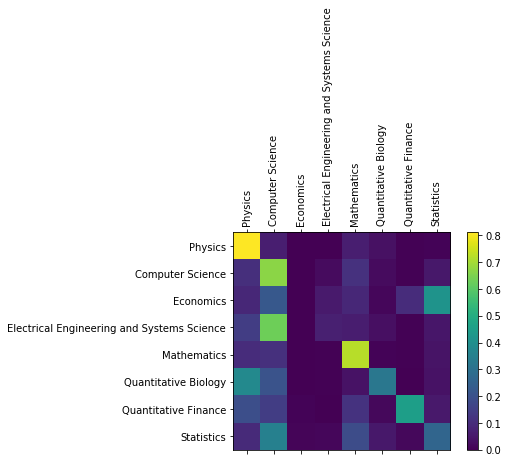

tensor([[81.,  6.,  0.,  0.,  6.,  3.,  0.,  0.],
        [10., 66.,  0.,  2., 11.,  2.,  0.,  5.],
        [ 8., 22.,  0.,  5.,  8.,  1., 10., 41.],
        [14., 63.,  0.,  7.,  6.,  3.,  0.,  4.],
        [10., 11.,  0.,  0., 72.,  0.,  0.,  4.],
        [38., 20.,  0.,  0.,  3., 32.,  0.,  4.],
        [19., 14.,  0.,  0., 11.,  1., 45.,  5.],
        [ 9., 35.,  1.,  1., 18.,  5.,  1., 26.]])


In [0]:
training_percentage = 0.9
training_dict = dict()
testing_dict = dict()
for cat in all_categories:
    all_articles = articles_dict[cat]
    shuffle(all_articles)
    p = int(len(all_articles)*training_percentage)
    training_dict[cat] = all_articles[:p]
    testing_dict[cat] = all_articles[p+1:]

learning_rate = 0.007

n_batch_iters = 150000
batch_size = 35
print_every = 100
plot_every = 50

# keep track of losses for plotting
current_loss = 0
all_losses = []

use_characters = 280
print_statistics(use_characters)

model = leakyCNN_model(use_characters, n_letters, n_categories).cuda()
criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(model.parameters(), lr = learning_rate, momentum = 0.9)

start = time.time()

for it in range(1, n_batch_iters+1):
    batch = torch.zeros((batch_size, 1, use_characters, n_letters)).cuda()
    out_batch = torch.zeros(batch_size, dtype=torch.long).cuda()
    optimizer.zero_grad()
    bi = 0
    while bi < batch_size:
        category, abstract, category_tensor, abstract_tensor = randomCNNTrainingExample(use_characters)
        if len(abstract) < use_characters:
            continue
        batch[bi, :, :, :] = abstract_tensor
        out_batch[bi] = category_tensor
        bi += 1
            
    output = model(batch)
    loss = criterion(output, out_batch)
    loss.backward()
    current_loss += loss.item()
    optimizer.step()
    
    if not (it % print_every):
        guess, guess_i = categoryFromOutput(output)
        correct = "V" if guess == category else "X {}".format(category)
        print("{} {}% ({}) {:.4} / {} {}".format(it, round(it/n_batch_iters*100, 2), timeSince(start), loss, guess, correct))
        
    if not (it % plot_every):
        all_losses.append(current_loss / plot_every)
        current_loss = 0
        
plot_losses(all_losses)

rights = 0
wrongs = 0
top2rights = 0
top2wrongs = 0
confusion = torch.zeros(n_categories, n_categories)
with torch.no_grad():
  for cat in all_categories:
      for article in testing_dict[cat]:
          if len(article["abstract"]) < use_characters:
              continue
          abstract_tensor = lineToCNNTensor(article["abstract"][:use_characters]).unsqueeze_(0).cuda()
          cat_i = all_categories.index(cat)
          category_tensor = torch.tensor([cat_i], dtype=torch.long).cuda()
          output = model(abstract_tensor)
          guess1, guess2 = topTwoFromOutput(output)
          if guess1 == cat_i:
              rights += 1
              top2rights += 1
          else:
              wrongs += 1
              if guess2 == cat_i:
                  top2rights += 1
              else:
                  top2wrongs +=1
          confusion[cat_i][guess1] += 1
print("{} accuracy out of {} tests".format(round(100*rights/(rights+wrongs),2), rights+wrongs))
print("Top 2 accuracy was {}".format(round(100*top2rights/(top2rights+top2wrongs), 2)))


# Normalize by dividing every row by its sum
for i in range(n_categories):
    confusion[i] = confusion[i] / confusion[i].sum()

import matplotlib.ticker as ticker
    
# Set up plot
fig = plt.figure()
ax = fig.add_subplot(111)
cax = ax.matshow(confusion.numpy())
fig.colorbar(cax)

# Set up axes
ax.set_xticklabels([''] + all_categories, rotation=90)
ax.set_yticklabels([''] + all_categories)

# Force label at every tick
ax.xaxis.set_major_locator(ticker.MultipleLocator(1))
ax.yaxis.set_major_locator(ticker.MultipleLocator(1))

# sphinx_gallery_thumbnail_number = 2
plt.show()

print(confusion*1000//10)

## Try "early" stopping ()

With regards to abstracts of length at least 280,
	203409 abstracts for Physics
	141431 abstracts for Computer Science
	   669 abstracts for Economics
	  6269 abstracts for Electrical Engineering and Systems Science
	139474 abstracts for Mathematics
	 25540 abstracts for Quantitative Biology
	 11558 abstracts for Quantitative Finance
	 21882 abstracts for Statistics
100 0.4% (0.0m 17.04298448562622s) 2.081 / Computer Science X Economics
200 0.8% (0.0m 33.94493007659912s) 2.07 / Computer Science X Physics
300 1.2% (0.0m 51.156309843063354s) 2.087 / Quantitative Finance X Economics
400 1.6% (1.0m 7.813159704208374s) 2.085 / Quantitative Finance X Electrical Engineering and Systems Science
500 2.0% (1.0m 24.80250072479248s) 2.074 / Quantitative Biology X Physics
600 2.4% (1.0m 41.79858469963074s) 2.069 / Physics X Quantitative Biology
700 2.8% (1.0m 58.06669521331787s) 2.059 / Quantitative Finance X Economics
800 3.2% (2.0m 14.755321502685547s) 2.075 / Electrical Engineering and Systems S

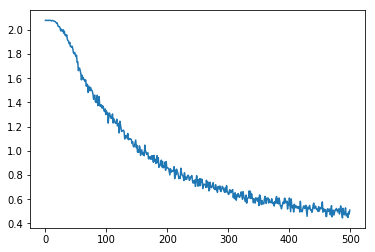

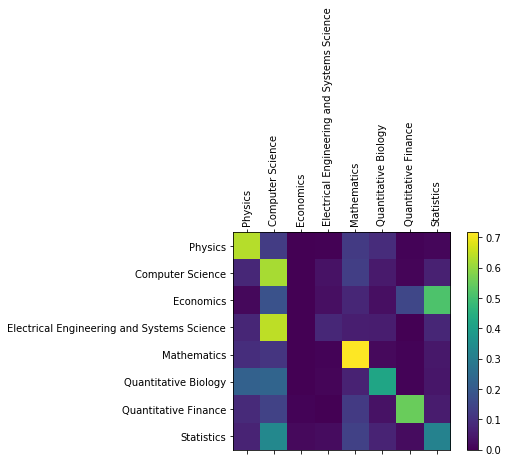

tensor([[63., 12.,  0.,  0., 12.,  9.,  0.,  1.],
        [ 8., 62.,  0.,  3., 13.,  5.,  1.,  6.],
        [ 1., 18.,  0.,  3.,  7.,  3., 15., 51.],
        [ 7., 64.,  0.,  7.,  6.,  5.,  0.,  7.],
        [ 9., 11.,  0.,  0., 71.,  1.,  0.,  4.],
        [22., 23.,  0.,  0.,  6., 42.,  0.,  4.],
        [ 8., 14.,  0.,  0., 12.,  3., 55.,  5.],
        [ 7., 33.,  1.,  2., 13.,  7.,  2., 31.]])


In [0]:
training_percentage = 0.9
training_dict = dict()
testing_dict = dict()
for cat in all_categories:
    all_articles = articles_dict[cat]
    shuffle(all_articles)
    p = int(len(all_articles)*training_percentage)
    training_dict[cat] = all_articles[:p]
    testing_dict[cat] = all_articles[p+1:]

learning_rate = 0.007

n_batch_iters = 25000
batch_size = 35
print_every = 100
plot_every = 50

# keep track of losses for plotting
current_loss = 0
all_losses = []

use_characters = 280
print_statistics(use_characters)

model = leakyCNN_model(use_characters, n_letters, n_categories).cuda()
criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(model.parameters(), lr = learning_rate, momentum = 0.9)

start = time.time()

for it in range(1, n_batch_iters+1):
    batch = torch.zeros((batch_size, 1, use_characters, n_letters)).cuda()
    out_batch = torch.zeros(batch_size, dtype=torch.long).cuda()
    optimizer.zero_grad()
    bi = 0
    while bi < batch_size:
        category, abstract, category_tensor, abstract_tensor = randomCNNTrainingExample(use_characters)
        if len(abstract) < use_characters:
            continue
        batch[bi, :, :, :] = abstract_tensor
        out_batch[bi] = category_tensor
        bi += 1
            
    output = model(batch)
    loss = criterion(output, out_batch)
    loss.backward()
    current_loss += loss.item()
    optimizer.step()
    
    if not (it % print_every):
        guess, guess_i = categoryFromOutput(output)
        correct = "V" if guess == category else "X {}".format(category)
        print("{} {}% ({}) {:.4} / {} {}".format(it, round(it/n_batch_iters*100, 2), timeSince(start), loss, guess, correct))
        
    if not (it % plot_every):
        all_losses.append(current_loss / plot_every)
        current_loss = 0
        
plot_losses(all_losses)

rights = 0
wrongs = 0
top2rights = 0
top2wrongs = 0
confusion = torch.zeros(n_categories, n_categories)
with torch.no_grad():
  for cat in all_categories:
      for article in testing_dict[cat]:
          if len(article["abstract"]) < use_characters:
              continue
          abstract_tensor = lineToCNNTensor(article["abstract"][:use_characters]).unsqueeze_(0).cuda()
          cat_i = all_categories.index(cat)
          category_tensor = torch.tensor([cat_i], dtype=torch.long).cuda()
          output = model(abstract_tensor)
          guess1, guess2 = topTwoFromOutput(output)
          if guess1 == cat_i:
              rights += 1
              top2rights += 1
          else:
              wrongs += 1
              if guess2 == cat_i:
                  top2rights += 1
              else:
                  top2wrongs +=1
          confusion[cat_i][guess1] += 1
print("{} accuracy out of {} tests".format(round(100*rights/(rights+wrongs),2), rights+wrongs))
print("Top 2 accuracy was {}".format(round(100*top2rights/(top2rights+top2wrongs), 2)))


# Normalize by dividing every row by its sum
for i in range(n_categories):
    confusion[i] = confusion[i] / confusion[i].sum()

import matplotlib.ticker as ticker
    
# Set up plot
fig = plt.figure()
ax = fig.add_subplot(111)
cax = ax.matshow(confusion.numpy())
fig.colorbar(cax)

# Set up axes
ax.set_xticklabels([''] + all_categories, rotation=90)
ax.set_yticklabels([''] + all_categories)

# Force label at every tick
ax.xaxis.set_major_locator(ticker.MultipleLocator(1))
ax.yaxis.set_major_locator(ticker.MultipleLocator(1))

# sphinx_gallery_thumbnail_number = 2
plt.show()

print(confusion*1000//10)

# Deeper Leaky CNN

## Can it learn anything at all?

With regards to abstracts of length at least 140,
	206044 abstracts for Physics
	143111 abstracts for Computer Science
	   671 abstracts for Economics
	  6318 abstracts for Electrical Engineering and Systems Science
	153542 abstracts for Mathematics
	 25718 abstracts for Quantitative Biology
	 11787 abstracts for Quantitative Finance
	 22070 abstracts for Statistics
100 1.0% (0.0m 10.91319227218628s) 2.073 / Quantitative Biology X Economics
200 2.0% (0.0m 21.881871938705444s) 2.084 / Quantitative Biology X Computer Science
300 3.0% (0.0m 32.9644935131073s) 2.079 / Physics X Economics
400 4.0% (0.0m 44.01506733894348s) 2.074 / Physics X Quantitative Finance
500 5.0% (0.0m 55.04716682434082s) 2.086 / Physics X Economics
600 6.0% (1.0m 6.065120697021484s) 2.072 / Physics X Computer Science
700 7.0% (1.0m 17.04382348060608s) 2.083 / Physics X Electrical Engineering and Systems Science
800 8.0% (1.0m 28.075688123703003s) 2.078 / Quantitative Biology X Computer Science
900 9.0% (1.0m 39.0365

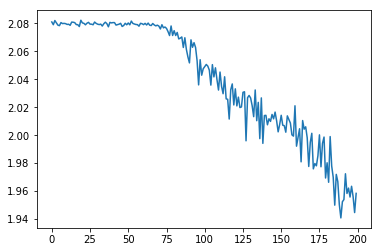

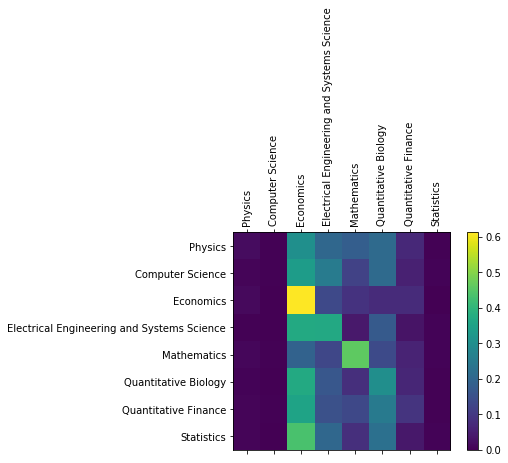

tensor([[ 1.,  0., 30., 20., 18., 21.,  7.,  0.],
        [ 0.,  0., 33., 25., 12., 21.,  5.,  0.],
        [ 1.,  0., 61., 13.,  8.,  7.,  7.,  0.],
        [ 0.,  0., 37., 36.,  4., 17.,  3.,  0.],
        [ 1.,  0., 19., 12., 45., 13.,  6.,  0.],
        [ 0.,  0., 37., 16.,  8., 30.,  6.,  0.],
        [ 0.,  0., 35., 15., 13., 25.,  9.,  0.],
        [ 0.,  0., 43., 20.,  8., 22.,  3.,  0.]])


In [0]:
training_percentage = 0.9
training_dict = dict()
testing_dict = dict()
for cat in all_categories:
    all_articles = articles_dict[cat]
    shuffle(all_articles)
    p = int(len(all_articles)*training_percentage)
    training_dict[cat] = all_articles[:p]
    testing_dict[cat] = all_articles[p+1:]

learning_rate = 0.005

n_batch_iters = 10000
batch_size = 25
print_every = 100
plot_every = 50

# keep track of losses for plotting
current_loss = 0
all_losses = []

use_characters = 140
print_statistics(use_characters)

model = deeperLeakyCNN_model(use_characters, n_letters, n_categories).cuda()
criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(model.parameters(), lr = learning_rate, momentum = 0.9)

start = time.time()

for it in range(1, n_batch_iters+1):
    batch = torch.zeros((batch_size, 1, use_characters, n_letters)).cuda()
    out_batch = torch.zeros(batch_size, dtype=torch.long).cuda()
    optimizer.zero_grad()
    bi = 0
    while bi < batch_size:
        category, abstract, category_tensor, abstract_tensor = randomCNNTrainingExample(use_characters)
        if len(abstract) < use_characters:
            continue
        batch[bi, :, :, :] = abstract_tensor
        out_batch[bi] = category_tensor
        bi += 1
            
    output = model(batch)
    loss = criterion(output, out_batch)
    loss.backward()
    current_loss += loss.item()
    optimizer.step()
    
    if not (it % print_every):
        guess, guess_i = categoryFromOutput(output)
        correct = "V" if guess == category else "X {}".format(category)
        print("{} {}% ({}) {:.4} / {} {}".format(it, round(it/n_batch_iters*100, 2), timeSince(start), loss, guess, correct))
        
    if not (it % plot_every):
        all_losses.append(current_loss / plot_every)
        current_loss = 0
        
plot_losses(all_losses)

rights = 0
wrongs = 0
top2rights = 0
top2wrongs = 0
confusion = torch.zeros(n_categories, n_categories)
with torch.no_grad():
  for cat in all_categories:
      for article in testing_dict[cat]:
          if len(article["abstract"]) < use_characters:
              continue
          abstract_tensor = lineToCNNTensor(article["abstract"][:use_characters]).unsqueeze_(0).cuda()
          cat_i = all_categories.index(cat)
          category_tensor = torch.tensor([cat_i], dtype=torch.long).cuda()
          output = model(abstract_tensor)
          guess1, guess2 = topTwoFromOutput(output)
          if guess1 == cat_i:
              rights += 1
              top2rights += 1
          else:
              wrongs += 1
              if guess2 == cat_i:
                  top2rights += 1
              else:
                  top2wrongs +=1
          confusion[cat_i][guess1] += 1
print("{} accuracy out of {} tests".format(round(100*rights/(rights+wrongs),2), rights+wrongs))
print("Top 2 accuracy was {}".format(round(100*top2rights/(top2rights+top2wrongs), 2)))


# Normalize by dividing every row by its sum
for i in range(n_categories):
    confusion[i] = confusion[i] / confusion[i].sum()

import matplotlib.ticker as ticker
    
# Set up plot
fig = plt.figure()
ax = fig.add_subplot(111)
cax = ax.matshow(confusion.numpy())
fig.colorbar(cax)

# Set up axes
ax.set_xticklabels([''] + all_categories, rotation=90)
ax.set_yticklabels([''] + all_categories)

# Force label at every tick
ax.xaxis.set_major_locator(ticker.MultipleLocator(1))
ax.yaxis.set_major_locator(ticker.MultipleLocator(1))

# sphinx_gallery_thumbnail_number = 2
plt.show()

print(confusion*1000//10)

## Yes it can; have it learn! (41% / 69%)

With regards to abstracts of length at least 140,
	206044 abstracts for Physics
	143111 abstracts for Computer Science
	   671 abstracts for Economics
	  6318 abstracts for Electrical Engineering and Systems Science
	153542 abstracts for Mathematics
	 25718 abstracts for Quantitative Biology
	 11787 abstracts for Quantitative Finance
	 22070 abstracts for Statistics
100 0.1% (0.0m 10.982415914535522s) 2.074 / Quantitative Biology X Computer Science
200 0.2% (0.0m 21.99308705329895s) 2.075 / Statistics V
300 0.3% (0.0m 33.0312225818634s) 2.086 / Mathematics V
400 0.4% (0.0m 43.92209339141846s) 2.067 / Mathematics V
500 0.5% (0.0m 54.78792691230774s) 2.082 / Mathematics X Quantitative Finance
600 0.6% (1.0m 5.7643537521362305s) 2.083 / Economics X Quantitative Biology
700 0.7% (1.0m 16.674765586853027s) 2.078 / Economics X Physics
800 0.8% (1.0m 27.69105815887451s) 2.069 / Computer Science X Quantitative Finance
900 0.9% (1.0m 38.692671060562134s) 2.091 / Physics X Quantitative Biology
1

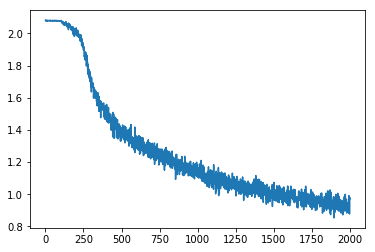

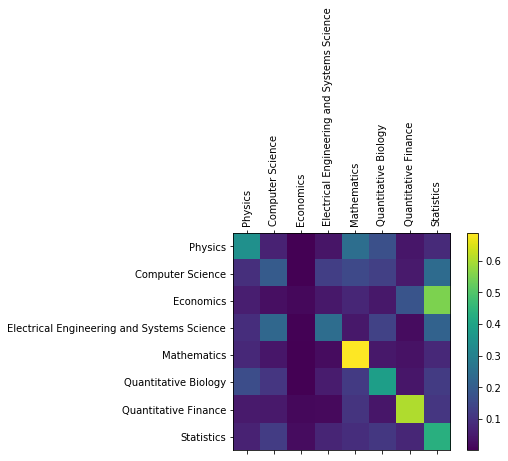

tensor([[34.,  6.,  0.,  4., 24., 16.,  4.,  8.],
        [ 9., 19.,  0., 12., 15., 13.,  5., 24.],
        [ 5.,  2.,  1.,  4.,  7.,  4., 17., 55.],
        [ 9., 23.,  0., 24.,  4., 13.,  2., 21.],
        [ 8.,  4.,  0.,  2., 68.,  4.,  3.,  8.],
        [16., 11.,  0.,  5., 11., 38.,  4., 12.],
        [ 5.,  4.,  1.,  1., 10.,  4., 60., 11.],
        [ 6., 12.,  2.,  7.,  9., 11.,  7., 43.]])


In [0]:
training_percentage = 0.9
training_dict = dict()
testing_dict = dict()
for cat in all_categories:
    all_articles = articles_dict[cat]
    shuffle(all_articles)
    p = int(len(all_articles)*training_percentage)
    training_dict[cat] = all_articles[:p]
    testing_dict[cat] = all_articles[p+1:]

learning_rate = 0.005

n_batch_iters = 100000
batch_size = 25
print_every = 100
plot_every = 50

# keep track of losses for plotting
current_loss = 0
all_losses = []

use_characters = 140
print_statistics(use_characters)

model = deeperLeakyCNN_model(use_characters, n_letters, n_categories).cuda()
criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(model.parameters(), lr = learning_rate, momentum = 0.9)

start = time.time()

for it in range(1, n_batch_iters+1):
    batch = torch.zeros((batch_size, 1, use_characters, n_letters)).cuda()
    out_batch = torch.zeros(batch_size, dtype=torch.long).cuda()
    optimizer.zero_grad()
    bi = 0
    while bi < batch_size:
        category, abstract, category_tensor, abstract_tensor = randomCNNTrainingExample(use_characters)
        if len(abstract) < use_characters:
            continue
        batch[bi, :, :, :] = abstract_tensor
        out_batch[bi] = category_tensor
        bi += 1
            
    output = model(batch)
    loss = criterion(output, out_batch)
    loss.backward()
    current_loss += loss.item()
    optimizer.step()
    
    if not (it % print_every):
        guess, guess_i = categoryFromOutput(output)
        correct = "V" if guess == category else "X {}".format(category)
        print("{} {}% ({}) {:.4} / {} {}".format(it, round(it/n_batch_iters*100, 2), timeSince(start), loss, guess, correct))
        
    if not (it % plot_every):
        all_losses.append(current_loss / plot_every)
        current_loss = 0
        
plot_losses(all_losses)

rights = 0
wrongs = 0
top2rights = 0
top2wrongs = 0
confusion = torch.zeros(n_categories, n_categories)
with torch.no_grad():
  for cat in all_categories:
      for article in testing_dict[cat]:
          if len(article["abstract"]) < use_characters:
              continue
          abstract_tensor = lineToCNNTensor(article["abstract"][:use_characters]).unsqueeze_(0).cuda()
          cat_i = all_categories.index(cat)
          category_tensor = torch.tensor([cat_i], dtype=torch.long).cuda()
          output = model(abstract_tensor)
          guess1, guess2 = topTwoFromOutput(output)
          if guess1 == cat_i:
              rights += 1
              top2rights += 1
          else:
              wrongs += 1
              if guess2 == cat_i:
                  top2rights += 1
              else:
                  top2wrongs +=1
          confusion[cat_i][guess1] += 1
print("{} accuracy out of {} tests".format(round(100*rights/(rights+wrongs),2), rights+wrongs))
print("Top 2 accuracy was {}".format(round(100*top2rights/(top2rights+top2wrongs), 2)))


# Normalize by dividing every row by its sum
for i in range(n_categories):
    confusion[i] = confusion[i] / confusion[i].sum()

import matplotlib.ticker as ticker
    
# Set up plot
fig = plt.figure()
ax = fig.add_subplot(111)
cax = ax.matshow(confusion.numpy())
fig.colorbar(cax)

# Set up axes
ax.set_xticklabels([''] + all_categories, rotation=90)
ax.set_yticklabels([''] + all_categories)

# Force label at every tick
ax.xaxis.set_major_locator(ticker.MultipleLocator(1))
ax.yaxis.set_major_locator(ticker.MultipleLocator(1))

# sphinx_gallery_thumbnail_number = 2
plt.show()

print(confusion*1000//10)

## Smaller batches (31% / 58%)

With regards to abstracts of length at least 140,
	206044 abstracts for Physics
	143111 abstracts for Computer Science
	   671 abstracts for Economics
	  6318 abstracts for Electrical Engineering and Systems Science
	153542 abstracts for Mathematics
	 25718 abstracts for Quantitative Biology
	 11787 abstracts for Quantitative Finance
	 22070 abstracts for Statistics
100 0.1% (0.0m 2.5884063243865967s) 2.083 / Computer Science X Quantitative Finance
200 0.2% (0.0m 5.236253976821899s) 2.096 / Physics X Mathematics
300 0.3% (0.0m 7.884259462356567s) 2.097 / Electrical Engineering and Systems Science V
400 0.4% (0.0m 10.544373273849487s) 2.096 / Economics X Statistics
500 0.5% (0.0m 13.176191091537476s) 2.075 / Economics V
600 0.6% (0.0m 15.786343574523926s) 2.098 / Mathematics X Statistics
700 0.7% (0.0m 18.388365983963013s) 2.072 / Economics V
800 0.8% (0.0m 20.971230030059814s) 2.064 / Quantitative Finance X Quantitative Biology
900 0.9% (0.0m 23.56627130508423s) 2.073 / Quantitative Bi

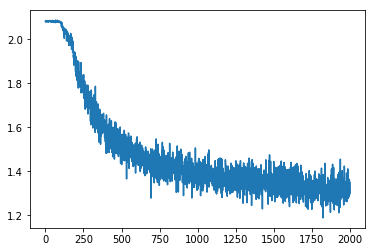

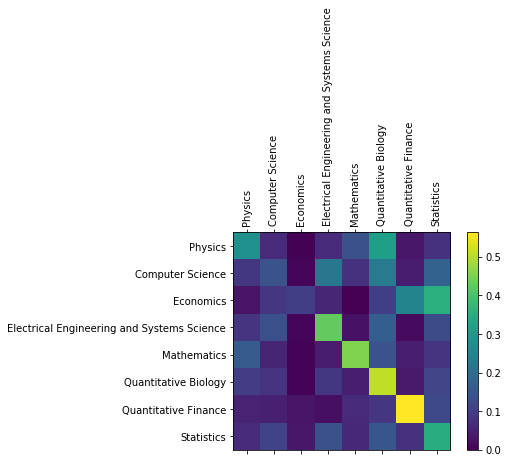

tensor([[28.,  7.,  0.,  6., 14., 31.,  3.,  8.],
        [ 9., 14.,  0., 22.,  8., 23.,  4., 17.],
        [ 2.,  8., 10.,  5.,  0., 10., 25., 35.],
        [ 8., 13.,  0., 42.,  2., 16.,  1., 12.],
        [16.,  5.,  0.,  4., 45., 14.,  4.,  8.],
        [10.,  8.,  0.,  9.,  4., 51.,  3., 11.],
        [ 5.,  4.,  2.,  2.,  6.,  8., 56., 12.],
        [ 6., 11.,  3., 13.,  6., 15.,  8., 35.]])


In [0]:
training_percentage = 0.9
training_dict = dict()
testing_dict = dict()
for cat in all_categories:
    all_articles = articles_dict[cat]
    shuffle(all_articles)
    p = int(len(all_articles)*training_percentage)
    training_dict[cat] = all_articles[:p]
    testing_dict[cat] = all_articles[p+1:]

learning_rate = 0.01

n_batch_iters = 100000
batch_size = 12
print_every = 100
plot_every = 50

# keep track of losses for plotting
current_loss = 0
all_losses = []

use_characters = 140
print_statistics(use_characters)

model = deeperLeakyCNN_model(use_characters, n_letters, n_categories).cuda()
criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(model.parameters(), lr = learning_rate, momentum = 0.9)

start = time.time()

for it in range(1, n_batch_iters+1):
    batch = torch.zeros((batch_size, 1, use_characters, n_letters)).cuda()
    out_batch = torch.zeros(batch_size, dtype=torch.long).cuda()
    optimizer.zero_grad()
    bi = 0
    while bi < batch_size:
        category, abstract, category_tensor, abstract_tensor = randomCNNTrainingExample(use_characters)
        if len(abstract) < use_characters:
            continue
        batch[bi, :, :, :] = abstract_tensor
        out_batch[bi] = category_tensor
        bi += 1
            
    output = model(batch)
    loss = criterion(output, out_batch)
    loss.backward()
    current_loss += loss.item()
    optimizer.step()
    
    if not (it % print_every):
        guess, guess_i = categoryFromOutput(output)
        correct = "V" if guess == category else "X {}".format(category)
        print("{} {}% ({}) {:.4} / {} {}".format(it, round(it/n_batch_iters*100, 2), timeSince(start), loss, guess, correct))
        
    if not (it % plot_every):
        all_losses.append(current_loss / plot_every)
        current_loss = 0
        
plot_losses(all_losses)

rights = 0
wrongs = 0
top2rights = 0
top2wrongs = 0
confusion = torch.zeros(n_categories, n_categories)
with torch.no_grad():
  for cat in all_categories:
      for article in testing_dict[cat]:
          if len(article["abstract"]) < use_characters:
              continue
          abstract_tensor = lineToCNNTensor(article["abstract"][:use_characters]).unsqueeze_(0).cuda()
          cat_i = all_categories.index(cat)
          category_tensor = torch.tensor([cat_i], dtype=torch.long).cuda()
          output = model(abstract_tensor)
          guess1, guess2 = topTwoFromOutput(output)
          if guess1 == cat_i:
              rights += 1
              top2rights += 1
          else:
              wrongs += 1
              if guess2 == cat_i:
                  top2rights += 1
              else:
                  top2wrongs +=1
          confusion[cat_i][guess1] += 1
print("{} accuracy out of {} tests".format(round(100*rights/(rights+wrongs),2), rights+wrongs))
print("Top 2 accuracy was {}".format(round(100*top2rights/(top2rights+top2wrongs), 2)))


# Normalize by dividing every row by its sum
for i in range(n_categories):
    confusion[i] = confusion[i] / confusion[i].sum()

import matplotlib.ticker as ticker
    
# Set up plot
fig = plt.figure()
ax = fig.add_subplot(111)
cax = ax.matshow(confusion.numpy())
fig.colorbar(cax)

# Set up axes
ax.set_xticklabels([''] + all_categories, rotation=90)
ax.set_yticklabels([''] + all_categories)

# Force label at every tick
ax.xaxis.set_major_locator(ticker.MultipleLocator(1))
ax.yaxis.set_major_locator(ticker.MultipleLocator(1))

# sphinx_gallery_thumbnail_number = 2
plt.show()

print(confusion*1000//10)

## Bigger batches, less training iterations (42% / 69%)

With regards to abstracts of length at least 140,
	206044 abstracts for Physics
	143111 abstracts for Computer Science
	   671 abstracts for Economics
	  6318 abstracts for Electrical Engineering and Systems Science
	153542 abstracts for Mathematics
	 25718 abstracts for Quantitative Biology
	 11787 abstracts for Quantitative Finance
	 22070 abstracts for Statistics
100 0.2% (0.0m 10.060796737670898s) 2.079 / Quantitative Biology X Quantitative Finance
200 0.4% (0.0m 20.109452724456787s) 2.082 / Statistics X Economics
300 0.6% (0.0m 30.242453575134277s) 2.08 / Statistics X Economics
400 0.8% (0.0m 40.2978310585022s) 2.085 / Quantitative Biology X Quantitative Finance
500 1.0% (0.0m 50.318215131759644s) 2.084 / Physics X Computer Science
600 1.2% (1.0m 0.3387322425842285s) 2.077 / Physics X Computer Science
700 1.4% (1.0m 10.463757276535034s) 2.073 / Economics V
800 1.6% (1.0m 20.486249685287476s) 2.089 / Quantitative Finance X Physics
900 1.8% (1.0m 30.49474859237671s) 2.08 / Electrica

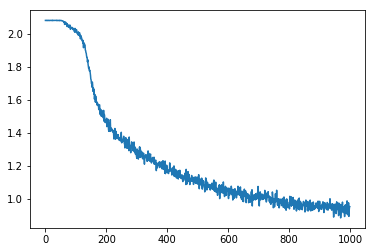

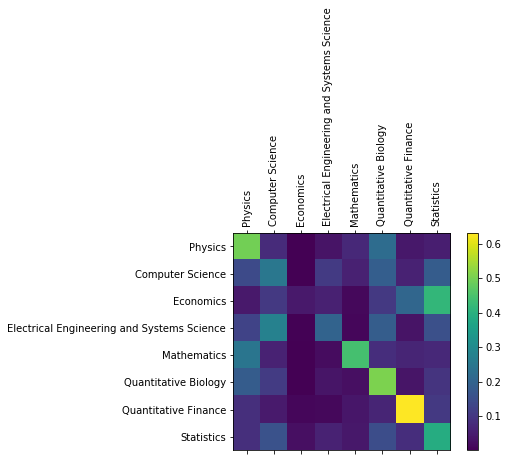

tensor([[49.,  7.,  0.,  3.,  7., 22.,  4.,  5.],
        [14., 25.,  0., 10.,  5., 19.,  6., 18.],
        [ 4., 10.,  4.,  5.,  1., 10., 20., 41.],
        [12., 27.,  0., 20.,  1., 18.,  3., 15.],
        [24.,  6.,  0.,  2., 44.,  8.,  6.,  7.],
        [18., 11.,  0.,  3.,  2., 50.,  3.,  9.],
        [ 8.,  4.,  1.,  1.,  3.,  6., 63., 10.],
        [ 8., 15.,  2.,  6.,  4., 15.,  8., 39.]])


In [0]:
training_percentage = 0.9
training_dict = dict()
testing_dict = dict()
for cat in all_categories:
    all_articles = articles_dict[cat]
    shuffle(all_articles)
    p = int(len(all_articles)*training_percentage)
    training_dict[cat] = all_articles[:p]
    testing_dict[cat] = all_articles[p+1:]

learning_rate = 0.01

n_batch_iters = 50000
batch_size = 48
print_every = 100
plot_every = 50

# keep track of losses for plotting
current_loss = 0
all_losses = []

use_characters = 140
print_statistics(use_characters)

model = deeperLeakyCNN_model(use_characters, n_letters, n_categories).cuda()
criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(model.parameters(), lr = learning_rate, momentum = 0.9)

start = time.time()

for it in range(1, n_batch_iters+1):
    batch = torch.zeros((batch_size, 1, use_characters, n_letters)).cuda()
    out_batch = torch.zeros(batch_size, dtype=torch.long).cuda()
    optimizer.zero_grad()
    bi = 0
    while bi < batch_size:
        category, abstract, category_tensor, abstract_tensor = randomCNNTrainingExample(use_characters)
        if len(abstract) < use_characters:
            continue
        batch[bi, :, :, :] = abstract_tensor
        out_batch[bi] = category_tensor
        bi += 1
            
    output = model(batch)
    loss = criterion(output, out_batch)
    loss.backward()
    current_loss += loss.item()
    optimizer.step()
    
    if not (it % print_every):
        guess, guess_i = categoryFromOutput(output)
        correct = "V" if guess == category else "X {}".format(category)
        print("{} {}% ({}) {:.4} / {} {}".format(it, round(it/n_batch_iters*100, 2), timeSince(start), loss, guess, correct))
        
    if not (it % plot_every):
        all_losses.append(current_loss / plot_every)
        current_loss = 0
        
plot_losses(all_losses)

rights = 0
wrongs = 0
top2rights = 0
top2wrongs = 0
confusion = torch.zeros(n_categories, n_categories)
with torch.no_grad():
  for cat in all_categories:
      for article in testing_dict[cat]:
          if len(article["abstract"]) < use_characters:
              continue
          abstract_tensor = lineToCNNTensor(article["abstract"][:use_characters]).unsqueeze_(0).cuda()
          cat_i = all_categories.index(cat)
          category_tensor = torch.tensor([cat_i], dtype=torch.long).cuda()
          output = model(abstract_tensor)
          guess1, guess2 = topTwoFromOutput(output)
          if guess1 == cat_i:
              rights += 1
              top2rights += 1
          else:
              wrongs += 1
              if guess2 == cat_i:
                  top2rights += 1
              else:
                  top2wrongs +=1
          confusion[cat_i][guess1] += 1
print("{} accuracy out of {} tests".format(round(100*rights/(rights+wrongs),2), rights+wrongs))
print("Top 2 accuracy was {}".format(round(100*top2rights/(top2rights+top2wrongs), 2)))


# Normalize by dividing every row by its sum
for i in range(n_categories):
    confusion[i] = confusion[i] / confusion[i].sum()

import matplotlib.ticker as ticker
    
# Set up plot
fig = plt.figure()
ax = fig.add_subplot(111)
cax = ax.matshow(confusion.numpy())
fig.colorbar(cax)

# Set up axes
ax.set_xticklabels([''] + all_categories, rotation=90)
ax.set_yticklabels([''] + all_categories)

# Force label at every tick
ax.xaxis.set_major_locator(ticker.MultipleLocator(1))
ax.yaxis.set_major_locator(ticker.MultipleLocator(1))

# sphinx_gallery_thumbnail_number = 2
plt.show()

print(confusion*1000//10)

## Slightly smaller batches, more training (40% / 67%)

With regards to abstracts of length at least 140,
	206044 abstracts for Physics
	143111 abstracts for Computer Science
	   671 abstracts for Economics
	  6318 abstracts for Electrical Engineering and Systems Science
	153542 abstracts for Mathematics
	 25718 abstracts for Quantitative Biology
	 11787 abstracts for Quantitative Finance
	 22070 abstracts for Statistics
100 0.1% (0.0m 8.34813642501831s) 2.077 / Economics X Electrical Engineering and Systems Science
200 0.2% (0.0m 16.72881817817688s) 2.078 / Mathematics X Economics
300 0.3% (0.0m 25.087365865707397s) 2.077 / Electrical Engineering and Systems Science V
400 0.4% (0.0m 33.385414123535156s) 2.076 / Computer Science X Economics
500 0.5% (0.0m 41.673848152160645s) 2.085 / Electrical Engineering and Systems Science X Quantitative Biology
600 0.6% (0.0m 49.91935110092163s) 2.086 / Mathematics X Economics
700 0.7% (0.0m 58.105310678482056s) 2.081 / Electrical Engineering and Systems Science X Quantitative Biology
800 0.8% (1.0m 6.2

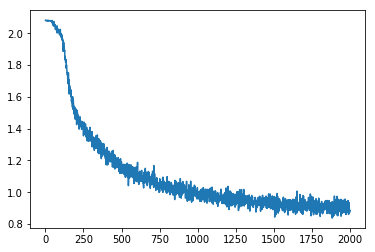

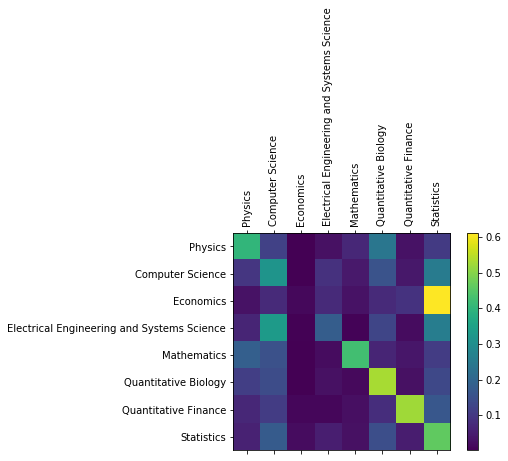

tensor([[40., 12.,  0.,  2.,  7., 24.,  3., 10.],
        [ 9., 31.,  0.,  8.,  4., 15.,  3., 25.],
        [ 2.,  7.,  1.,  7.,  2.,  7.,  8., 61.],
        [ 6., 33.,  0., 18.,  0., 12.,  2., 25.],
        [18., 15.,  0.,  2., 42.,  6.,  3., 10.],
        [11., 14.,  0.,  2.,  1., 53.,  2., 13.],
        [ 6., 10.,  1.,  1.,  2.,  8., 52., 16.],
        [ 5., 17.,  2.,  5.,  2., 14.,  4., 46.]])


In [0]:
training_percentage = 0.9
training_dict = dict()
testing_dict = dict()
for cat in all_categories:
    all_articles = articles_dict[cat]
    shuffle(all_articles)
    p = int(len(all_articles)*training_percentage)
    training_dict[cat] = all_articles[:p]
    testing_dict[cat] = all_articles[p+1:]

learning_rate = 0.01

n_batch_iters = 100000
batch_size = 36
print_every = 100
plot_every = 50

# keep track of losses for plotting
current_loss = 0
all_losses = []

use_characters = 140
print_statistics(use_characters)

model = deeperLeakyCNN_model(use_characters, n_letters, n_categories).cuda()
criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(model.parameters(), lr = learning_rate, momentum = 0.9)

start = time.time()

for it in range(1, n_batch_iters+1):
    batch = torch.zeros((batch_size, 1, use_characters, n_letters)).cuda()
    out_batch = torch.zeros(batch_size, dtype=torch.long).cuda()
    optimizer.zero_grad()
    bi = 0
    while bi < batch_size:
        category, abstract, category_tensor, abstract_tensor = randomCNNTrainingExample(use_characters)
        if len(abstract) < use_characters:
            continue
        batch[bi, :, :, :] = abstract_tensor
        out_batch[bi] = category_tensor
        bi += 1
            
    output = model(batch)
    loss = criterion(output, out_batch)
    loss.backward()
    current_loss += loss.item()
    optimizer.step()
    
    if not (it % print_every):
        guess, guess_i = categoryFromOutput(output)
        correct = "V" if guess == category else "X {}".format(category)
        print("{} {}% ({}) {:.4} / {} {}".format(it, round(it/n_batch_iters*100, 2), timeSince(start), loss, guess, correct))
        
    if not (it % plot_every):
        all_losses.append(current_loss / plot_every)
        current_loss = 0
        
plot_losses(all_losses)

rights = 0
wrongs = 0
top2rights = 0
top2wrongs = 0
confusion = torch.zeros(n_categories, n_categories)
with torch.no_grad():
  for cat in all_categories:
      for article in testing_dict[cat]:
          if len(article["abstract"]) < use_characters:
              continue
          abstract_tensor = lineToCNNTensor(article["abstract"][:use_characters]).unsqueeze_(0).cuda()
          cat_i = all_categories.index(cat)
          category_tensor = torch.tensor([cat_i], dtype=torch.long).cuda()
          output = model(abstract_tensor)
          guess1, guess2 = topTwoFromOutput(output)
          if guess1 == cat_i:
              rights += 1
              top2rights += 1
          else:
              wrongs += 1
              if guess2 == cat_i:
                  top2rights += 1
              else:
                  top2wrongs +=1
          confusion[cat_i][guess1] += 1
print("{} accuracy out of {} tests".format(round(100*rights/(rights+wrongs),2), rights+wrongs))
print("Top 2 accuracy was {}".format(round(100*top2rights/(top2rights+top2wrongs), 2)))


# Normalize by dividing every row by its sum
for i in range(n_categories):
    confusion[i] = confusion[i] / confusion[i].sum()

import matplotlib.ticker as ticker
    
# Set up plot
fig = plt.figure()
ax = fig.add_subplot(111)
cax = ax.matshow(confusion.numpy())
fig.colorbar(cax)

# Set up axes
ax.set_xticklabels([''] + all_categories, rotation=90)
ax.set_yticklabels([''] + all_categories)

# Force label at every tick
ax.xaxis.set_major_locator(ticker.MultipleLocator(1))
ax.yaxis.set_major_locator(ticker.MultipleLocator(1))

# sphinx_gallery_thumbnail_number = 2
plt.show()

print(confusion*1000//10)

## Batches of previous size, same training, train with slices (50% / 71%)

With regards to abstracts of length at least 140,
	206044 abstracts for Physics
	143111 abstracts for Computer Science
	   671 abstracts for Economics
	  6318 abstracts for Electrical Engineering and Systems Science
	153542 abstracts for Mathematics
	 25718 abstracts for Quantitative Biology
	 11787 abstracts for Quantitative Finance
	 22070 abstracts for Statistics
100 0.1% (0.0m 10.283449649810791s) 2.08 / Computer Science X Economics
200 0.2% (0.0m 20.597633361816406s) 2.077 / Economics X Mathematics
300 0.3% (0.0m 30.901703357696533s) 2.089 / Quantitative Finance X Mathematics
400 0.4% (0.0m 41.24308967590332s) 2.084 / Statistics X Economics
500 0.5% (0.0m 51.724146366119385s) 2.078 / Mathematics X Quantitative Biology
600 0.6% (1.0m 2.0918819904327393s) 2.071 / Physics X Quantitative Finance
700 0.7% (1.0m 12.613078832626343s) 2.08 / Computer Science X Electrical Engineering and Systems Science
800 0.8% (1.0m 23.184975624084473s) 2.081 / Physics X Computer Science
900 0.9% (1.0m 3

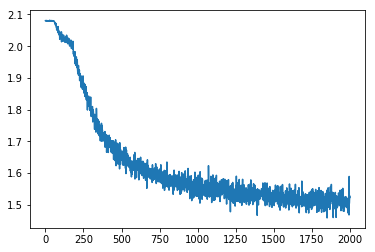

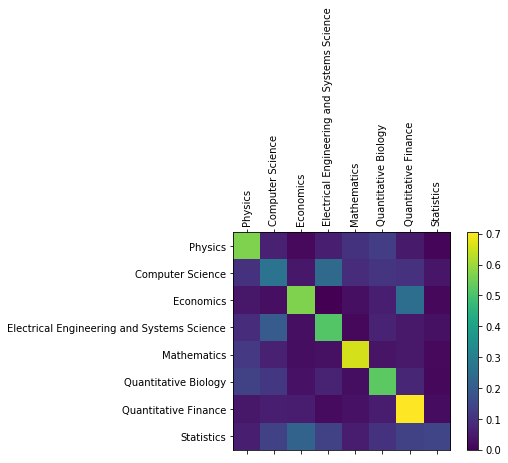

tensor([[56.,  6.,  1.,  5., 10., 12.,  5.,  1.],
        [10., 26.,  4., 24.,  8., 10., 10.,  4.],
        [ 4.,  2., 56.,  0.,  2.,  5., 25.,  1.],
        [ 9., 20.,  3., 51.,  1.,  6.,  4.,  3.],
        [11.,  6.,  2.,  3., 65.,  3.,  4.,  1.],
        [13., 11.,  3.,  6.,  2., 52.,  7.,  1.],
        [ 4.,  6.,  5.,  1.,  3.,  5., 70.,  2.],
        [ 5., 13., 22., 13.,  5., 10., 13., 14.]])


In [0]:
training_percentage = 0.9
training_dict = dict()
testing_dict = dict()
for cat in all_categories:
    all_articles = articles_dict[cat]
    shuffle(all_articles)
    p = int(len(all_articles)*training_percentage)
    training_dict[cat] = all_articles[:p]
    testing_dict[cat] = all_articles[p+1:]

learning_rate = 0.01

n_batch_iters = 100000
batch_size = 48
print_every = 100
plot_every = 50

# keep track of losses for plotting
current_loss = 0
all_losses = []

use_characters = 140
print_statistics(use_characters)

model = deeperLeakyCNN_model(use_characters, n_letters, n_categories).cuda()
criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(model.parameters(), lr = learning_rate, momentum = 0.9)

start = time.time()

for it in range(1, n_batch_iters+1):
    batch = torch.zeros((batch_size, 1, use_characters, n_letters)).cuda()
    out_batch = torch.zeros(batch_size, dtype=torch.long).cuda()
    optimizer.zero_grad()
    bi = 0
    while bi < batch_size:
        category, abstract, category_tensor, abstract_tensor = randomCNNTrainingSection(use_characters)
        if len(abstract) < use_characters:
            continue
        batch[bi, :, :, :] = abstract_tensor
        out_batch[bi] = category_tensor
        bi += 1
            
    output = model(batch)
    loss = criterion(output, out_batch)
    loss.backward()
    current_loss += loss.item()
    optimizer.step()
    
    if not (it % print_every):
        guess, guess_i = categoryFromOutput(output)
        correct = "V" if guess == category else "X {}".format(category)
        print("{} {}% ({}) {:.4} / {} {}".format(it, round(it/n_batch_iters*100, 2), timeSince(start), loss, guess, correct))
        
    if not (it % plot_every):
        all_losses.append(current_loss / plot_every)
        current_loss = 0
        
plot_losses(all_losses)

rights = 0
wrongs = 0
top2rights = 0
top2wrongs = 0
confusion = torch.zeros(n_categories, n_categories)
with torch.no_grad():
  for cat in all_categories:
      for article in testing_dict[cat]:
          if len(article["abstract"]) < use_characters:
              continue
          abstract_tensor = lineToCNNTensor(article["abstract"][:use_characters]).unsqueeze_(0).cuda()
          cat_i = all_categories.index(cat)
          category_tensor = torch.tensor([cat_i], dtype=torch.long).cuda()
          output = model(abstract_tensor)
          guess1, guess2 = topTwoFromOutput(output)
          if guess1 == cat_i:
              rights += 1
              top2rights += 1
          else:
              wrongs += 1
              if guess2 == cat_i:
                  top2rights += 1
              else:
                  top2wrongs +=1
          confusion[cat_i][guess1] += 1
print("{} accuracy out of {} tests".format(round(100*rights/(rights+wrongs),2), rights+wrongs))
print("Top 2 accuracy was {}".format(round(100*top2rights/(top2rights+top2wrongs), 2)))


# Normalize by dividing every row by its sum
for i in range(n_categories):
    confusion[i] = confusion[i] / confusion[i].sum()

import matplotlib.ticker as ticker
    
# Set up plot
fig = plt.figure()
ax = fig.add_subplot(111)
cax = ax.matshow(confusion.numpy())
fig.colorbar(cax)

# Set up axes
ax.set_xticklabels([''] + all_categories, rotation=90)
ax.set_yticklabels([''] + all_categories)

# Force label at every tick
ax.xaxis.set_major_locator(ticker.MultipleLocator(1))
ax.yaxis.set_major_locator(ticker.MultipleLocator(1))

# sphinx_gallery_thumbnail_number = 2
plt.show()

print(confusion*1000//10)